In [101]:
# import the required python modules

import numpy as np
import autograd.numpy as npa
from autograd.numpy import pi, real, conj

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize

from random import random

In [102]:
from ceviche_utilities import *

In [103]:
# constants

EPSILON_0 = 8.85418782e-12              # vacuum permittivity
MU_0 = 1.25663706e-6                    # vacuum permeability
C_0 = 1 / np.sqrt(EPSILON_0 * MU_0)     # speed of light in vacuum
Q_e = 1.602176634e-19                   # funamental charge

In [104]:
def pxl(x):
    '''converts meters to pixels (dl)'''
    return int(x/dl)

In [105]:
def viz_epsr_rho(epsr, rho):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 3), dpi=200, tight_layout=True)
    er = axs[0].imshow(epsr.T, cmap='Greys', origin='lower')
    rh = axs[1].imshow(np.real(rho).T, cmap='Greys', origin='lower', vmin=0, vmax=1)

    # text
    axs[0].text(10, Ny - Ny//5, r"$\varepsilon_r$", fontsize=20)
    axs[1].text(10, Ny - Ny//5, r"$\rho$", fontsize=20)

    # colorbars
    cbar_er = plt.colorbar(er, ax=axs[0], orientation="horizontal", aspect=20)
    plt.colorbar(rh, ax=axs[1], orientation="horizontal", aspect=20)
    plt.show()

In [106]:
def callback_output_structure(iteration, of_list, rho):
    """Callback function to output fields and the structures (for making sweet gifs)"""
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(
        rho, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)
    
    viz_epsr_rho(epsr, rho)
    # np.savetxt(f"saved_structures\\schedule\\{iteration}.txt", epsr)
    np.savetxt(f"saved_structures\\schedule\\rho_{iteration}.txt", rho)


def callback_beta_schedule(iteration, of_list, rho):
    """Callback function for the optimizer to schedule changes to beta with the iteration number"""
    
    global beta_proj
    if iteration < 50:
        beta_proj = 10
    elif 50 <= iteration & iteration < 75:
        beta_proj = 100
    elif 75 <= iteration & iteration < 100:
        beta_proj = 200
    else:
        beta_proj = 300

    # Chain with the output structure callback
    callback_output_structure(iteration, of_list, rho)

In [107]:
def mask_combine_epsr(epsr, bg_epsr, base_region):
    """Utility function for combining the design region epsr and the background epsr
    """
    return bg_epsr*base_region + epsr*(base_region == 0).astype(float)


def epsr_parameterization(rho, bg_rho, design_region, epsr_min, epsr_max, radius=1, N_blur=1, beta=100, eta=0.5, N_proj=1):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho
    rho = mask_combine_rho(rho, bg_rho, design_region)

    rho_blur = operator_blur(npa.concatenate((rho[:,Ny//2:], rho ,rho[:, :Ny//2]), axis=1), radius=radius, N=N_blur)
    rho = rho_blur[:, (rho_blur.shape[1])//4:(3*rho_blur.shape[1]//4)]
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)

    epsr = epsr_min + (epsr_max-epsr_min) * rho

    # Final masking (SiO2 base)
    epsr = mask_combine_epsr(epsr, val_epsr_SiO2, base_region)

    return epsr

In [108]:
def viz_epsr(epsr):
    ceviche.viz.real(epsr, cbar=True, cmap='jet', DK_title='epsr', DK_min=1, DK_max=5/4*val_epsr_Si)

## iSPR&CDR inverse design for 1/2/3/5 frequencies 
(numerical aperture 0.22)

In [109]:
# parameters

################################################################################
# optimization
Nsteps = 100        # Number of epochs in the optimization 
step_size = 1e-2    # Step size for the Adam optimizer

################################################################################
# epsilon parametrization
blur_radius = 2       # Radius of the circle for the conv kernel filter
N_blur = 2            # Number of times to apply the filter
beta_proj = 200       # Strength of the projection
eta_proj = 0.5        # Center of the projection between 0 and 1
N_proj = 1            # Number of times to apply the projection

################################################################################
# geometry

a = 240e-9          # grating period (in m)
F = 0.9             # grating fill factor
h = 240e-9          # grating tooth height
d = 20e-9           # impact parameter
base = 100e-9       # grating base height
xR_PML = 150e-9     # distance from the right PML to the bottom of the grating
xL_PML = 150e-9     # distance from the left PML to the electron path
detector = 100e-9   # separation between the detectors and the PMLs

################################################################################
# FD simulation parameters

dl = 4e-9            # element size (in m) # Note: use dl>2 only for a quick check
Npml = 20            # Size of the PML boundaries in pixels 

# Simulation domain size (in number of pixels)
Nx = int((xR_PML + xL_PML + base + h + d) / dl) + 2*Npml + 1
Ny = int(a / dl) + 1
   
################################################################################
# material

nSi = 3.727                 # refractive index of Si
nSiO2 = 1.455               # refractive index of SiO2
val_epsr_Si = nSi**2        # relative permittivity of Si
val_epsr_SiO2 = nSiO2**2    # relative permittivity of SiO2

################################################################################
# electron beam

beta = 0.32838       # electron relative velocity
sigma_x = 3e-9       # electron beam sigma_x  

################################################################################
# radiation

# frequencies = 2*pi * np.array((3.89e+14, 4.00e+14, 4.12e+14, 4.24e+14, 4.36e+14))
# frequencies = 2*pi * np.array((3.89e+14, 4.12e+14, 4.36e+14))
# frequencies = 2*pi * np.array((4.00e+14, 4.24e+14))
frequencies = [2*pi * 4.12e+14]


################################################################################

In [110]:
# def init_domain(): ...

# Initialize relative permittivity of the domain
# epsr = np.ones((Nx, Ny))
rho = np.zeros((Nx, Ny))
bg_rho = np.zeros((Nx, Ny))

epsr_min = 1
epsr_max = val_epsr_Si

#################################################
# grating for Smith-Purcell

x1 = Npml + pxl(xL_PML + d)
x2 = Npml + pxl(xL_PML + d + h)
y1 = int(Ny/2*(1-F))
y2 = int(Ny/2*(1-F) + F*Ny)
rho[x2:Nx, :]  = eta_proj #+ 0.1 * (2 * np.random.random(rho[x2:Nx, :].shape) - 1)
rho[x1:x2, :]  = eta_proj + 0.1 * (2 * np.random.random(rho[x1:x2, :].shape) - 1)
#################################################

# Region within which the permittivity is allowed to change
design_region = np.zeros((Nx, Ny))
design_region[x1:x2, :] = 1
bg_rho[x2:Nx, :] = eta_proj

# SiO2 base
base_region = np.zeros((Nx, Ny))
base_region[x2:Nx, :] = 1

rho_initial = rho


In [111]:
epsr = epsr_parameterization(
    rho, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)

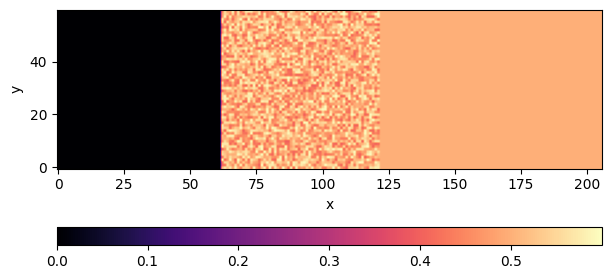

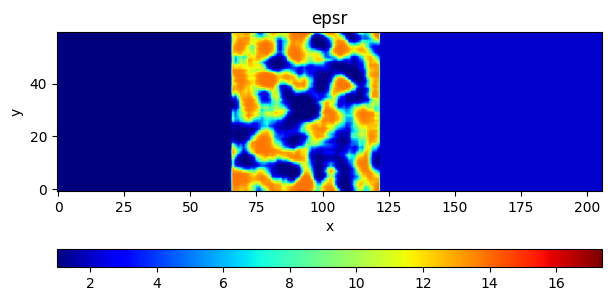

In [112]:
ceviche.viz.abs(rho, cbar=True)
viz_epsr(epsr)

In [113]:
def J(x, y, omega, v, sigma_x, d):
    '''Electric current density'''

    x *= dl
    y *= dl


    j = -Q_e / (4*pi * d) / np.sqrt(2*pi* sigma_x **2) * np.exp(-x**2/(2*sigma_x**2)) * np.exp(-1j * omega/v * y)
    
    return j

In [114]:
current_list = []

for omega in frequencies:
    current = np.zeros((Nx, Ny), dtype=np.complex128)
    for x in range(Nx):
        for y in range(Ny):
            current[x,y] = J(x - (Npml + xL_PML / dl), y, omega=omega, v=beta*C_0, sigma_x=sigma_x, d=0.5e-9)
    current_list.append(current)

<AxesSubplot:title={'center':'J_y'}, xlabel='x', ylabel='y'>

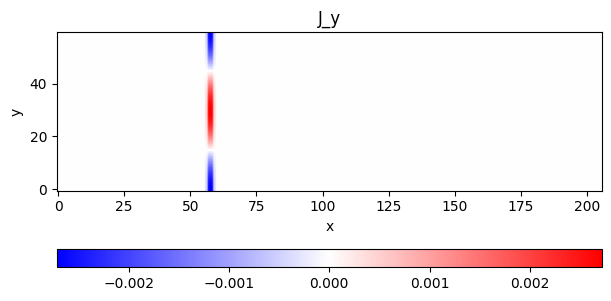

In [115]:
# ceviche.viz.abs(current, cbar=True)
ceviche.viz.real(current_list[0], DK_title='J_y', cbar=True, cmap='bwr')

In [116]:
# Create the simulation object for 'Hz' (TM) polarization
simulations_list = []

for omega in frequencies:
    simulation = ceviche.fdfd_hz(omega, dl, epsr, [Npml, 0], bloch_phases=[0, -(omega/(beta*C_0)*a)])
    simulations_list.append(simulation)

In [117]:
source_tmp_list = []

for current in current_list:
    source_tmp = np.zeros((Nx, Ny), dtype=np.complex128)
    source_tmp = np.reshape(simulation.Dxb.dot(current.flatten() / (-EPSILON_0 * 1j * omega)), (Nx, Ny))
    source_tmp[design_region == 1] = 0

    source_tmp_list.append(source_tmp)

In [118]:
# Run the simulation with the given source
Ex_list = []
Ey_list = []
Hz_list = []

for source_tmp, simulation in zip(source_tmp_list, simulations_list):
    Ex, Ey, Hz = simulation.solve(source_tmp)

    Ex_list.append(Ex)
    Ey_list.append(Ey)
    Hz_list.append(Hz)

for i in range(len(Ey_list)):
    for current, omega in zip(current_list, frequencies):
        Ey_list[i] = Ey_list[i] - current / (EPSILON_0 * 1j * omega)

<AxesSubplot:title={'center':'Hz'}, xlabel='x', ylabel='y'>

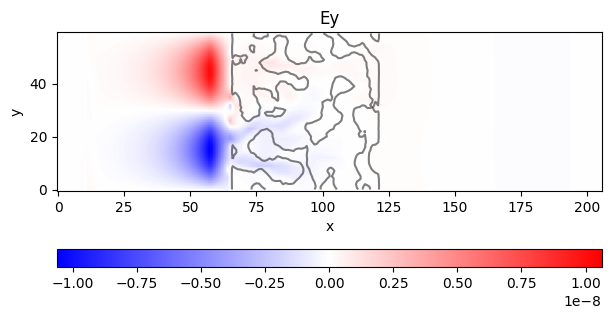

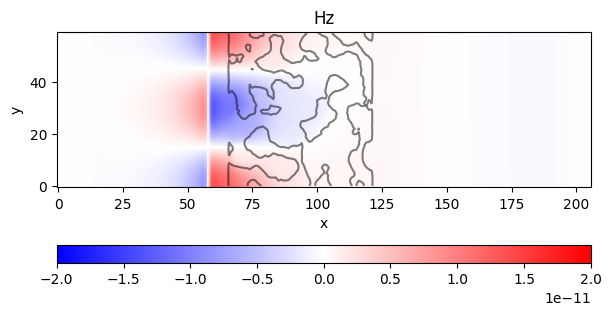

In [119]:
# Visualize the real value of the _ field component
ceviche.viz.real(Ey_list[0], DK_title='Ey', outline=epsr, cbar=True, cmap='bwr')
ceviche.viz.real(Hz_list[0], DK_title='Hz', DK_max=2e-11, outline=epsr, cbar=True, cmap='bwr')

### Poynting vector

In [120]:
Sx_list = []
Sy_list = []

for Ey, Hz in zip(Ey_list, Hz_list):
    Sx =  4*2*pi * real( 1/2 * Ey * conj(Hz))
    Sx_list.append(Sx)

for Ex, Hz in zip(Ex_list, Hz_list):
    Sy =  4*2*pi * real(-1/2 * Ex * conj(Hz))
    Sy_list.append(Sy)

In [121]:
# detector position
det_x = int(Nx * 0.9) - Npml
print(f'detector position: X = {det_x}')


# the energy flux through the detector
def energy_flux(Sx, det_x):
    return npa.sum(Sx[det_x, :]*dl)

# long_det_left = x1+int(h/dl)
# def longitudinal_energy_flux(Sy):
#     return npa.sum(Sy[long_det_left:Nx, Ny-1]*dl)

detector position: X = 165


In [122]:
norm = npa.sum([energy_flux(Sx, det_x) for Sx in Sx_list])
norm_min = npa.min([energy_flux(Sx, det_x) for Sx in Sx_list])

# optimal energy flux for F=0.9, h=240 for 5 frequencies
rect_optimum = 5.405662617829e-25


print(norm)
print(norm_min)
print(norm/rect_optimum)

2.277353216066179e-28
2.277353216066179e-28
0.00042129029816899676


### Objective function

In [123]:
# optimize the average energy flux
def objective_average(rho):
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(
        rho, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)

    energy_flux_list = []

    for i, simulation in enumerate(simulations_list):
        simulation.eps_r = epsr
        _, Ey, Hz = simulation.solve(source_tmp_list[i])
        Ey = Ey - current_list[i] / (EPSILON_0 * 1j * frequencies[i])
        Sx = 4*2*pi * real(1/2 * Ey * conj(Hz))
        energy_flux_list.append(energy_flux(Sx, det_x))
        
        # m=1 only
        # energy_flux_list.append(npa.abs(mode(1, int(x2+80e-9/dl), frequencies[i], Hz, nSi)) **2)

    return  npa.sum(energy_flux_list) / rect_optimum

In [124]:
# optimize the minimum energy flux
def objective_min(rho):
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(
        rho, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)

    energy_flux_list = []

    for i, simulation in enumerate(simulations_list):
        simulation.eps_r = epsr
        _, Ey, Hz = simulation.solve(source_tmp_list[i])
        Ey = Ey - current_list[i] / (EPSILON_0 * 1j * frequencies[i])
        Sx = 4*2*pi * real(1/2 * Ey * conj(Hz))
        energy_flux_list.append(energy_flux(Sx, det_x))
        
        # m=1 only
        # energy_flux_list.append(npa.abs(mode(1, int(x2+80e-9/dl), frequencies[i], Hz, nSi)) **2)

    return  npa.min(energy_flux_list) / rect_optimum 


In [125]:
def objective(rho):
    # return objective_min(rho)
    return objective_average(rho)

### Optimization

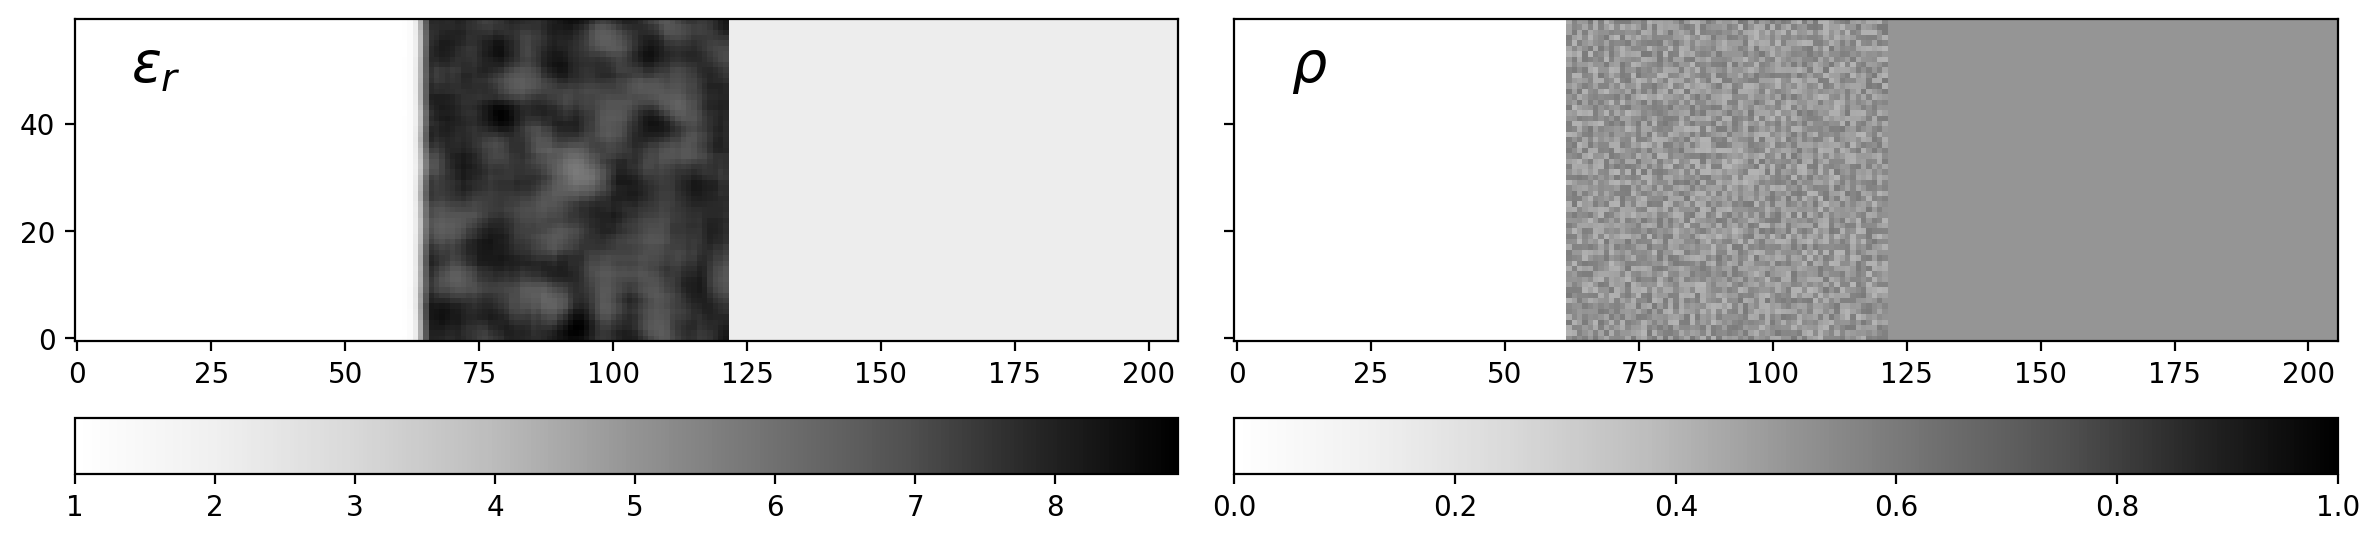

Epoch:   1/100 | Duration: 2.60 secs | Value: 2.529774e-06


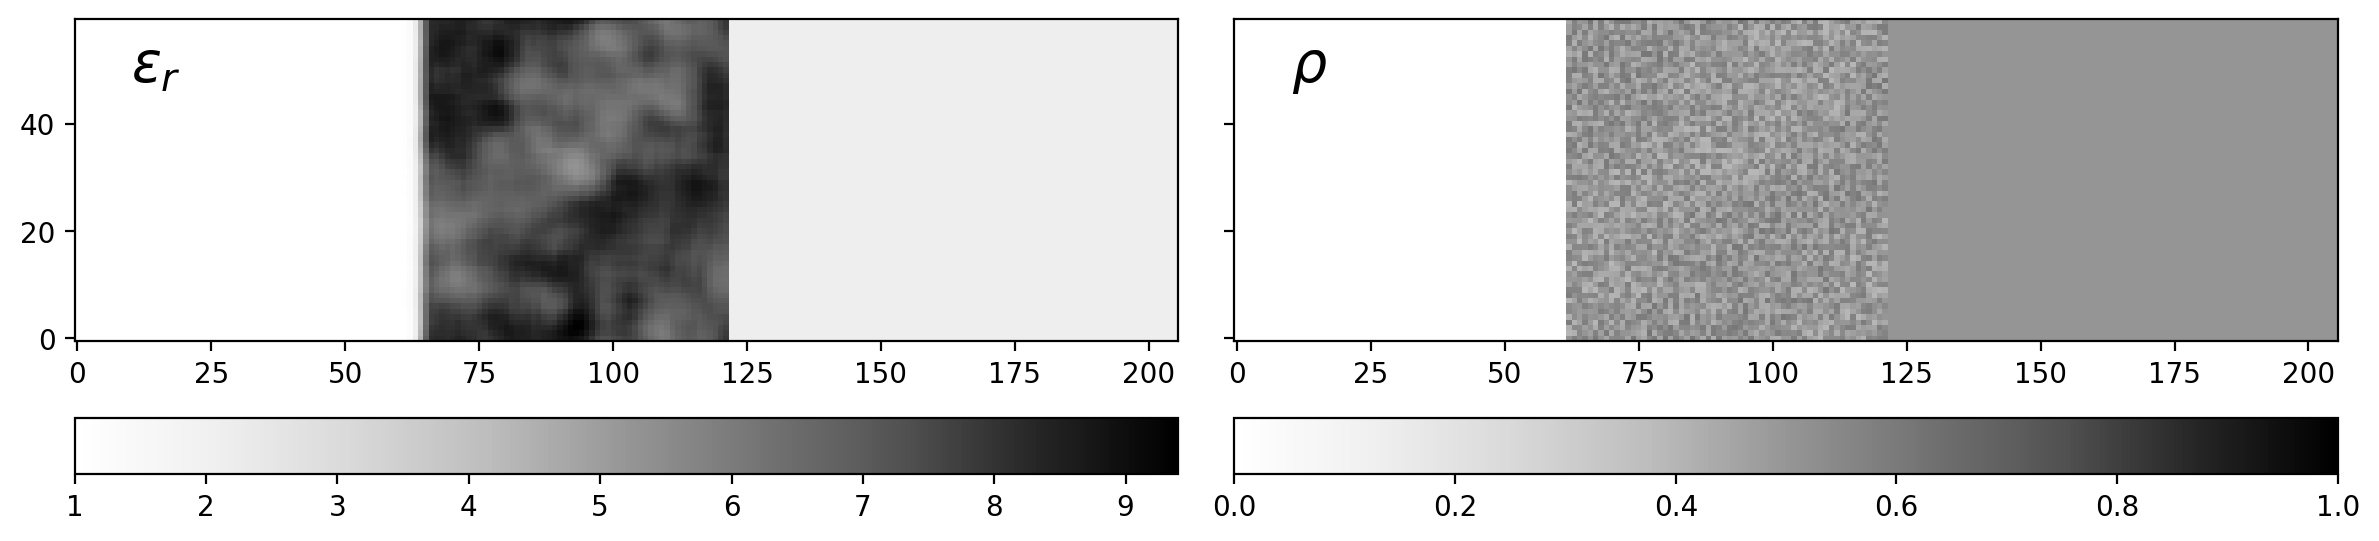

Epoch:   2/100 | Duration: 2.52 secs | Value: 1.441874e-04


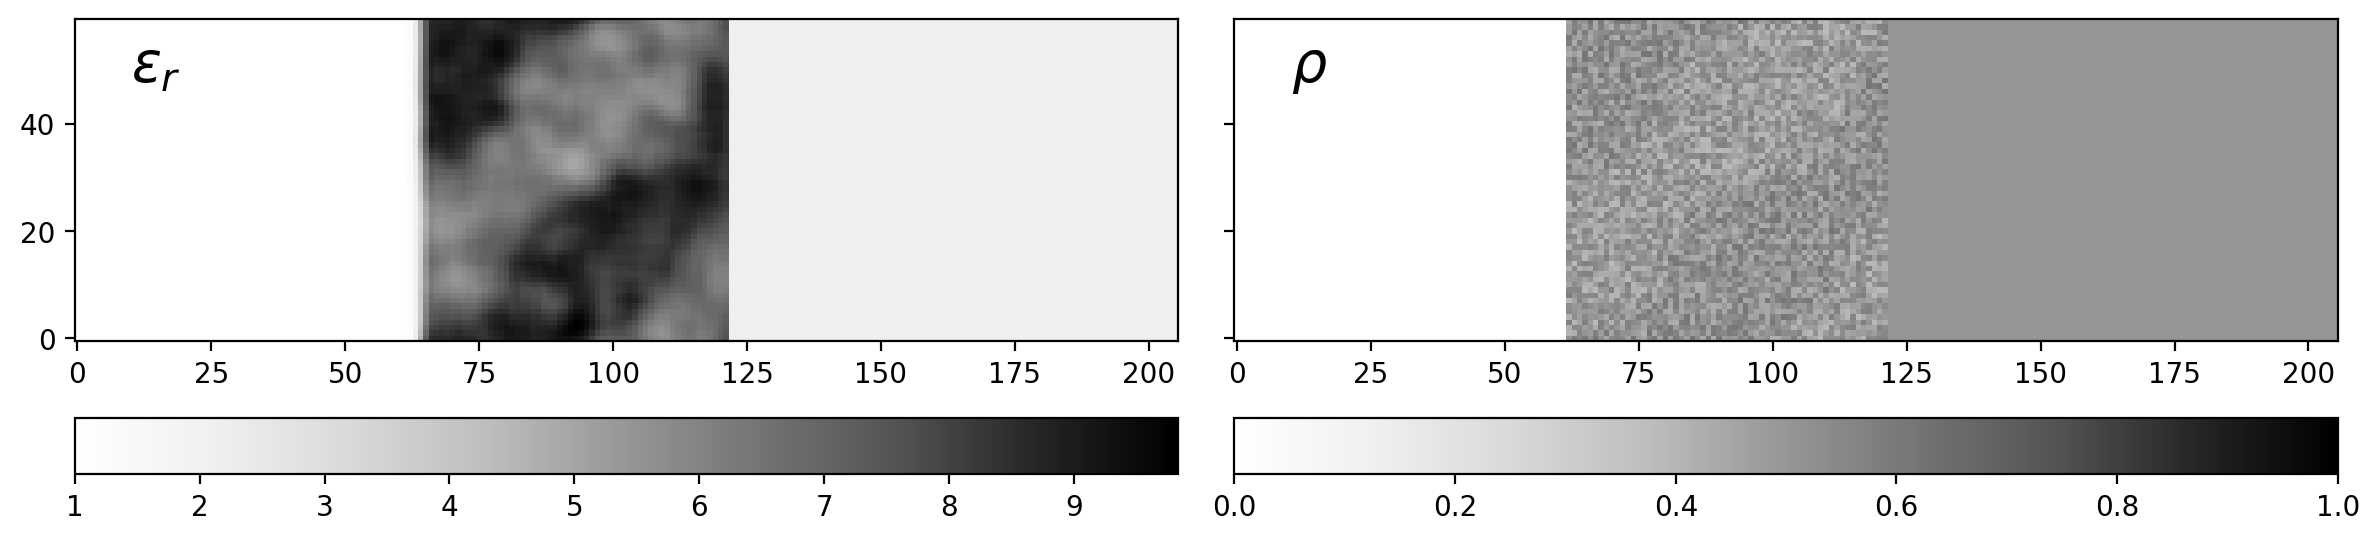

Epoch:   3/100 | Duration: 2.30 secs | Value: 4.281717e-04


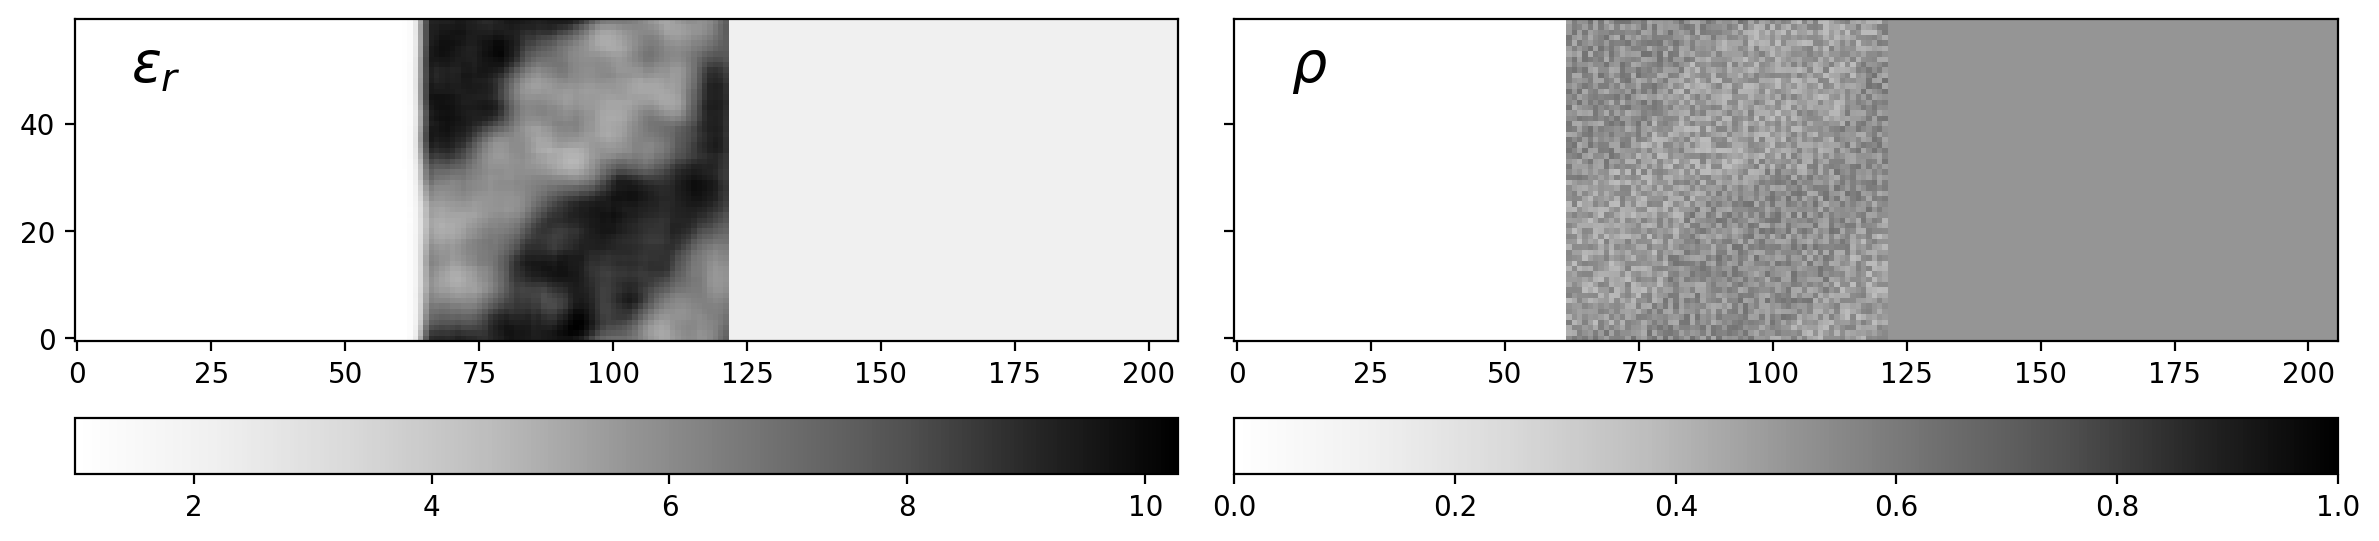

Epoch:   4/100 | Duration: 2.34 secs | Value: 8.942955e-04


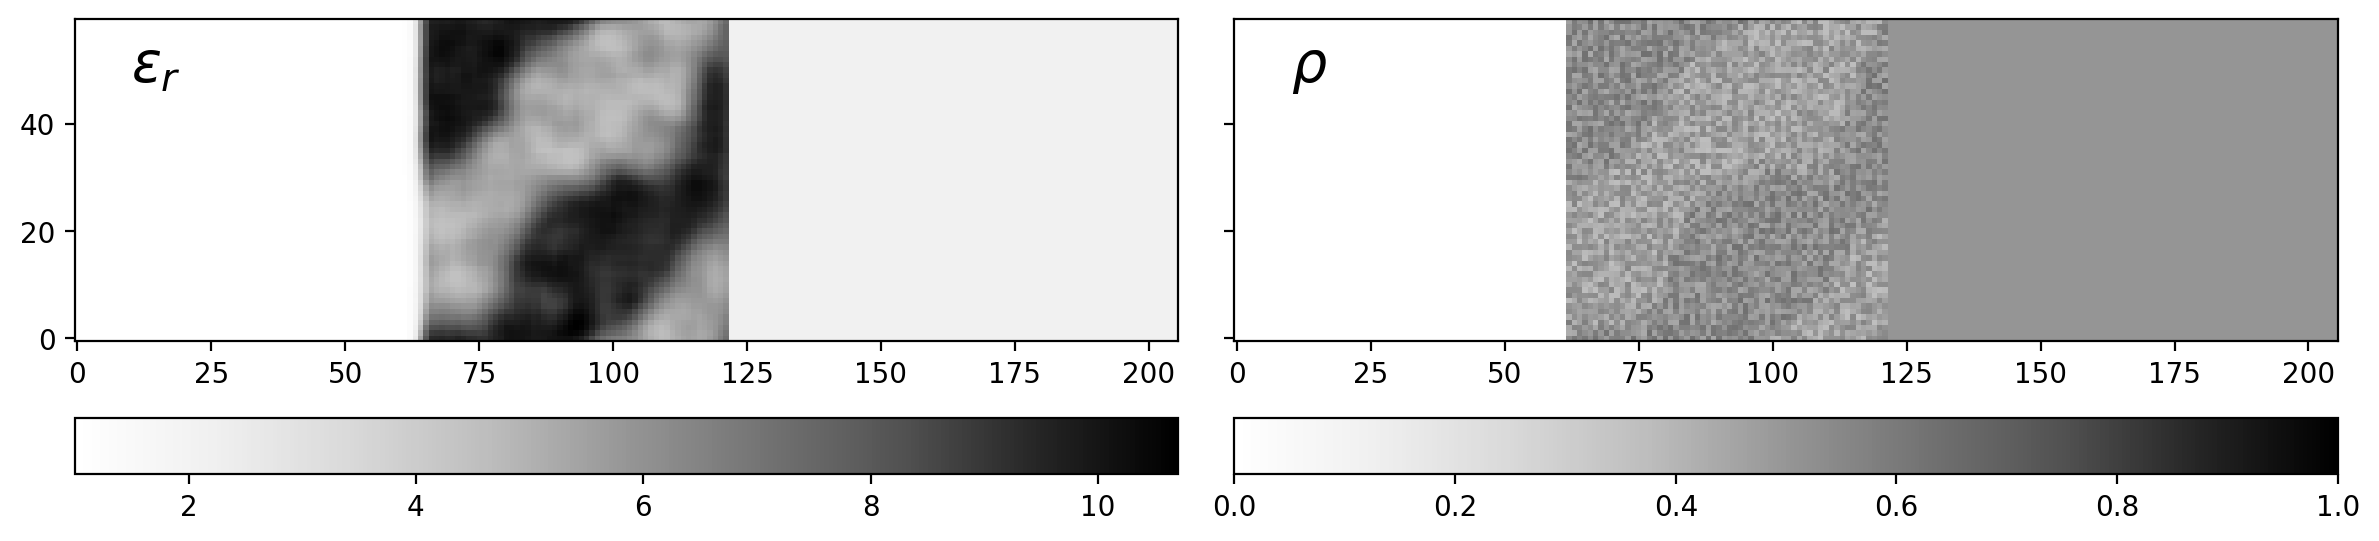

Epoch:   5/100 | Duration: 2.78 secs | Value: 1.554835e-03


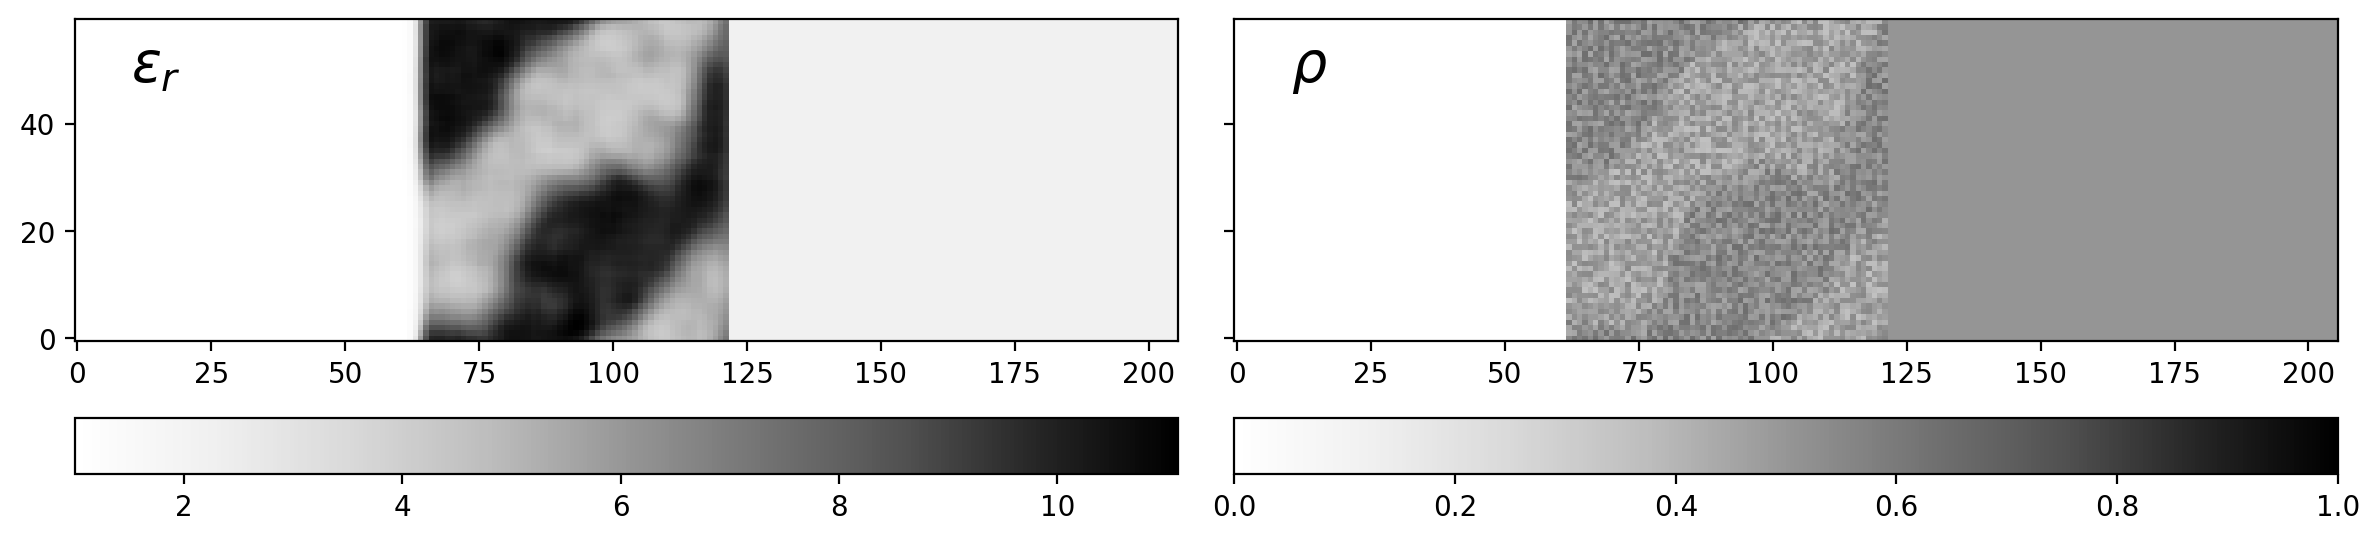

Epoch:   6/100 | Duration: 2.26 secs | Value: 2.420446e-03


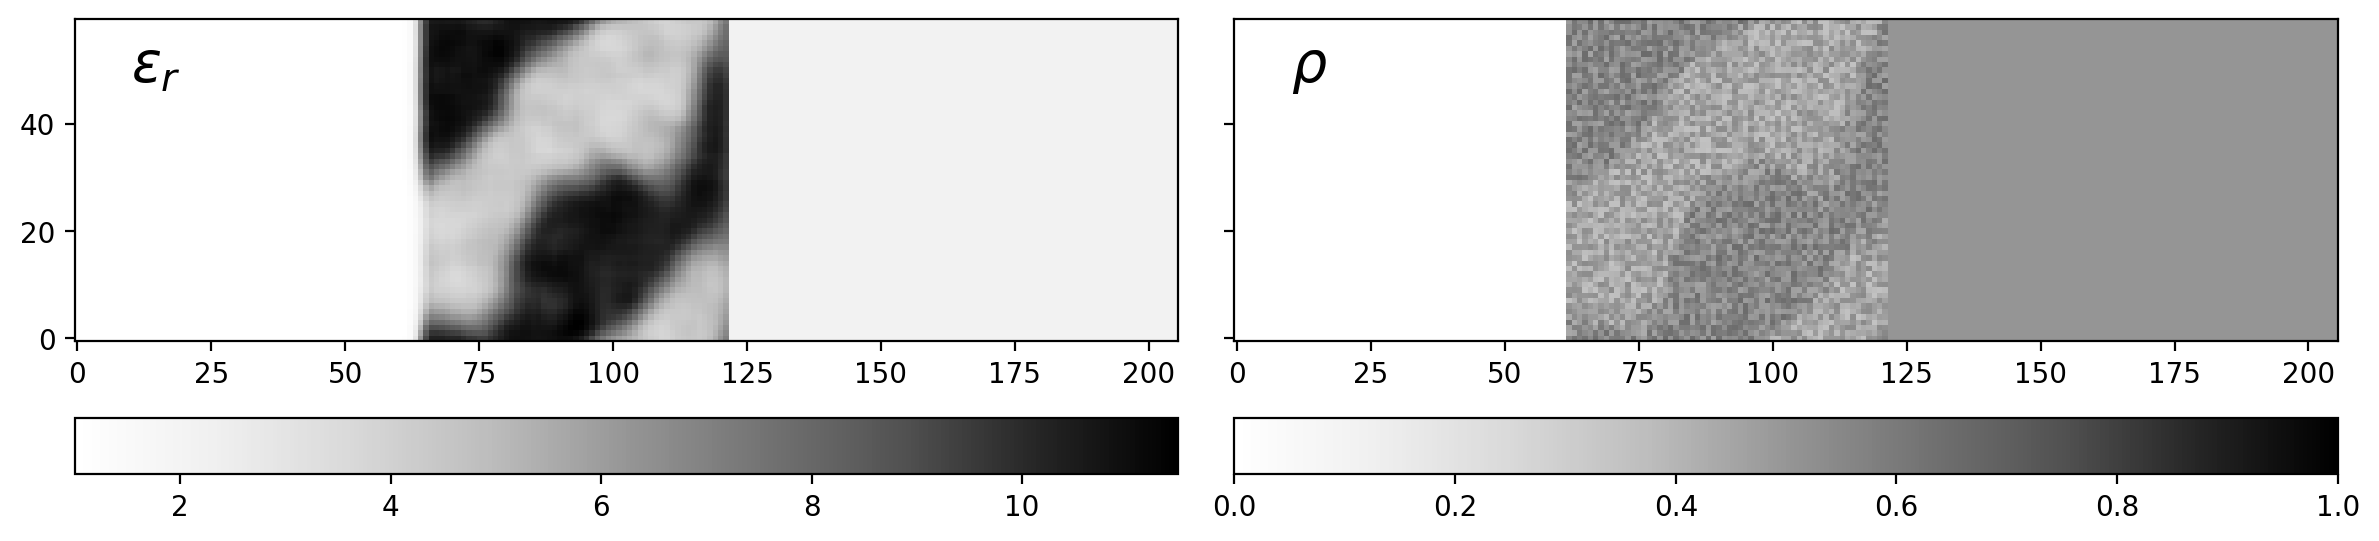

Epoch:   7/100 | Duration: 2.51 secs | Value: 3.499353e-03


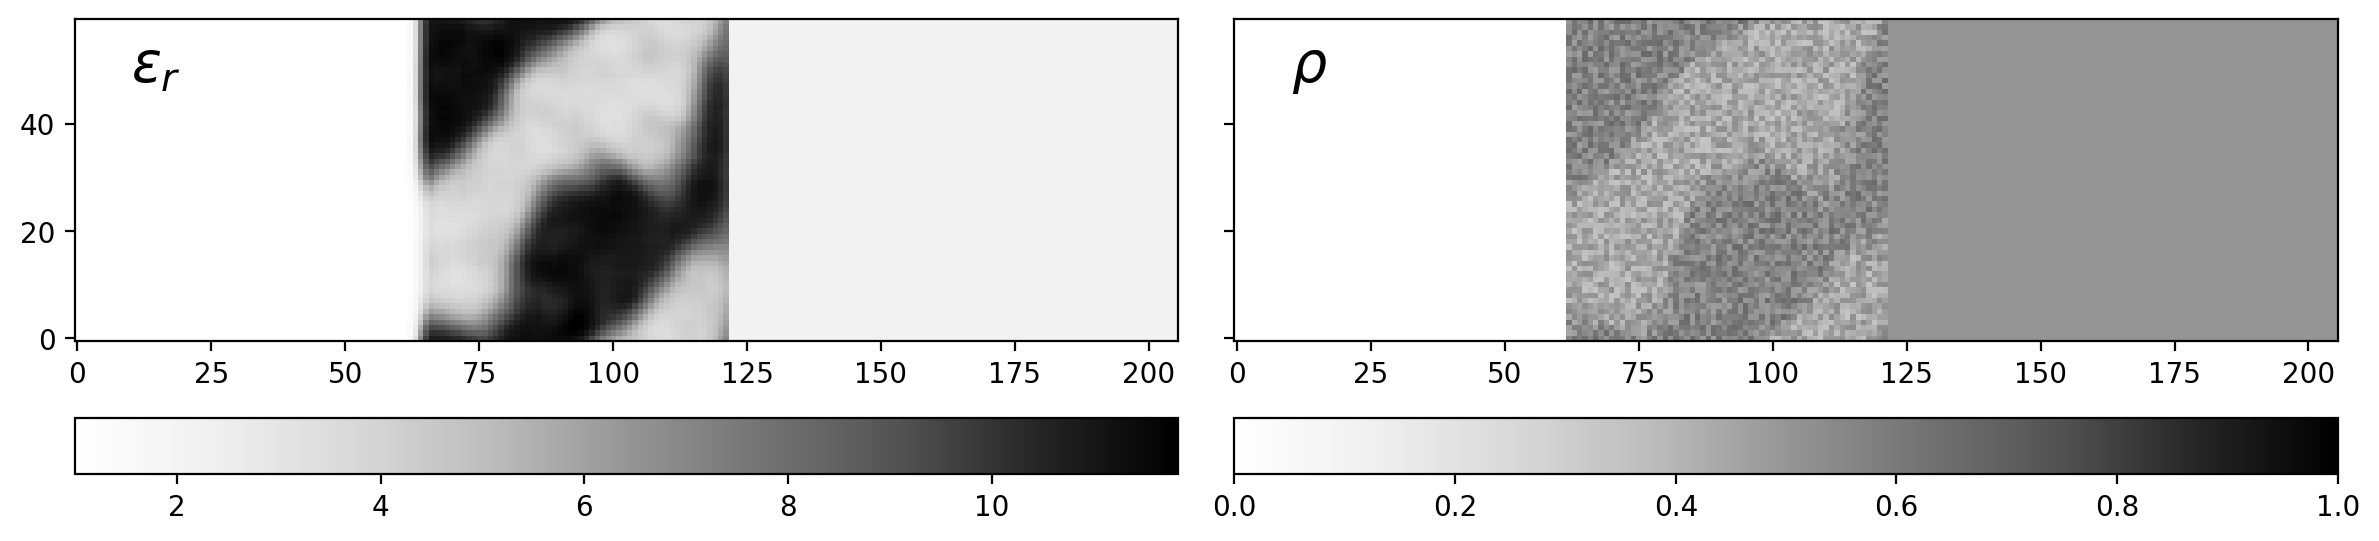

Epoch:   8/100 | Duration: 2.43 secs | Value: 4.796785e-03


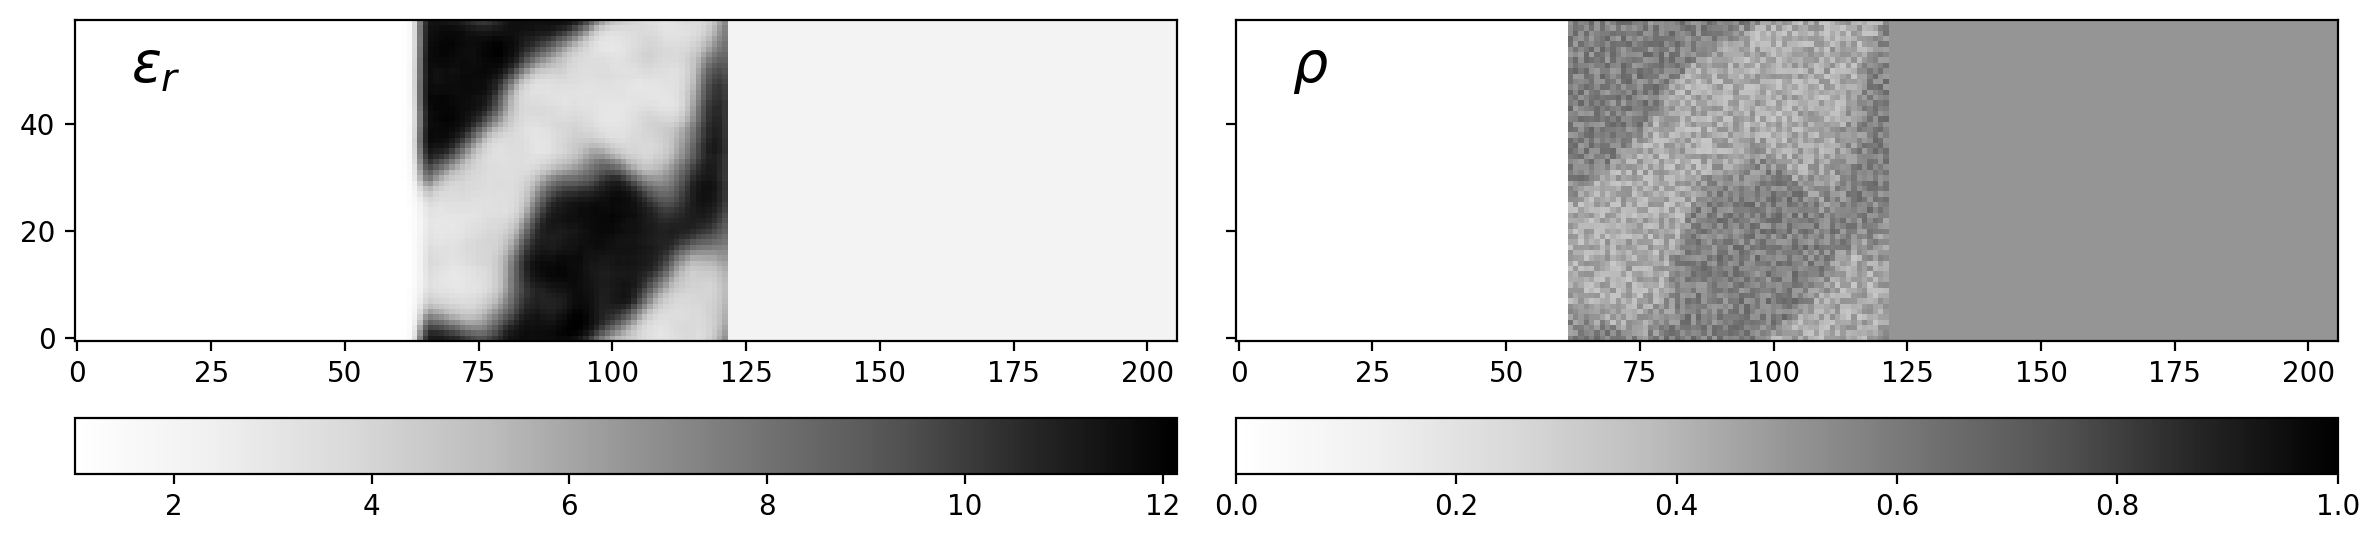

Epoch:   9/100 | Duration: 2.40 secs | Value: 6.315787e-03


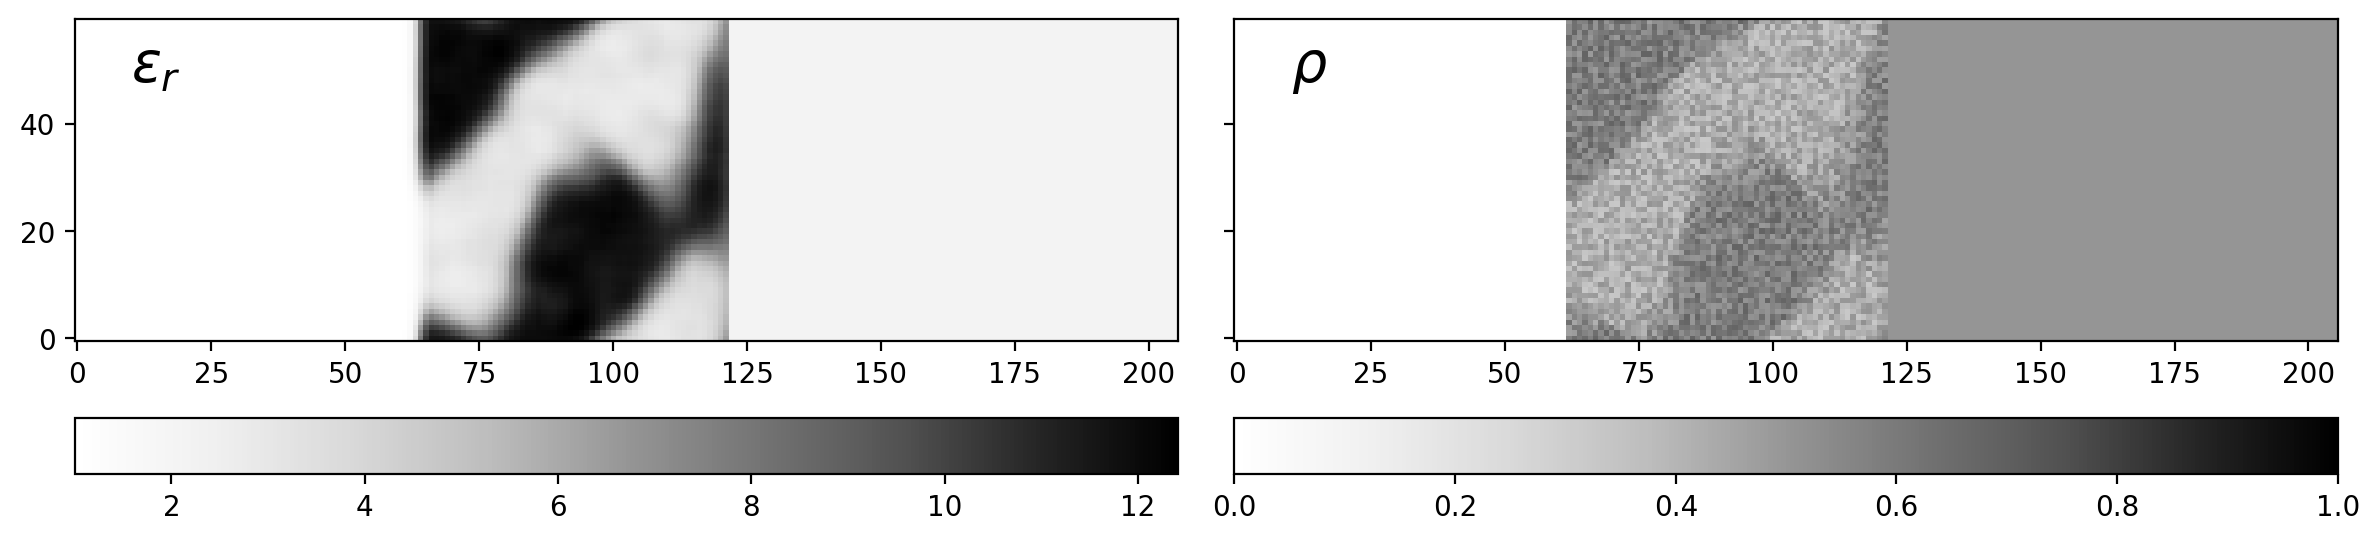

Epoch:  10/100 | Duration: 2.26 secs | Value: 8.056204e-03


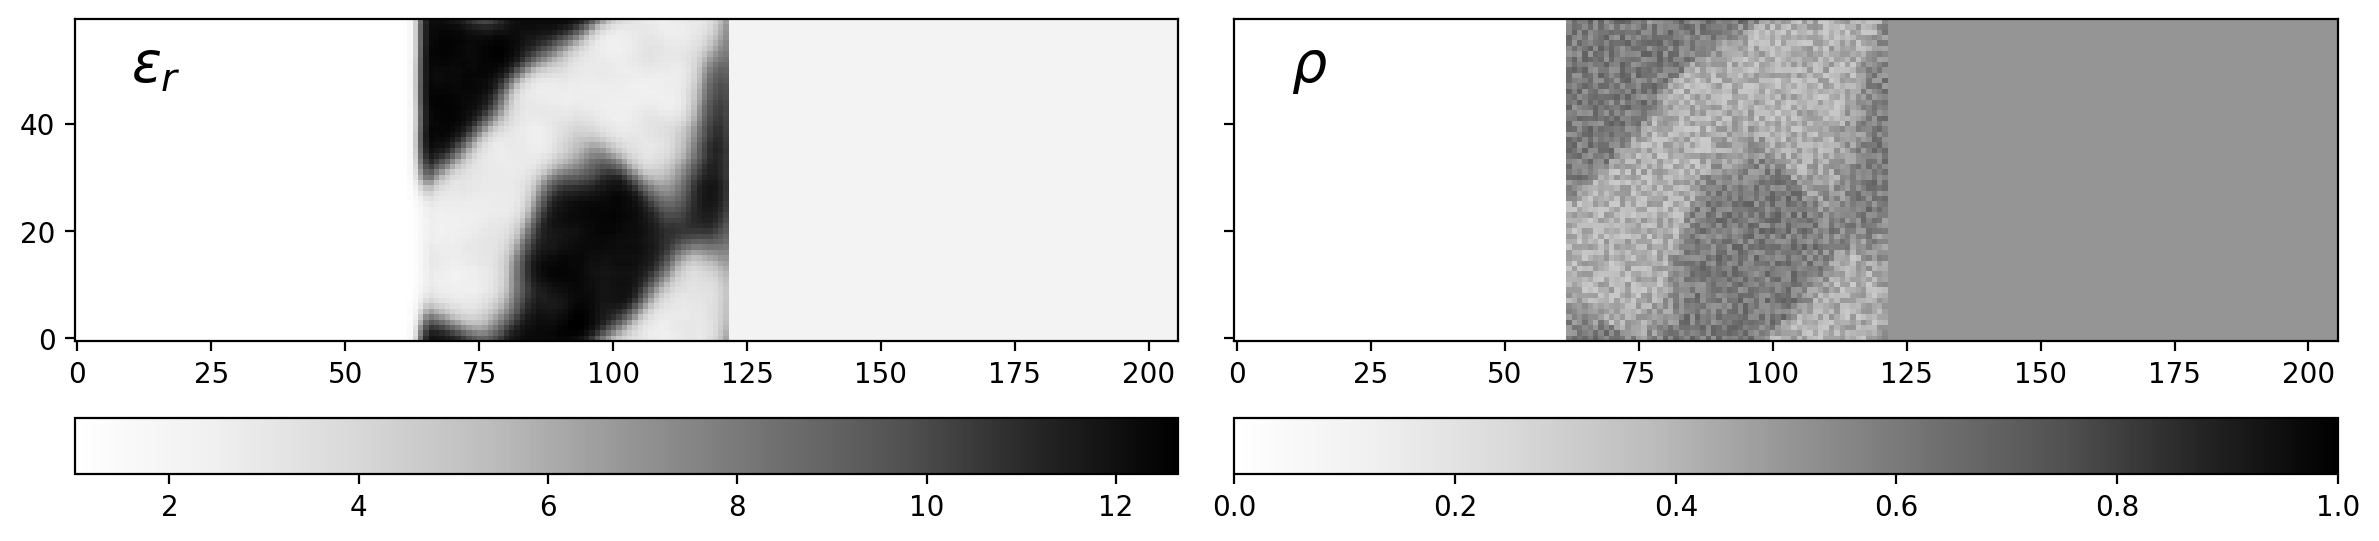

Epoch:  11/100 | Duration: 2.16 secs | Value: 1.001341e-02


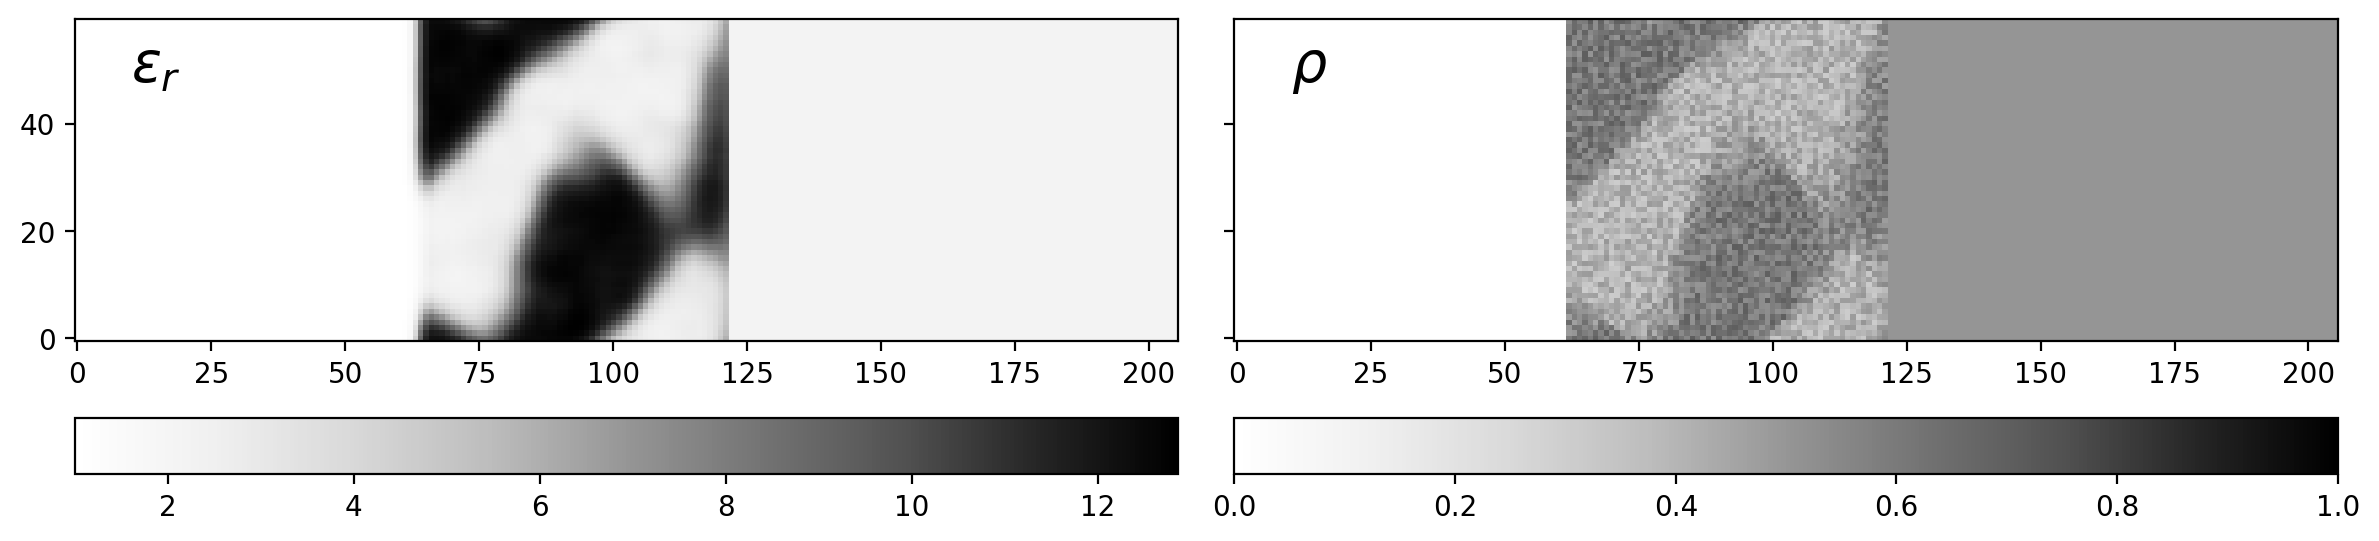

Epoch:  12/100 | Duration: 2.42 secs | Value: 1.217486e-02


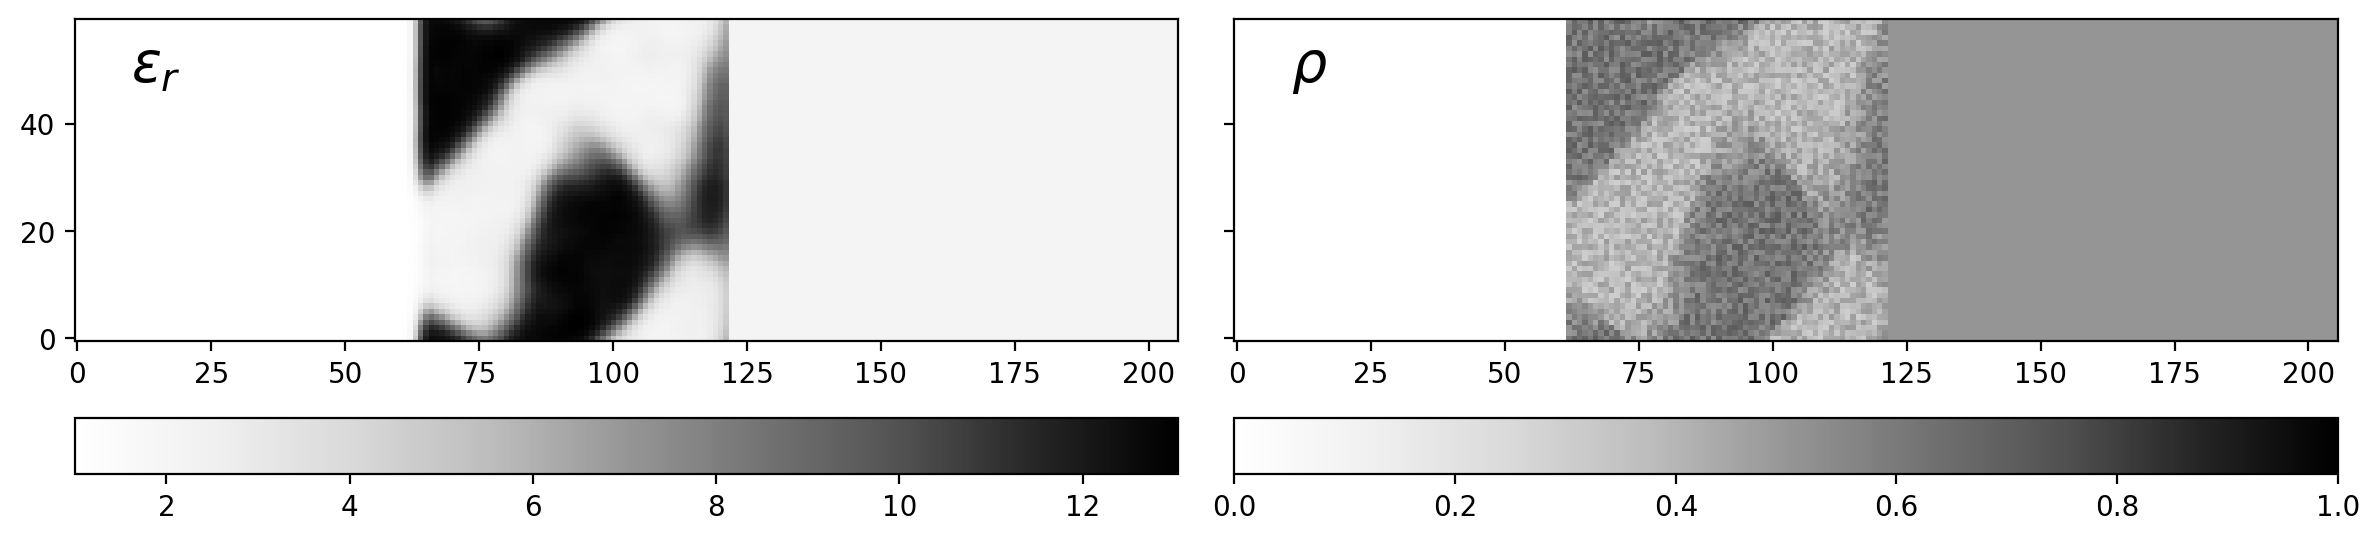

Epoch:  13/100 | Duration: 2.48 secs | Value: 1.451391e-02


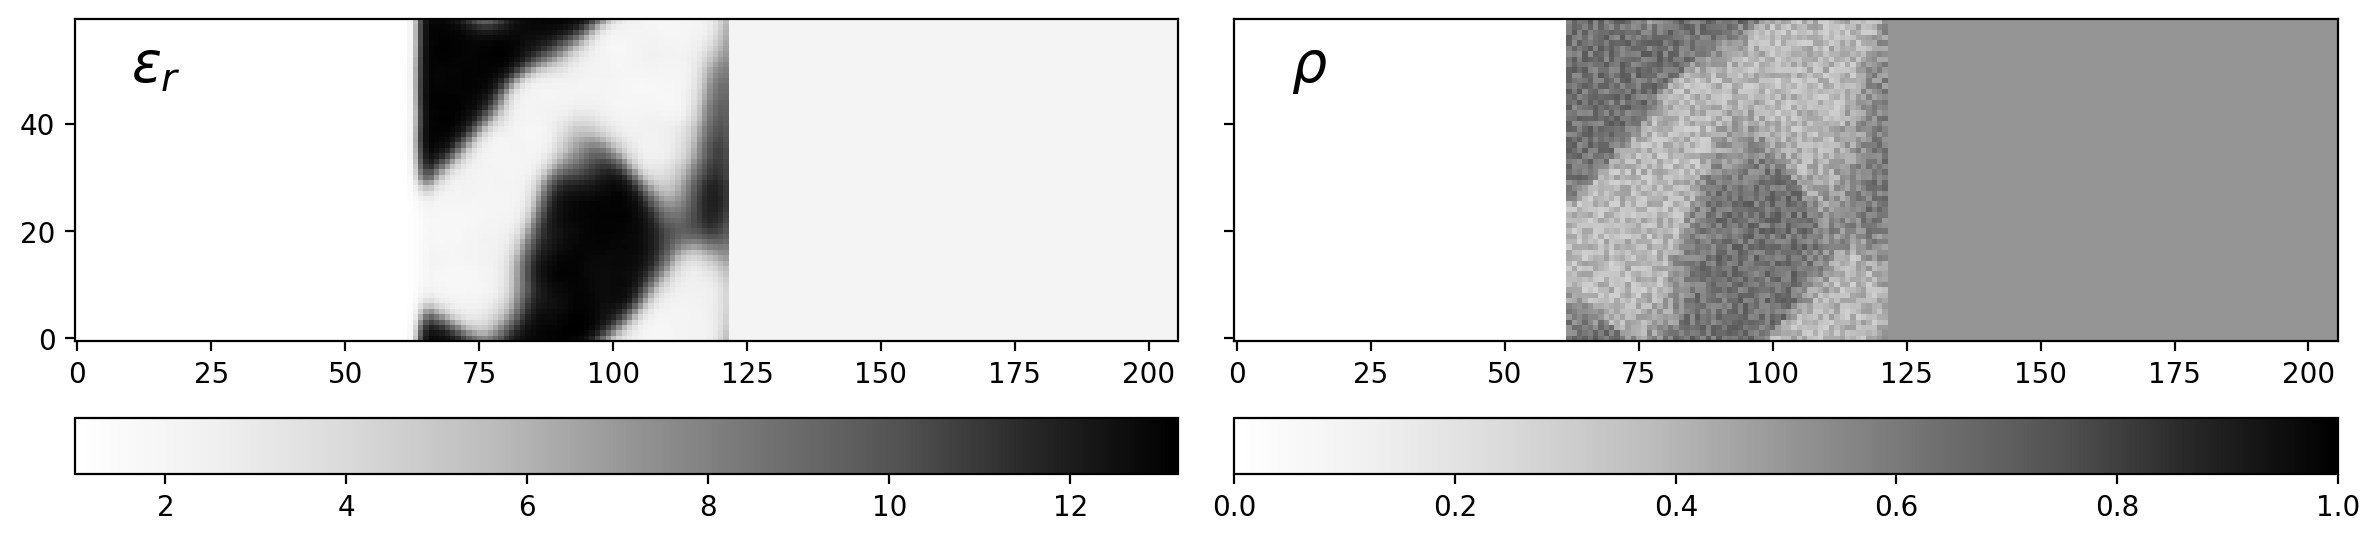

Epoch:  14/100 | Duration: 2.43 secs | Value: 1.698311e-02


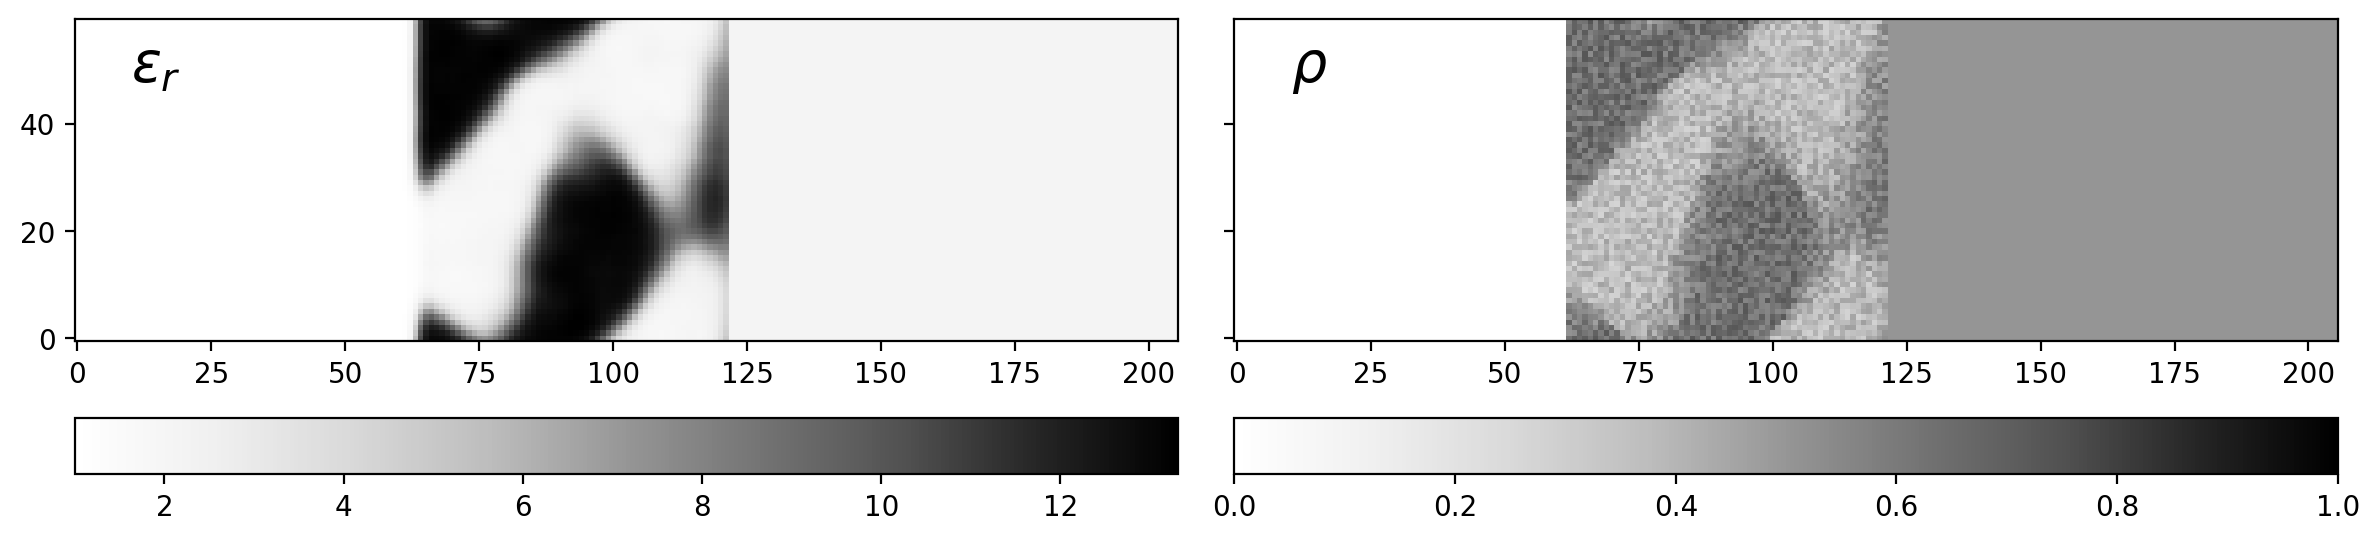

Epoch:  15/100 | Duration: 2.34 secs | Value: 1.951181e-02


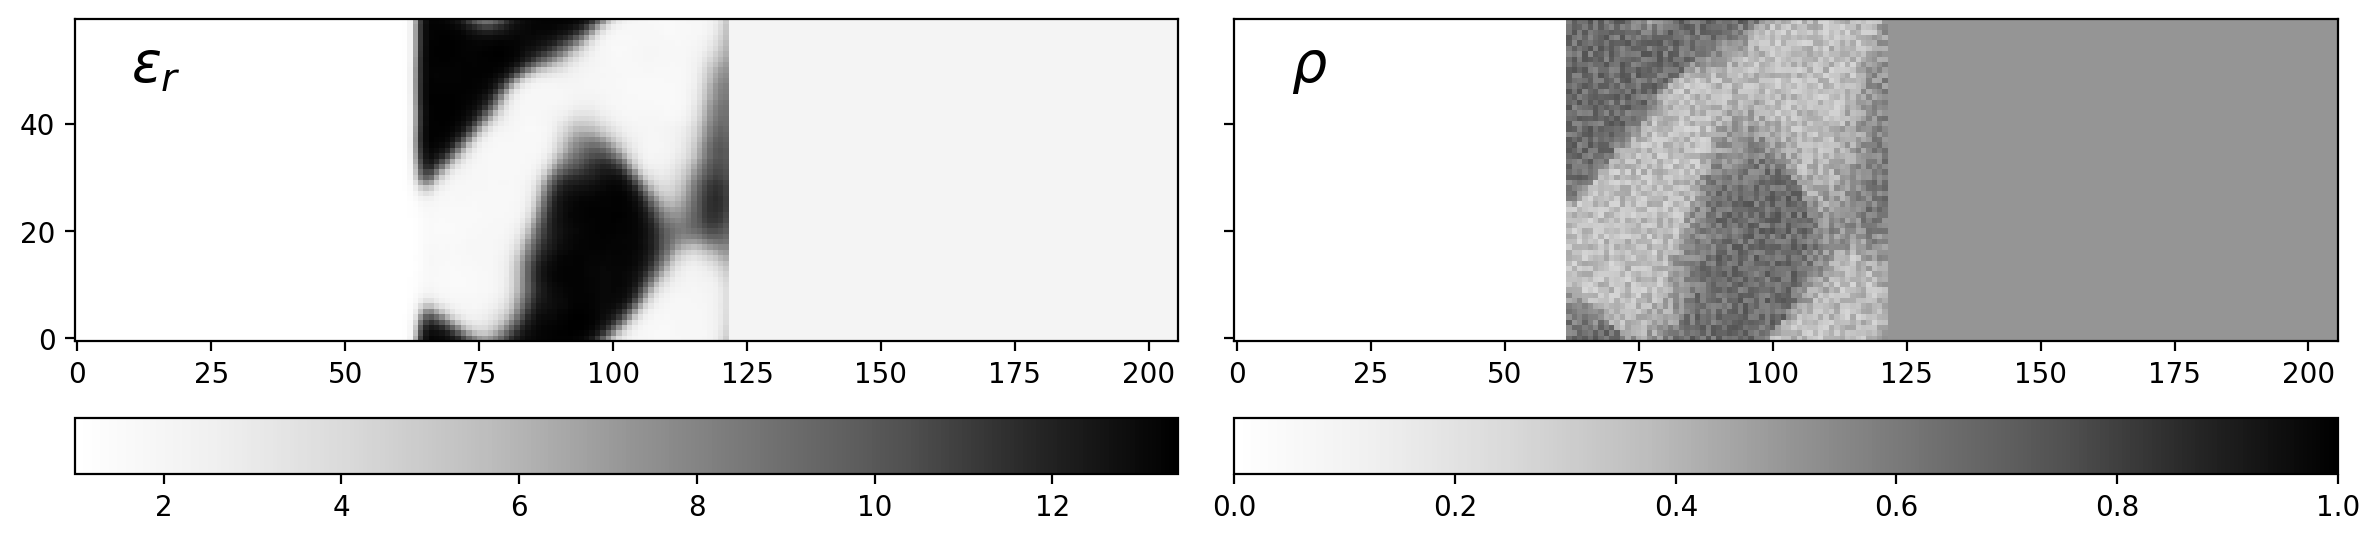

Epoch:  16/100 | Duration: 2.45 secs | Value: 2.201200e-02


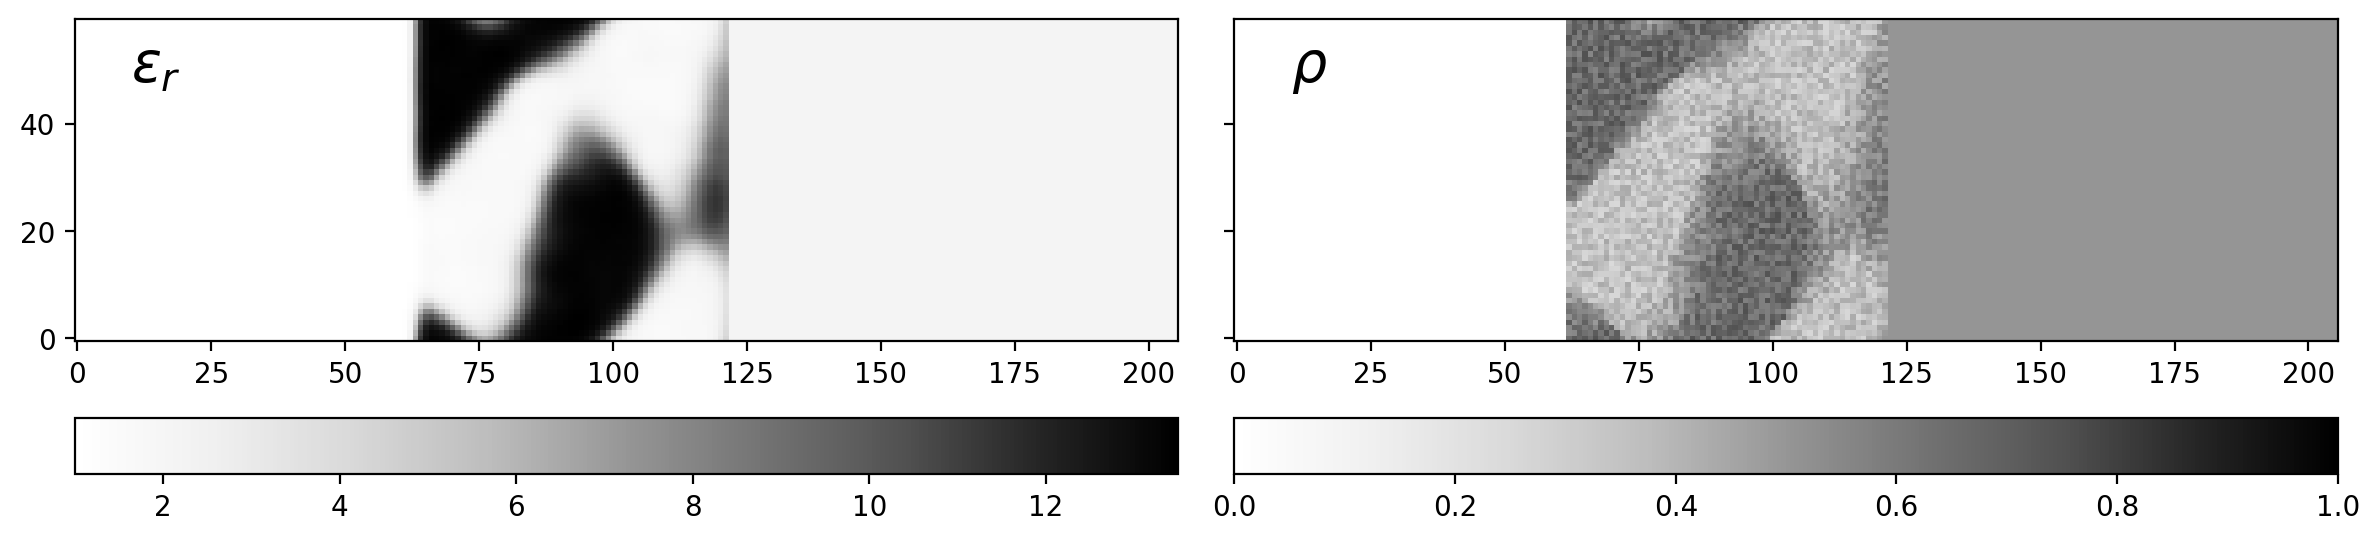

Epoch:  17/100 | Duration: 2.44 secs | Value: 2.439368e-02


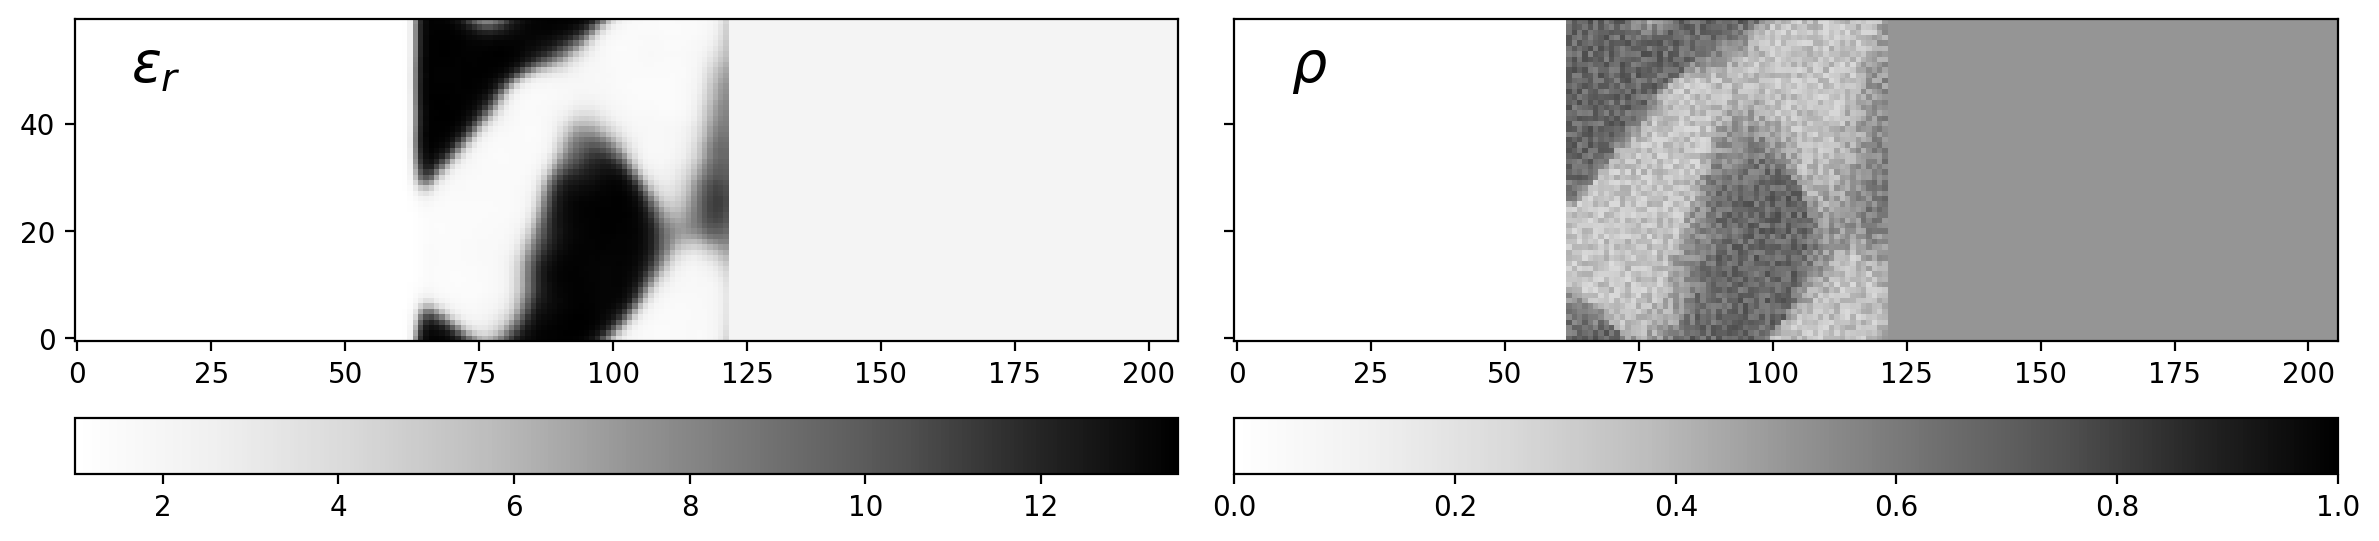

Epoch:  18/100 | Duration: 2.42 secs | Value: 2.658679e-02


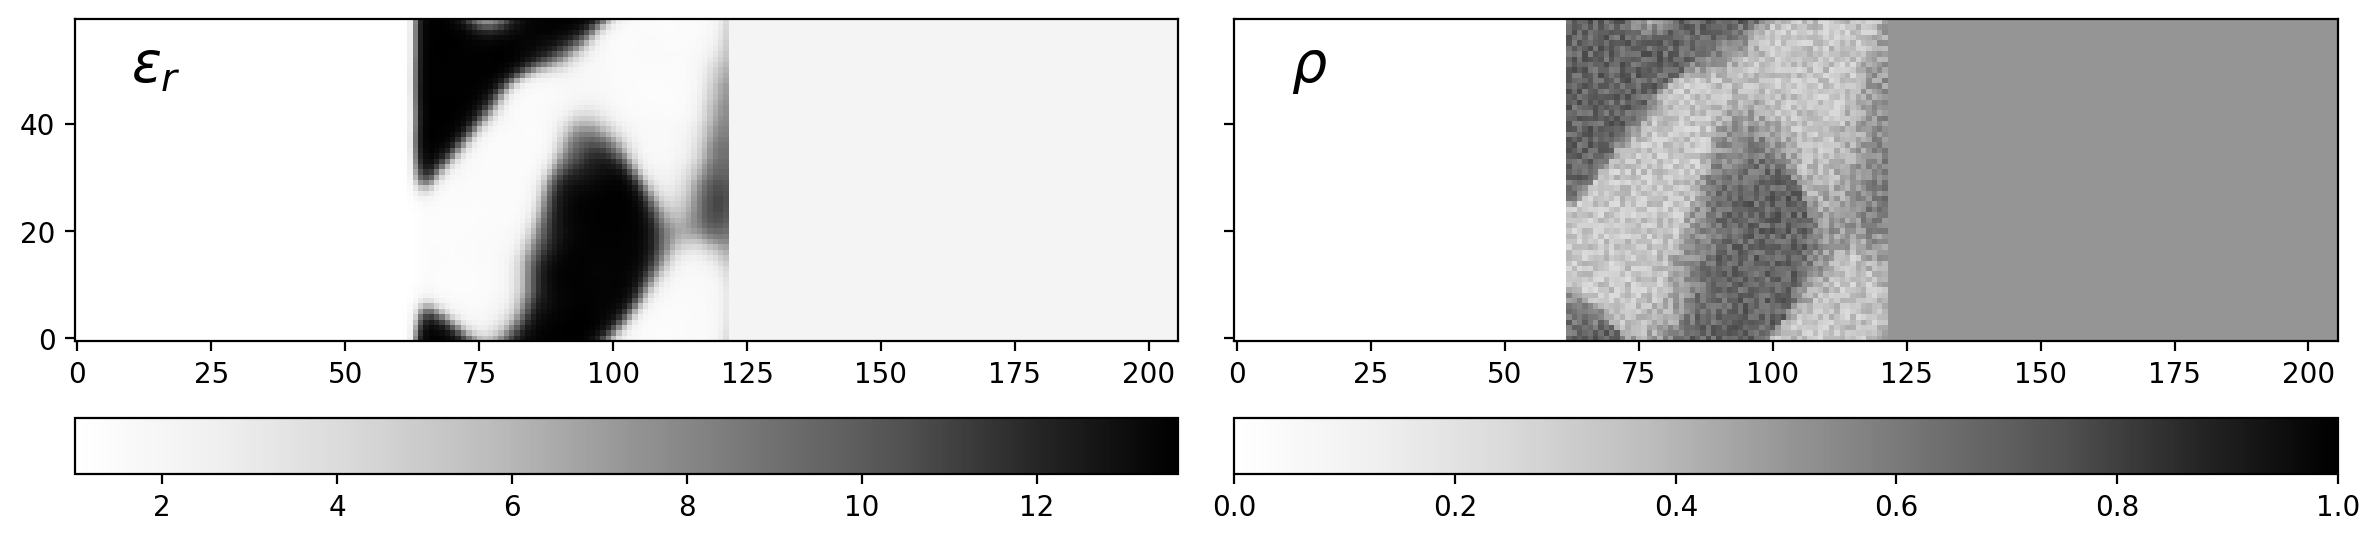

Epoch:  19/100 | Duration: 2.19 secs | Value: 2.855852e-02


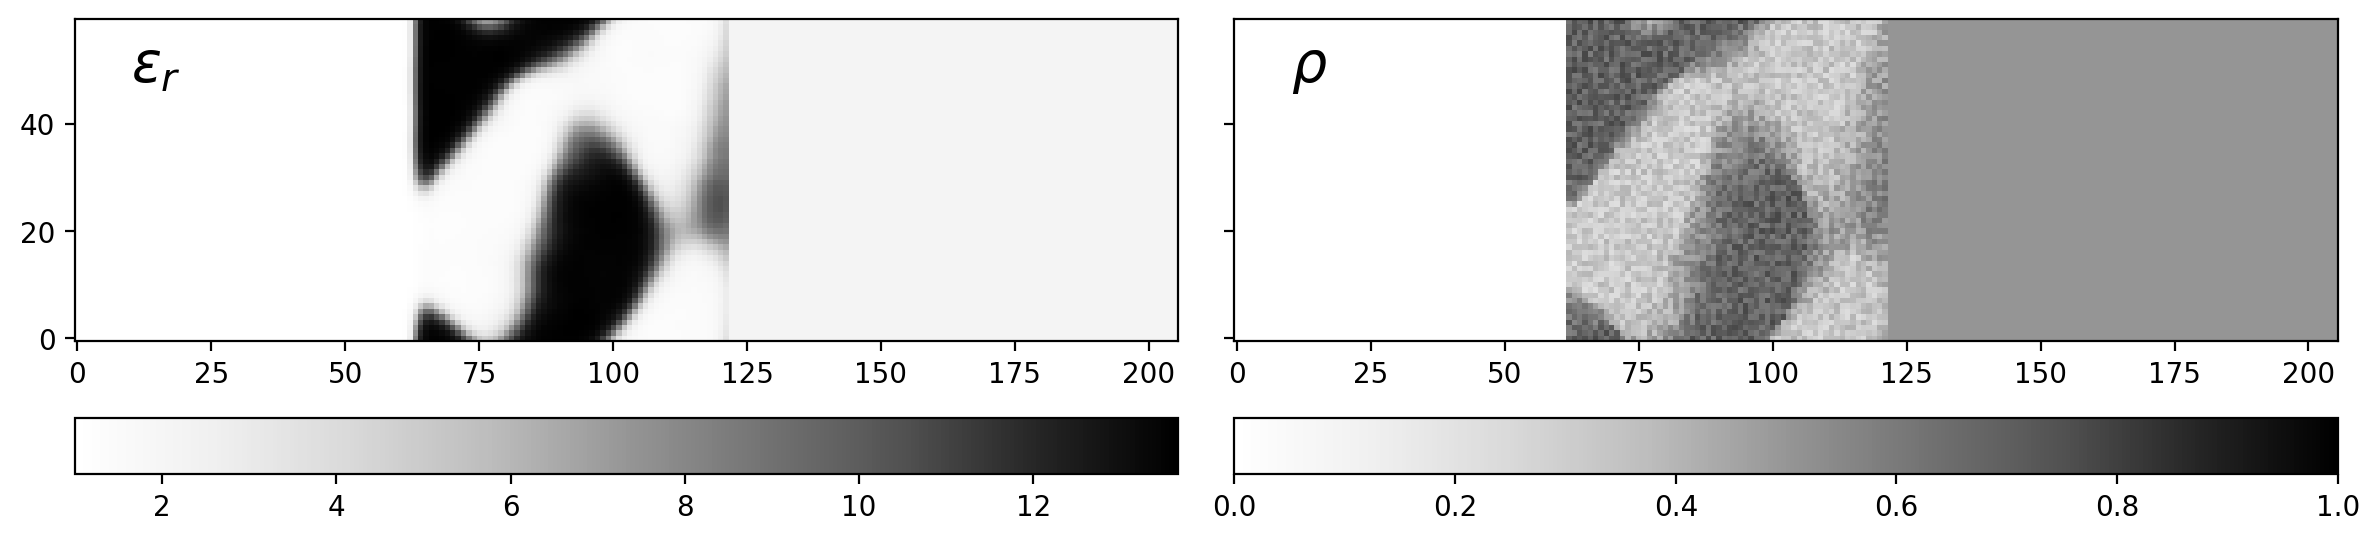

Epoch:  20/100 | Duration: 2.35 secs | Value: 3.031272e-02


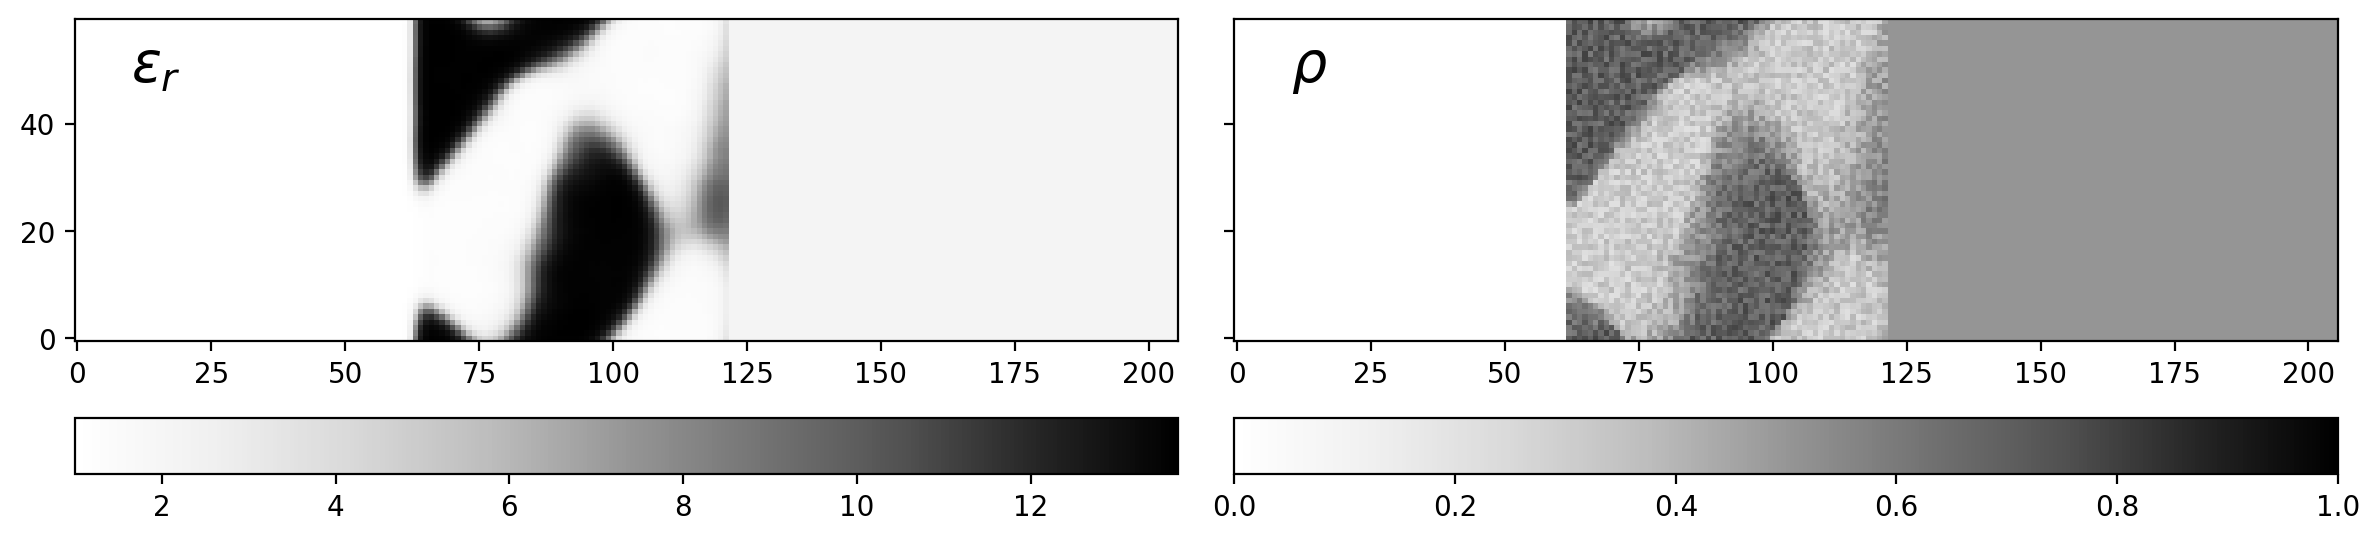

Epoch:  21/100 | Duration: 2.14 secs | Value: 3.187562e-02


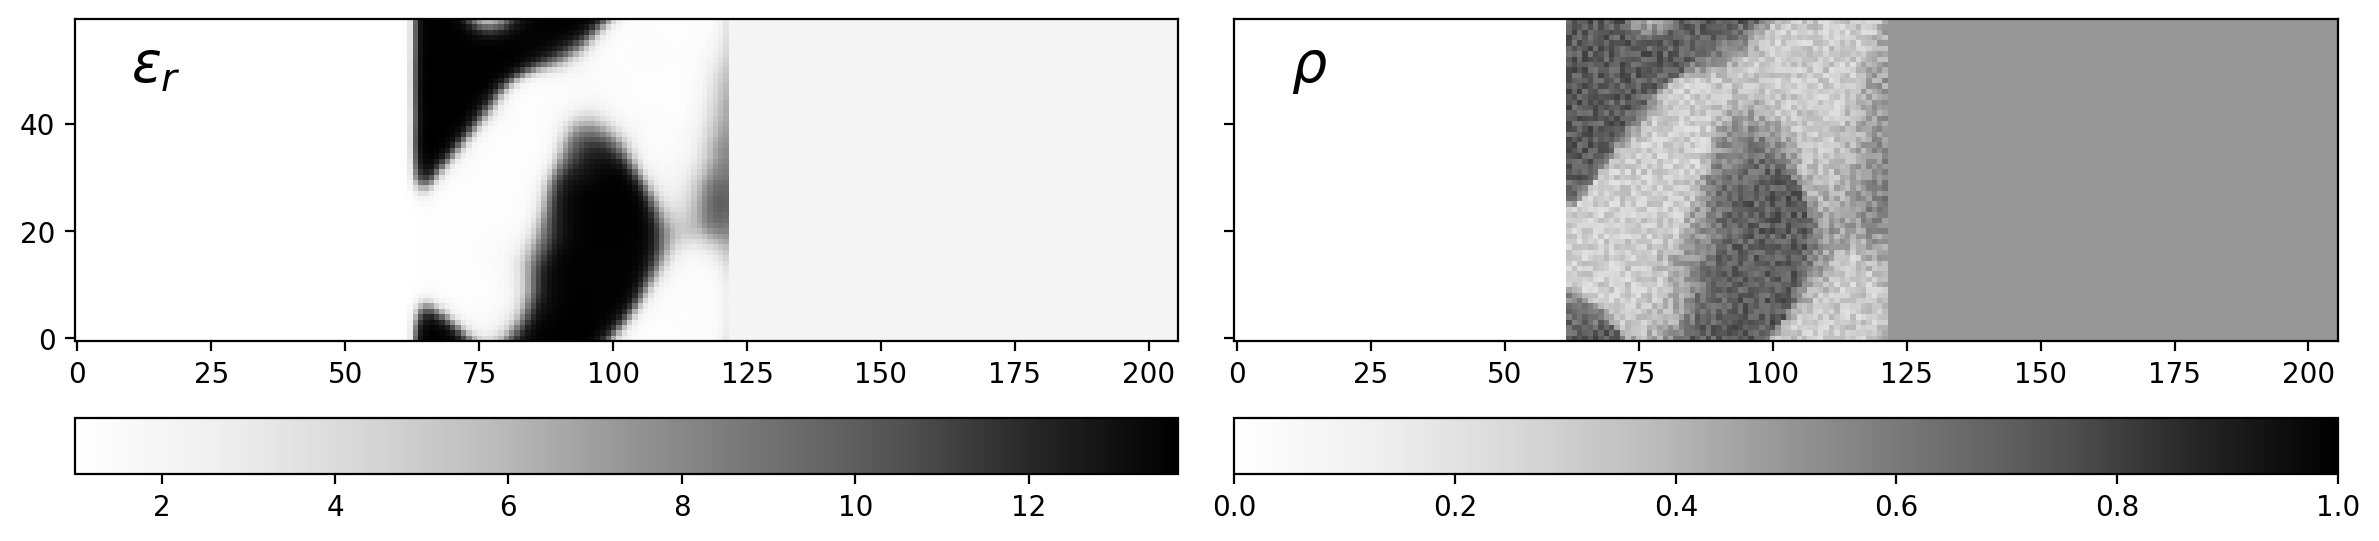

Epoch:  22/100 | Duration: 2.31 secs | Value: 3.328134e-02


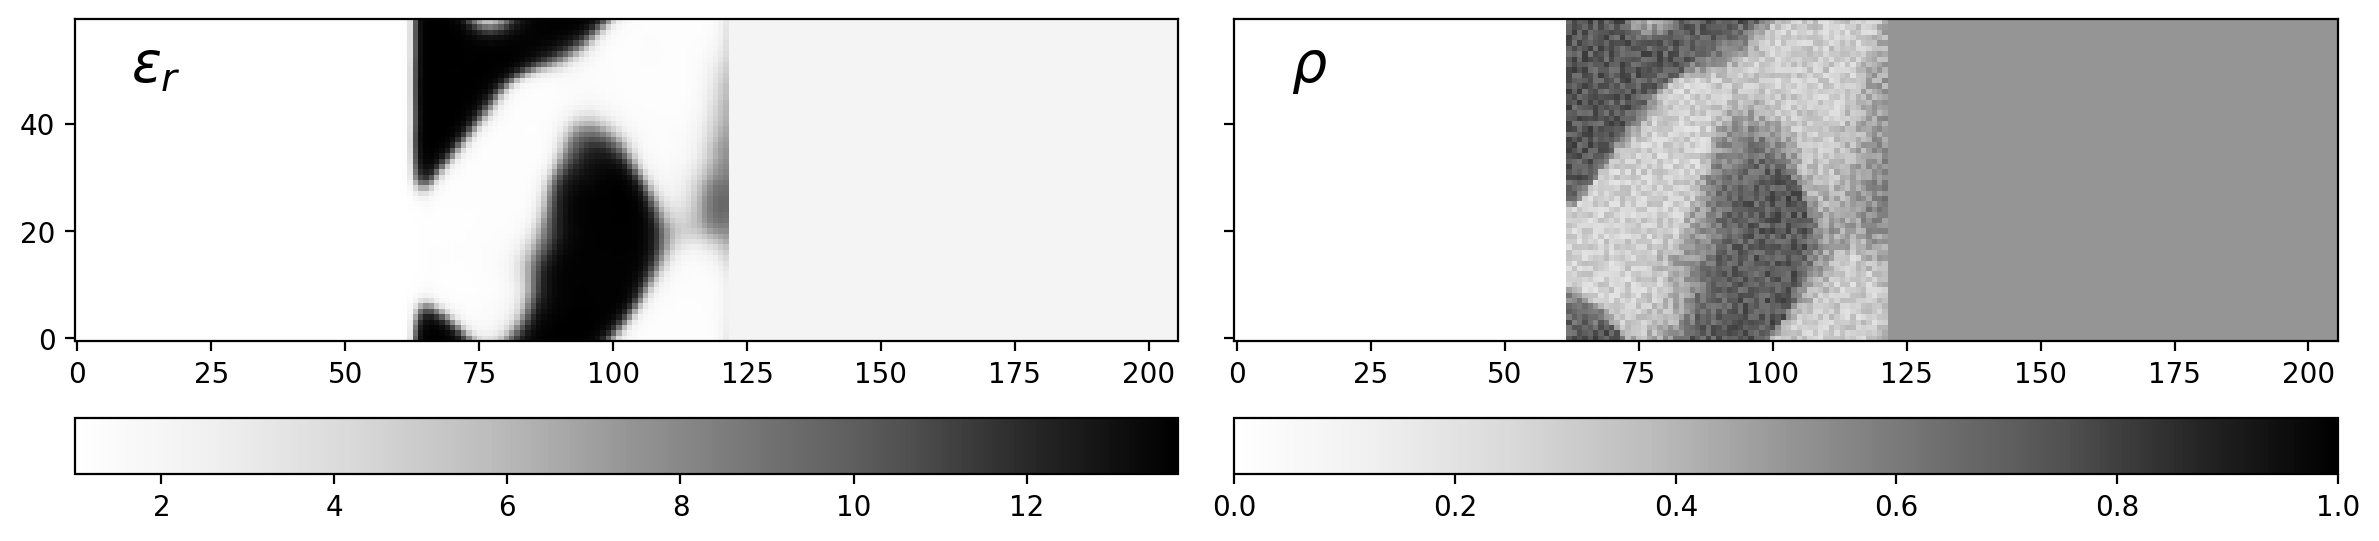

Epoch:  23/100 | Duration: 2.28 secs | Value: 3.456230e-02


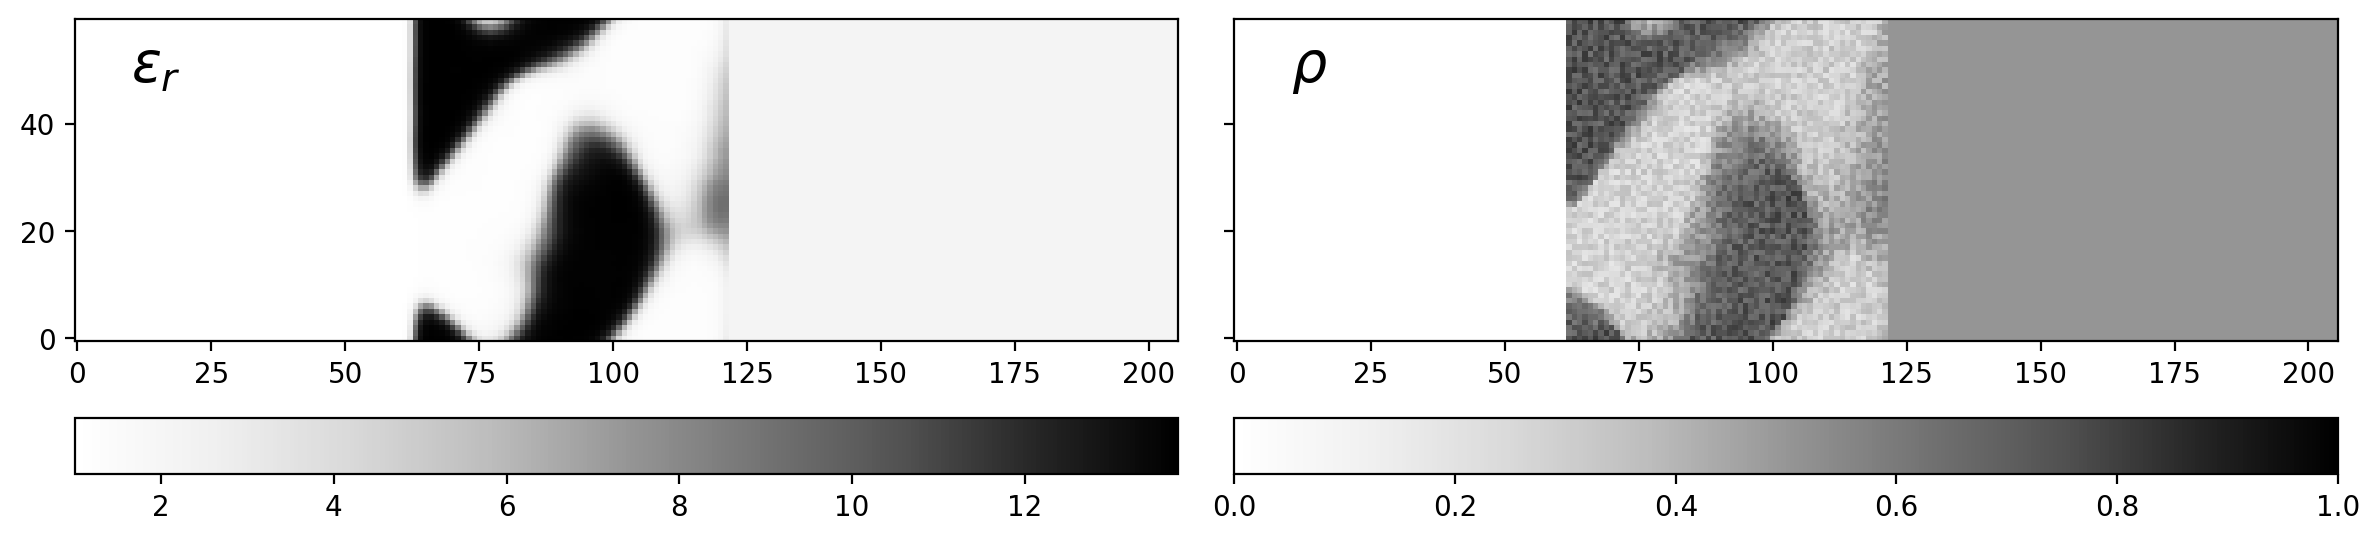

Epoch:  24/100 | Duration: 2.14 secs | Value: 3.574454e-02


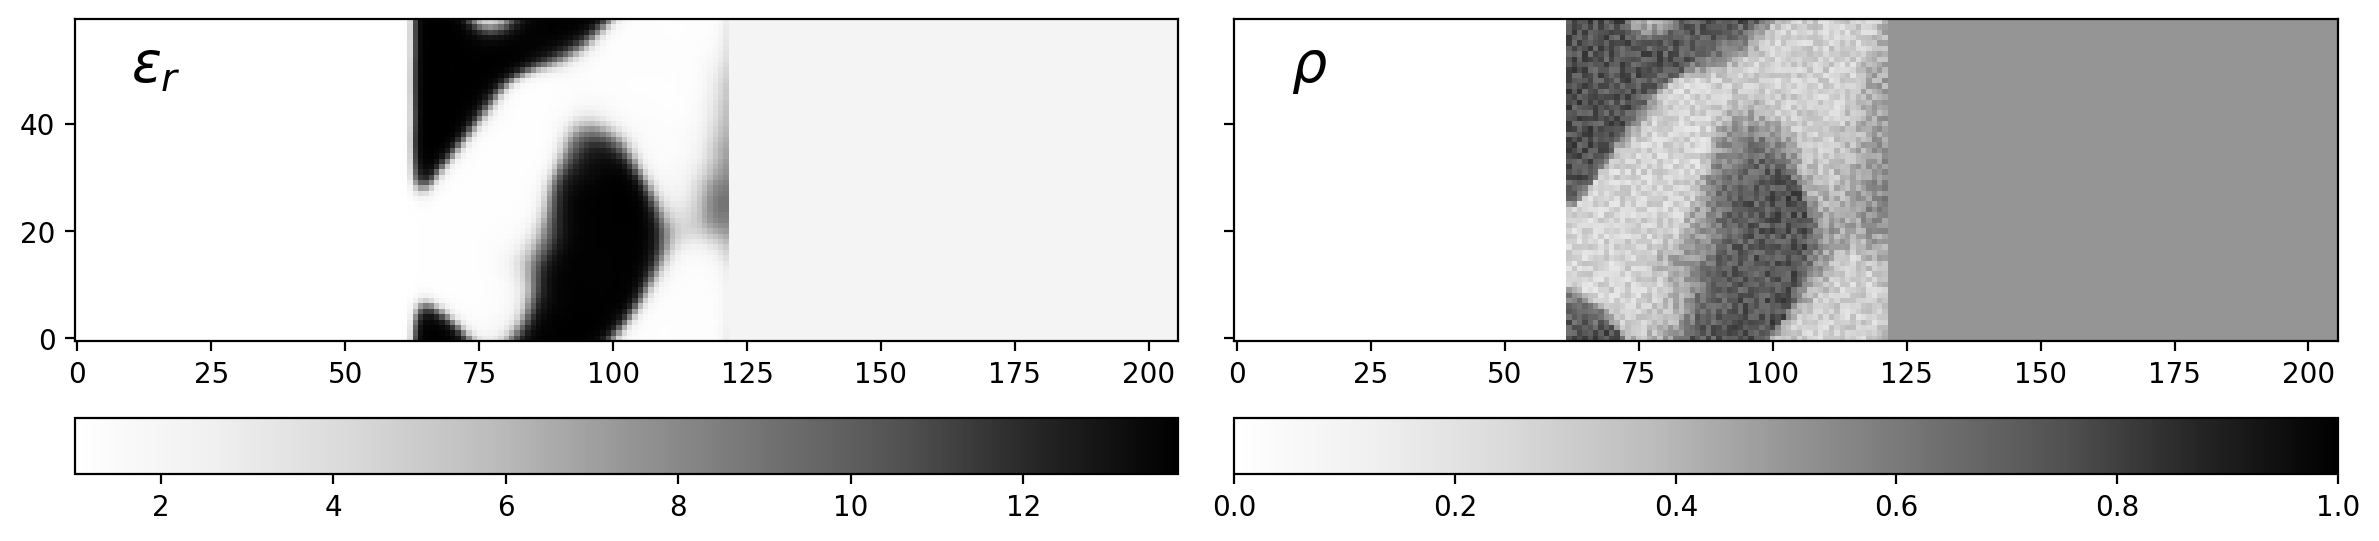

Epoch:  25/100 | Duration: 2.18 secs | Value: 3.684653e-02


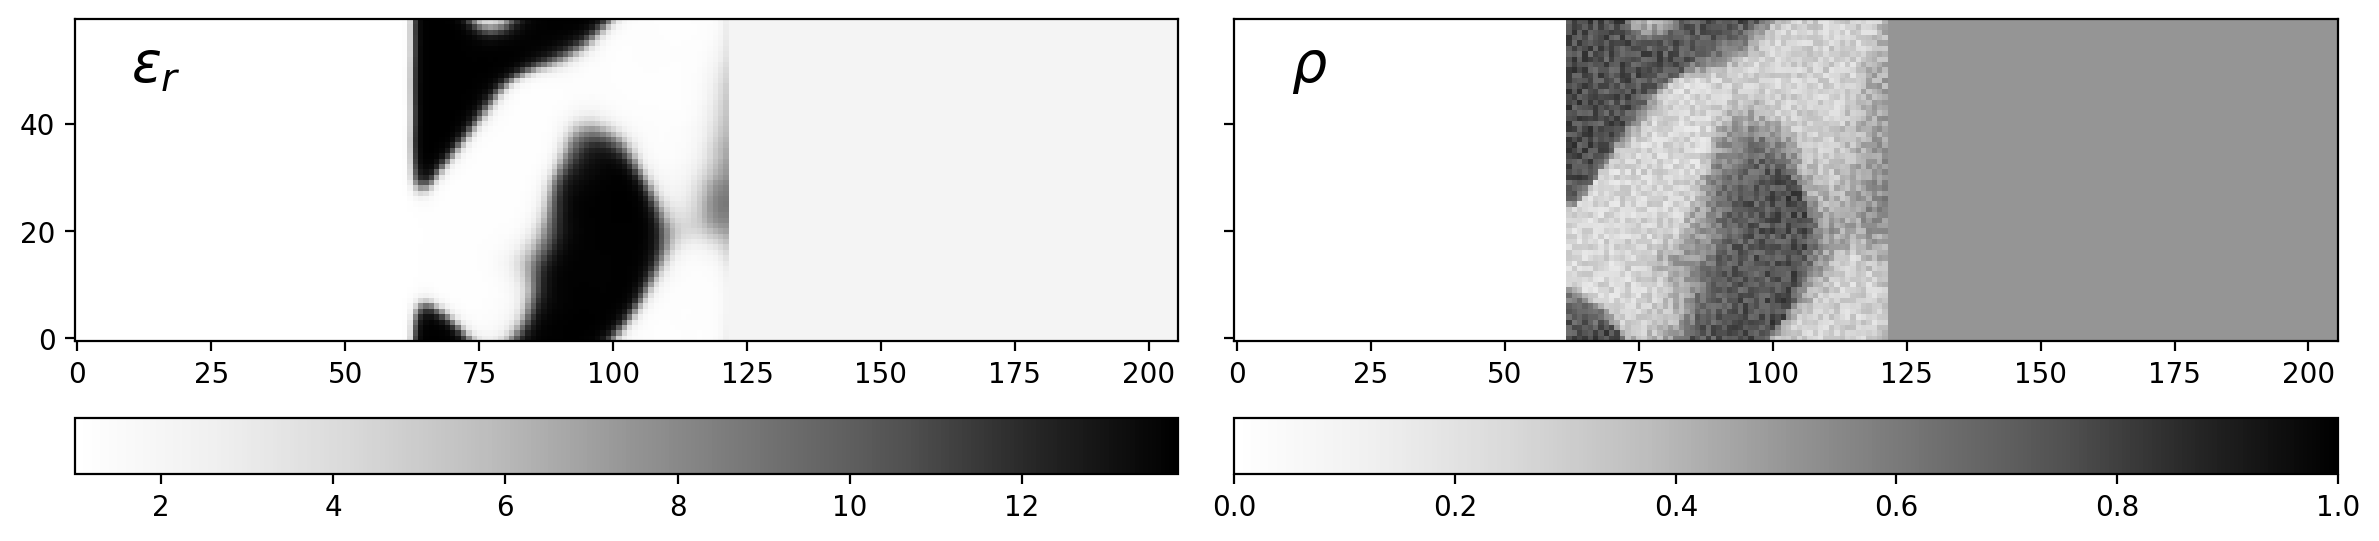

Epoch:  26/100 | Duration: 2.19 secs | Value: 3.788023e-02


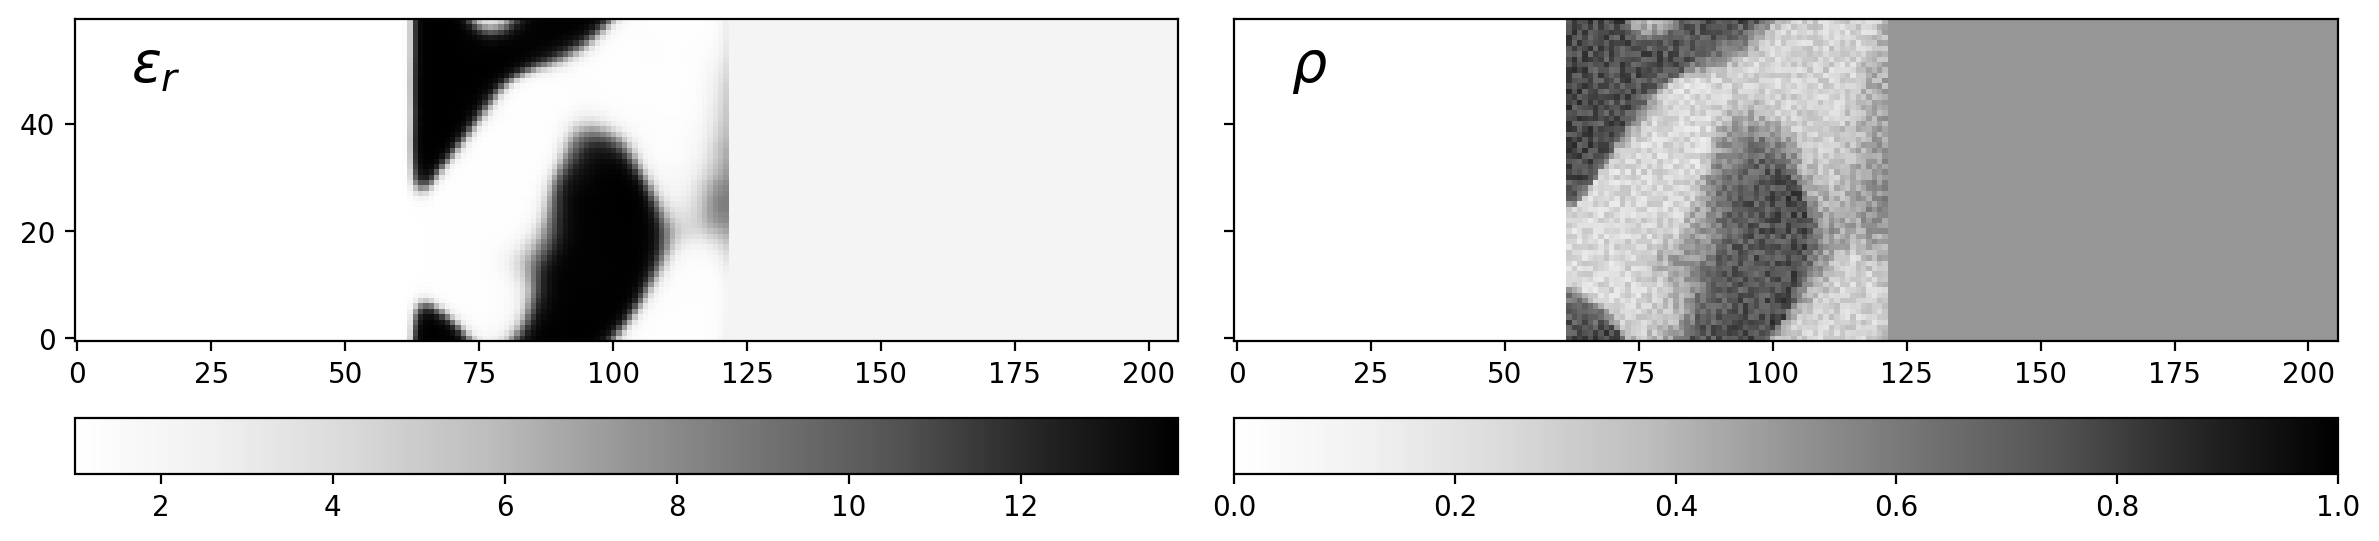

Epoch:  27/100 | Duration: 2.16 secs | Value: 3.885299e-02


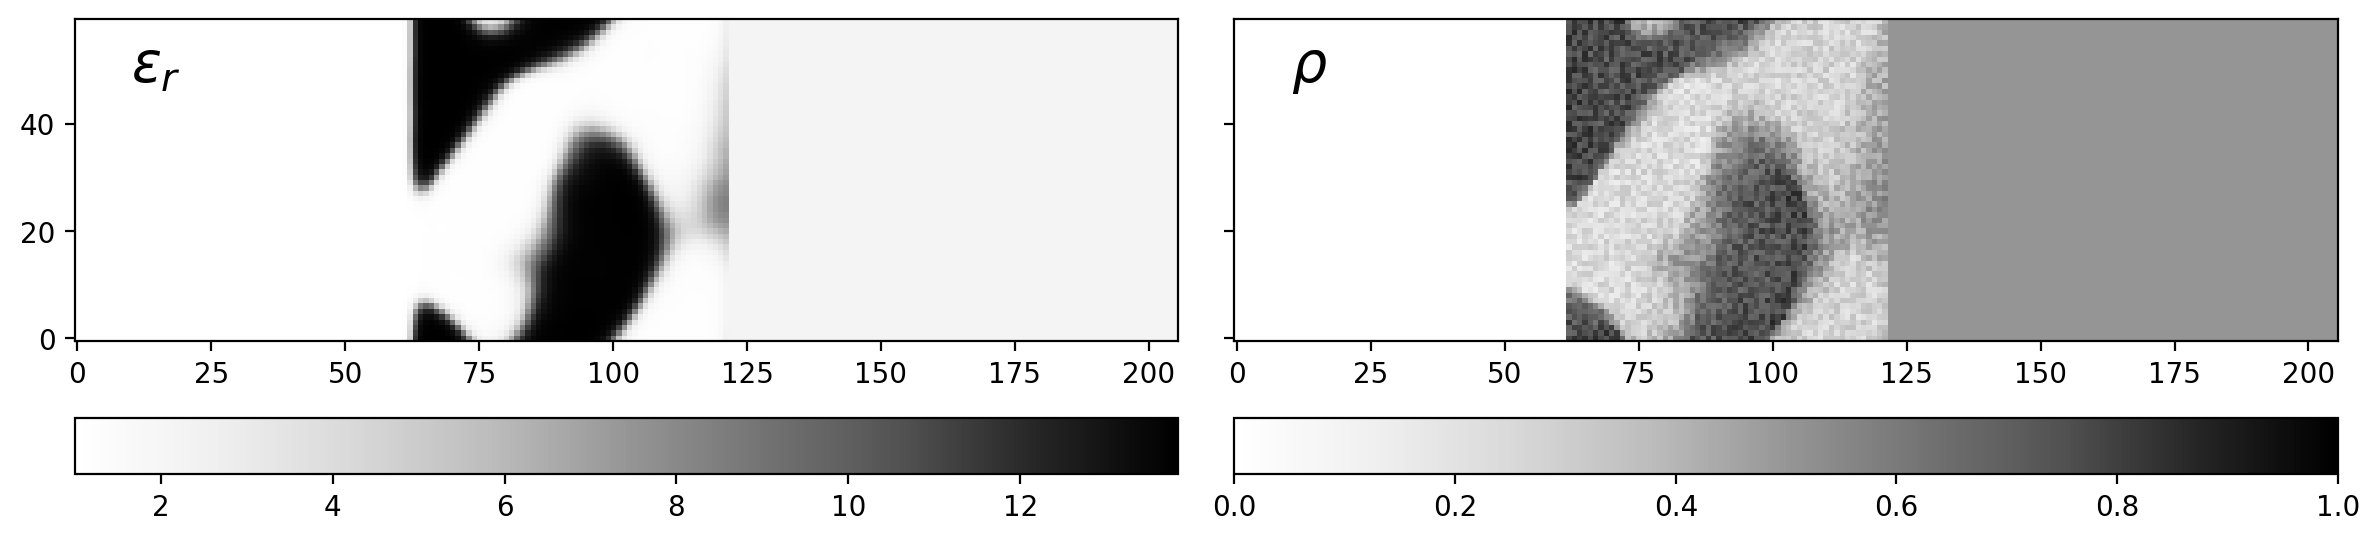

Epoch:  28/100 | Duration: 2.15 secs | Value: 3.976931e-02


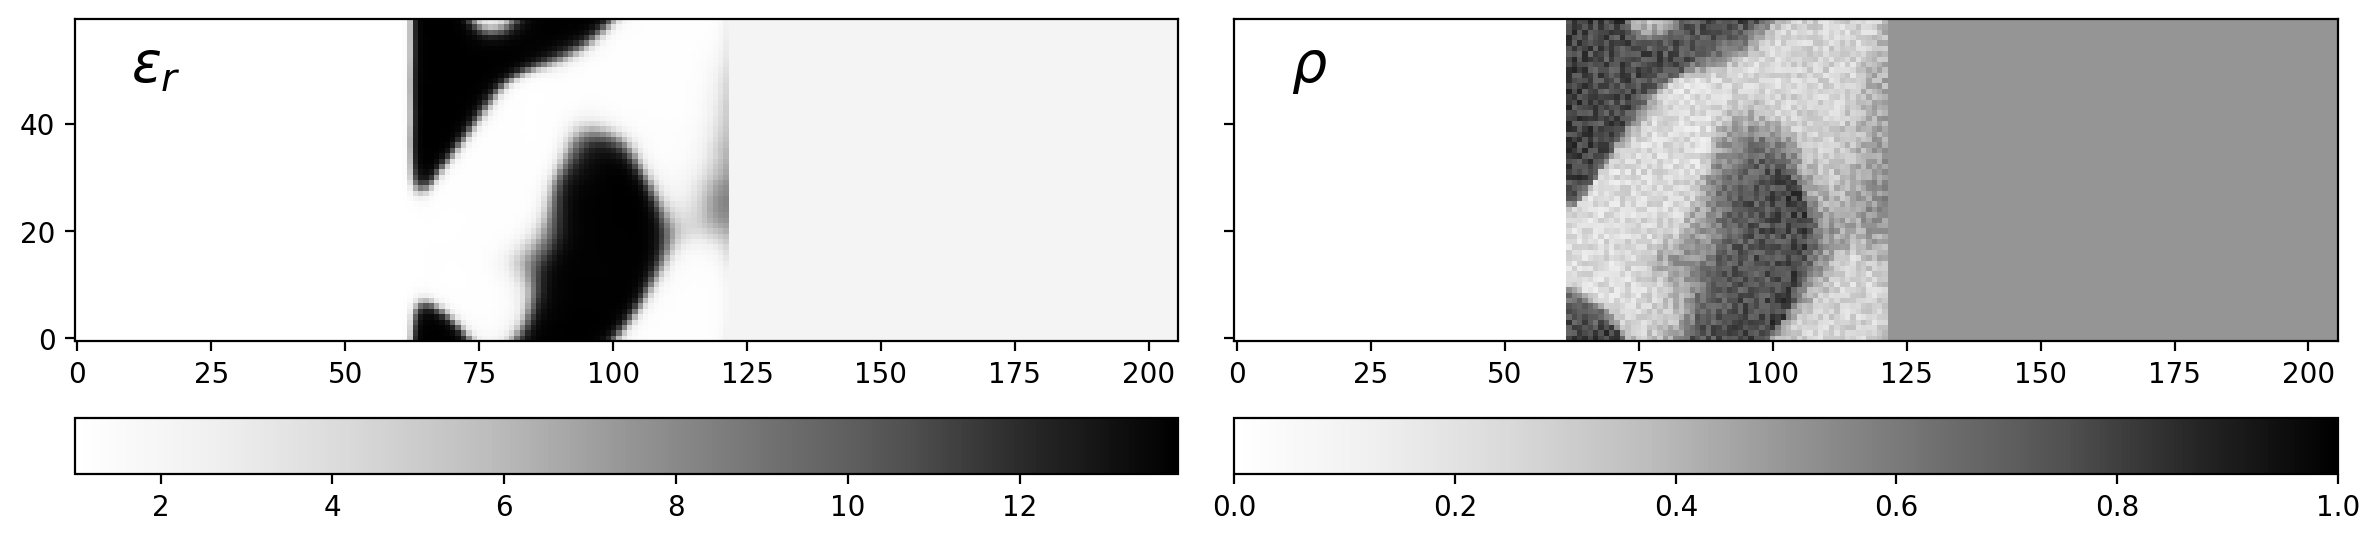

Epoch:  29/100 | Duration: 2.27 secs | Value: 4.063228e-02


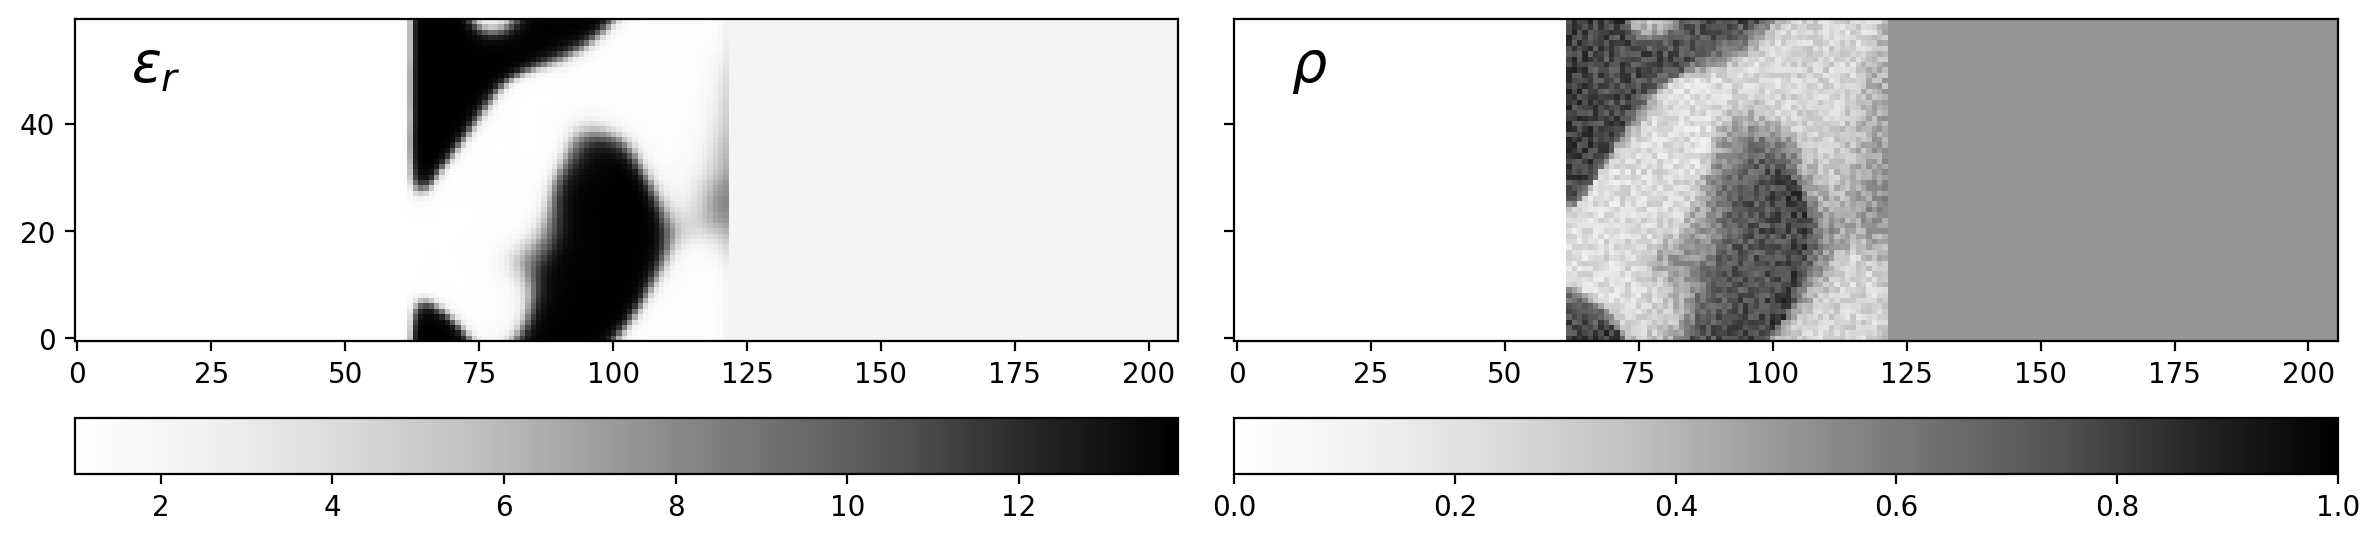

Epoch:  30/100 | Duration: 2.42 secs | Value: 4.144447e-02


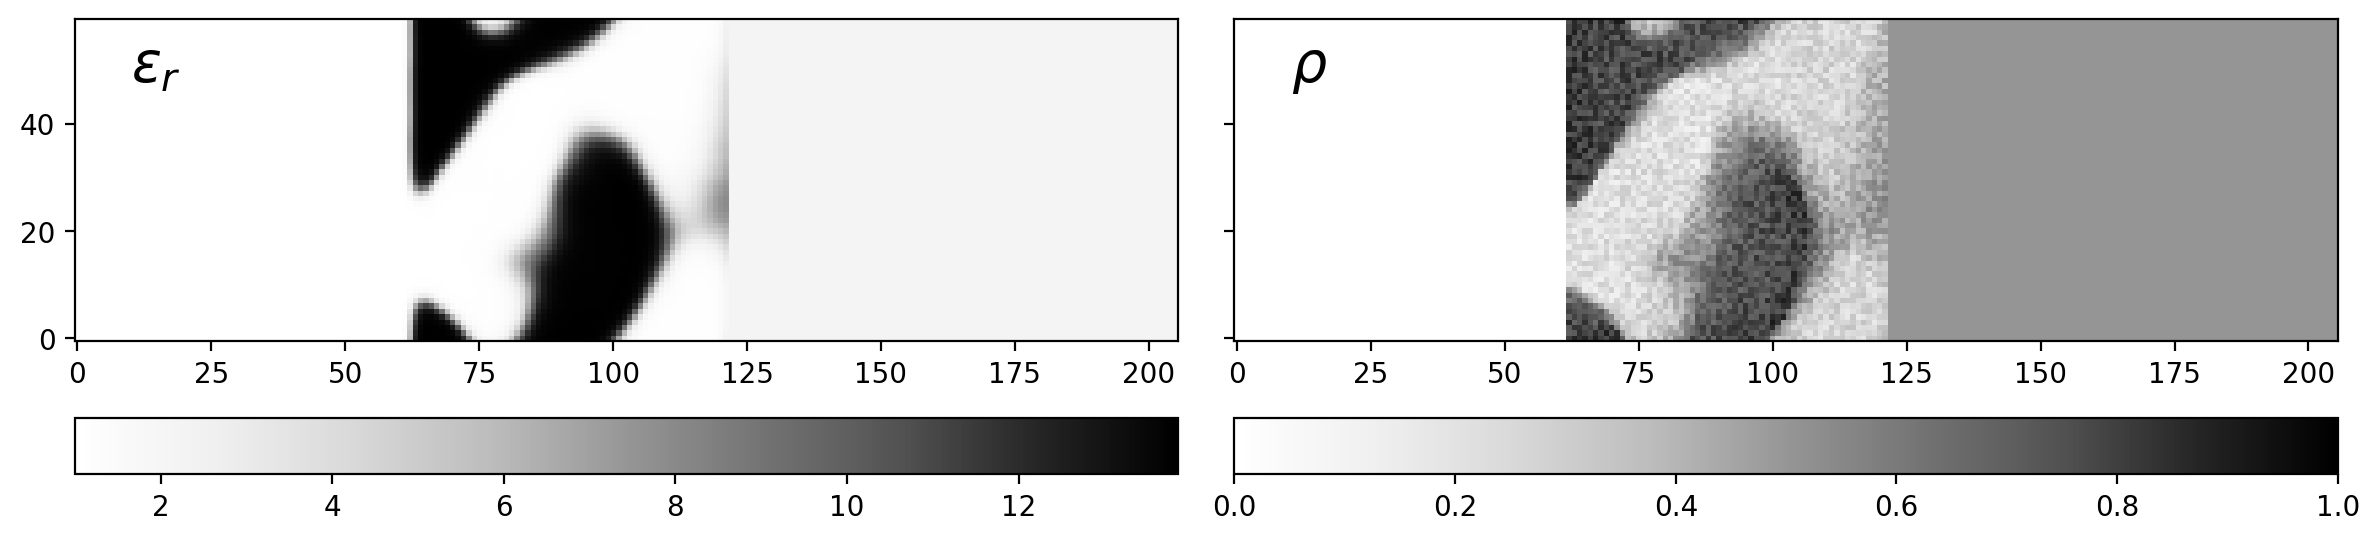

Epoch:  31/100 | Duration: 2.39 secs | Value: 4.220842e-02


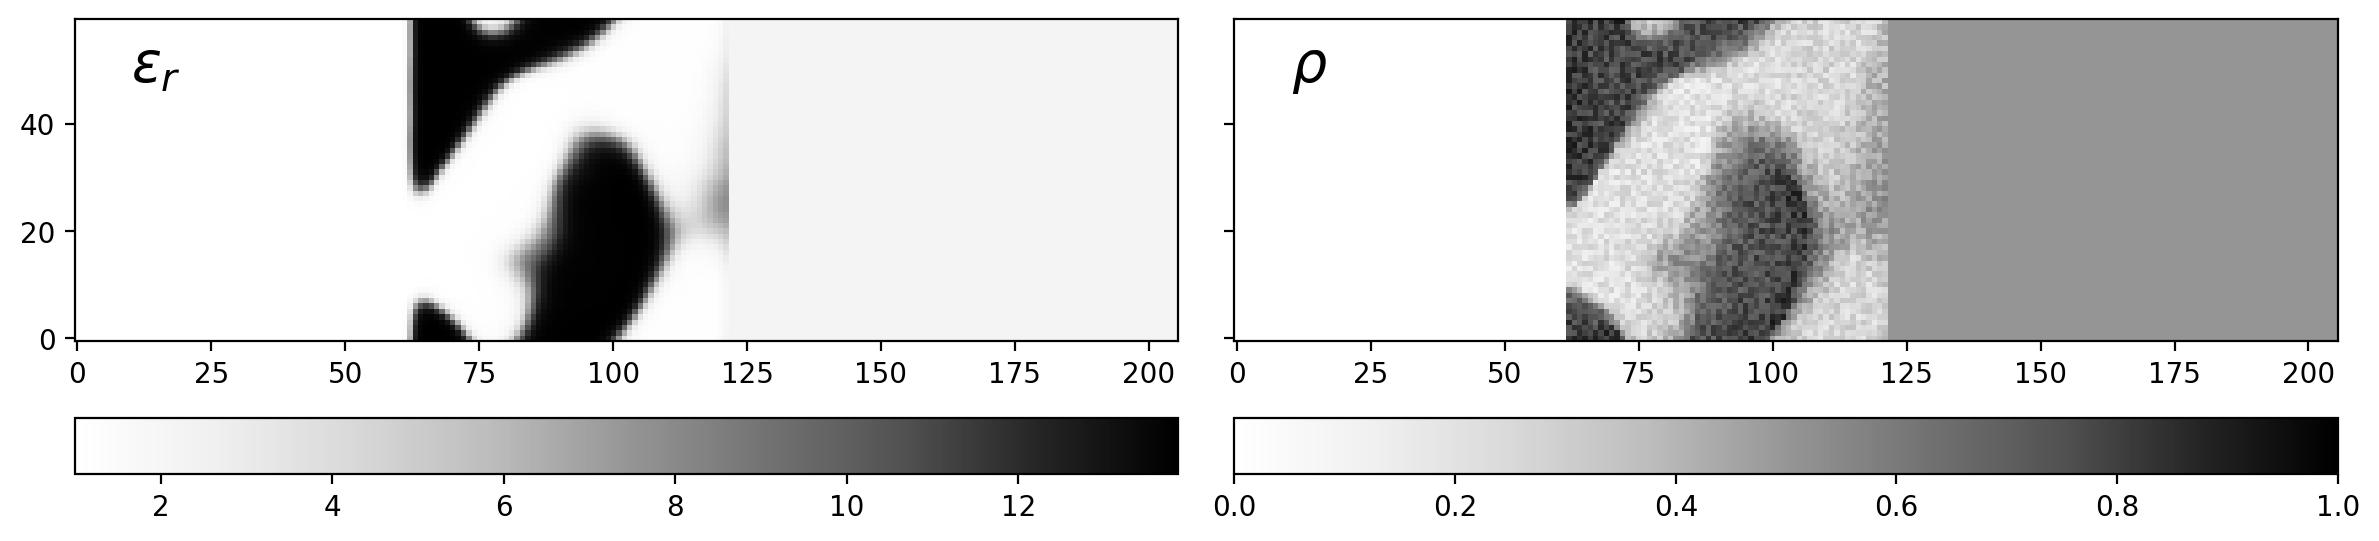

Epoch:  32/100 | Duration: 2.38 secs | Value: 4.292694e-02


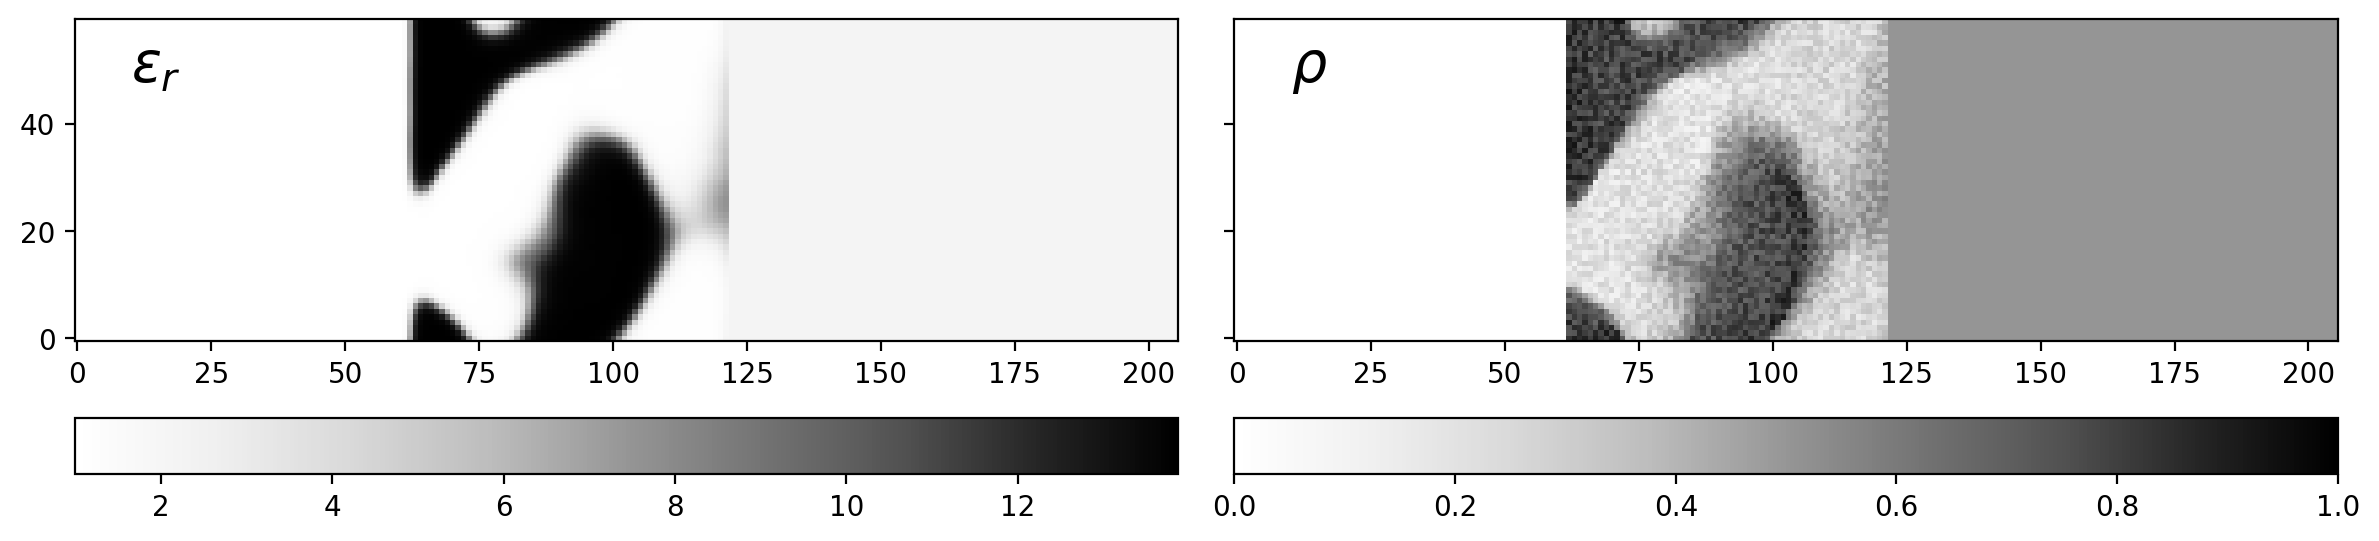

Epoch:  33/100 | Duration: 2.57 secs | Value: 4.360319e-02


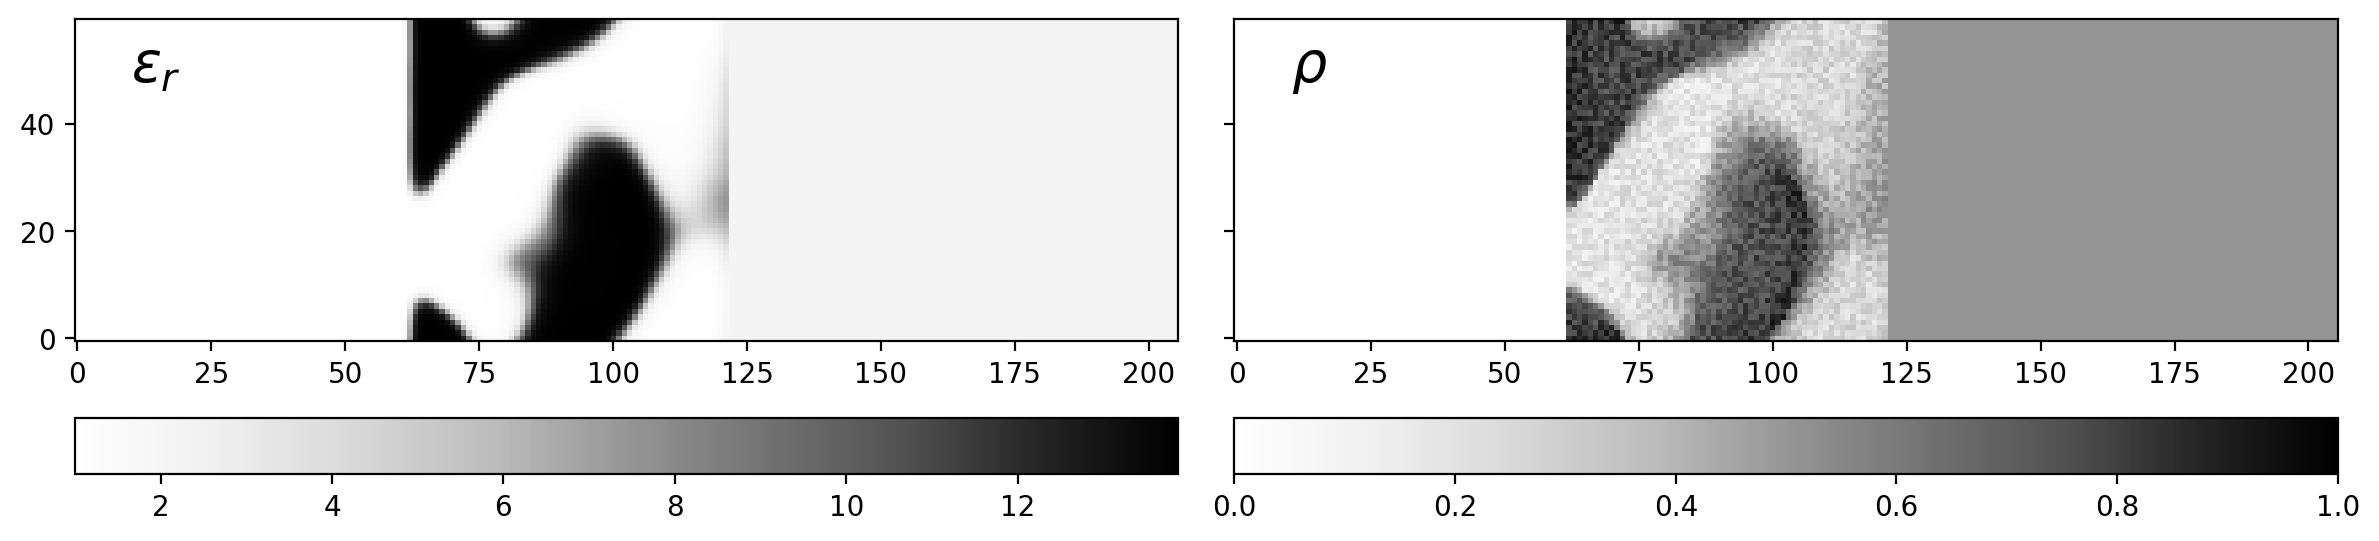

Epoch:  34/100 | Duration: 1.93 secs | Value: 4.424070e-02


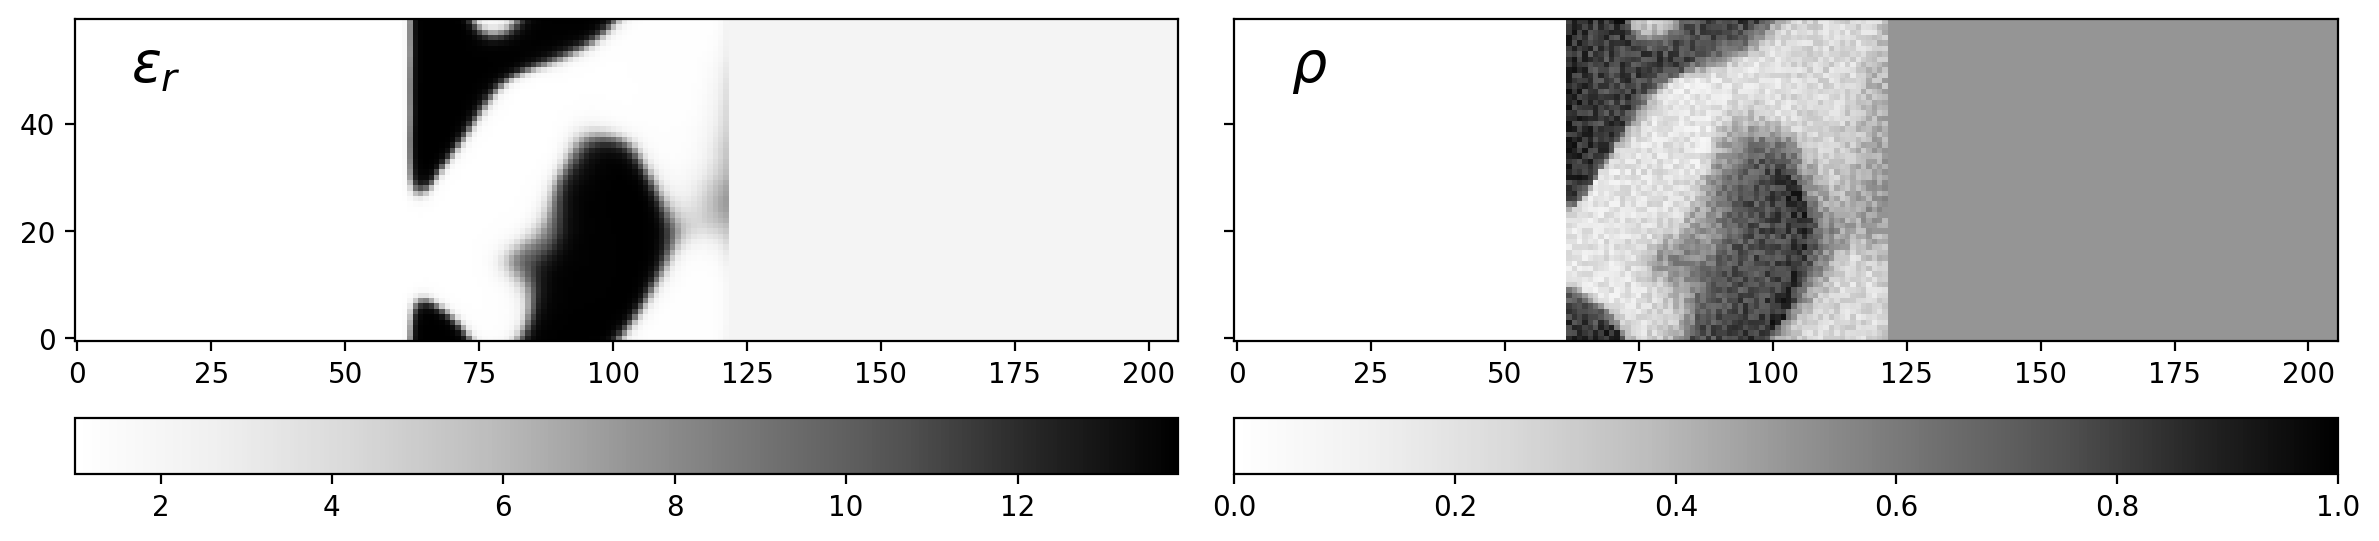

Epoch:  35/100 | Duration: 1.94 secs | Value: 4.484325e-02


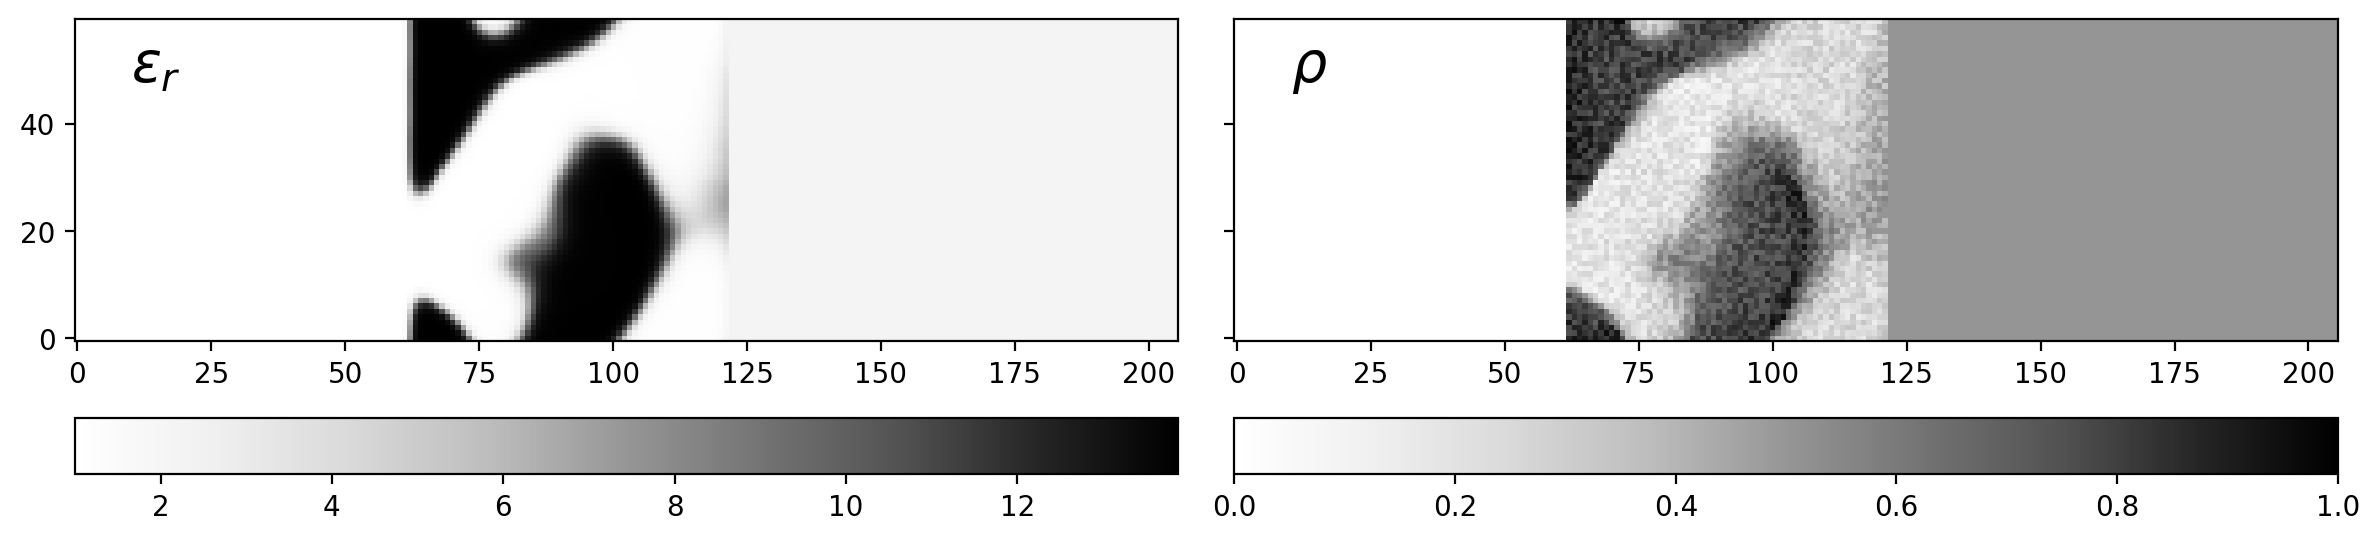

Epoch:  36/100 | Duration: 2.16 secs | Value: 4.541465e-02


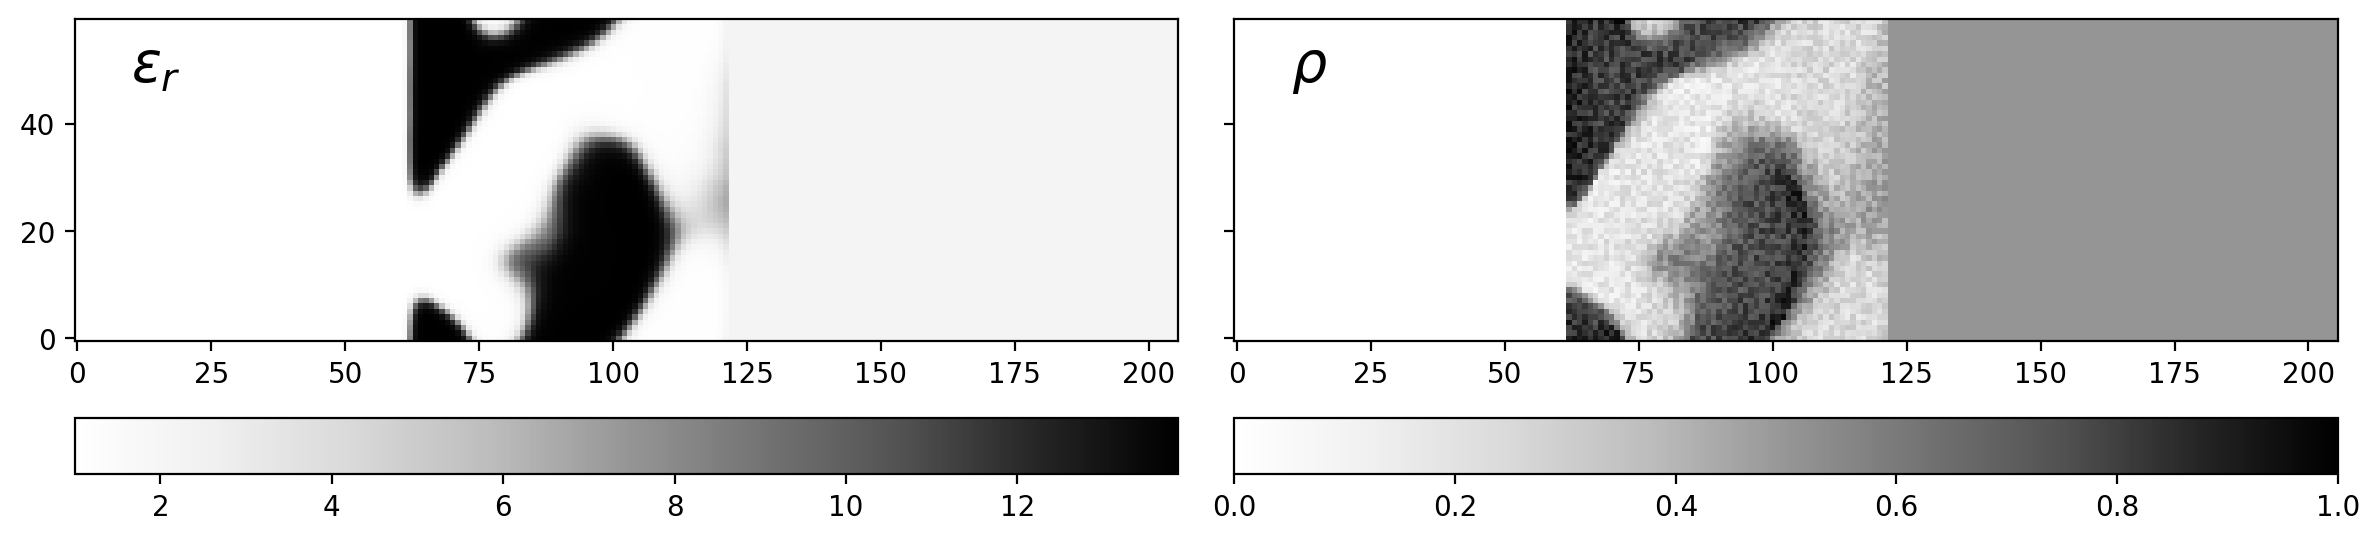

Epoch:  37/100 | Duration: 2.12 secs | Value: 4.595862e-02


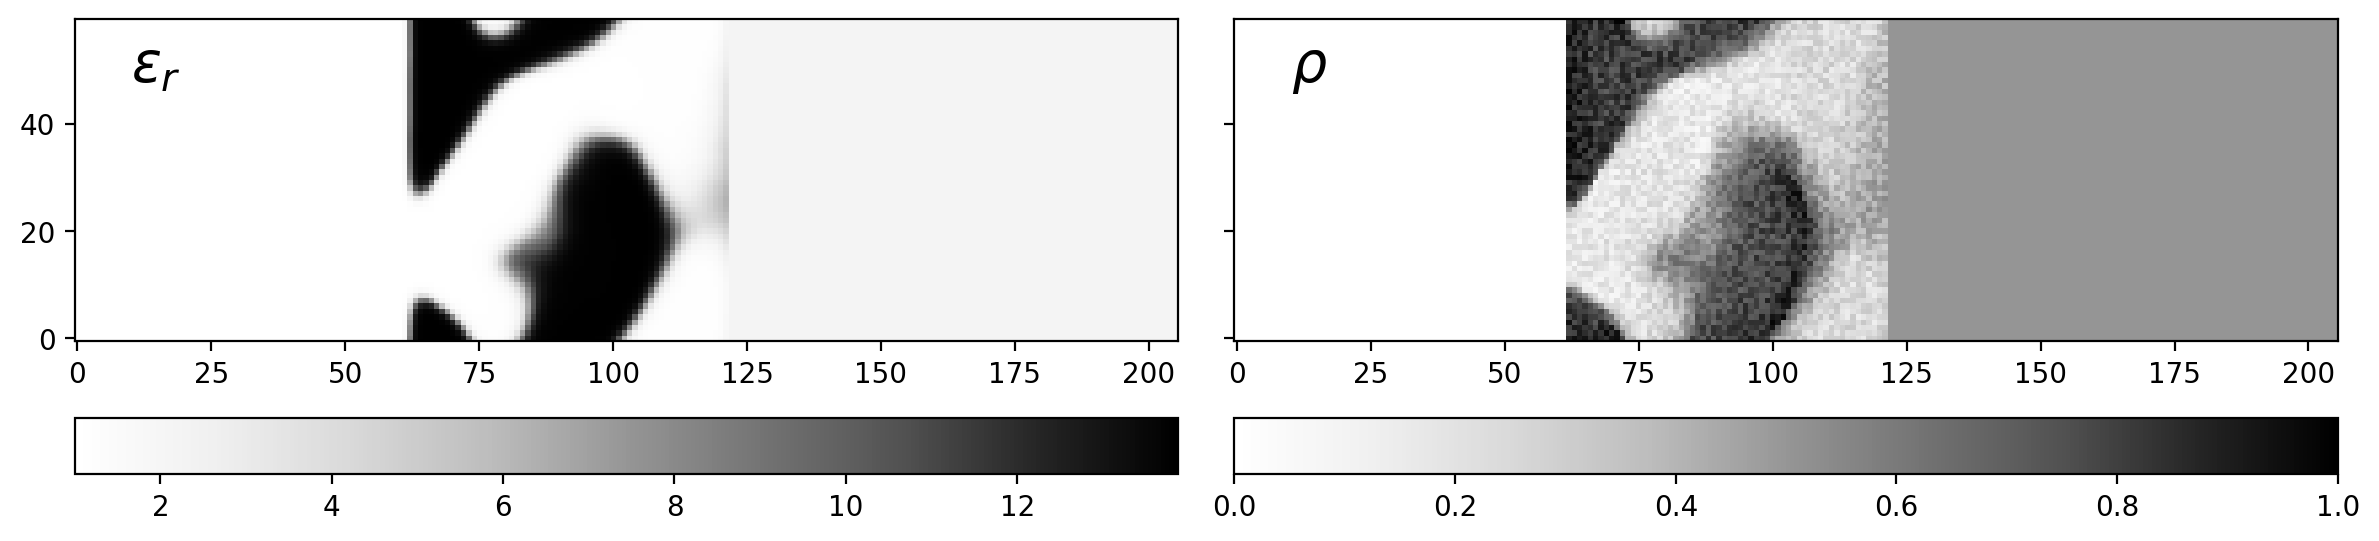

Epoch:  38/100 | Duration: 2.12 secs | Value: 4.647855e-02


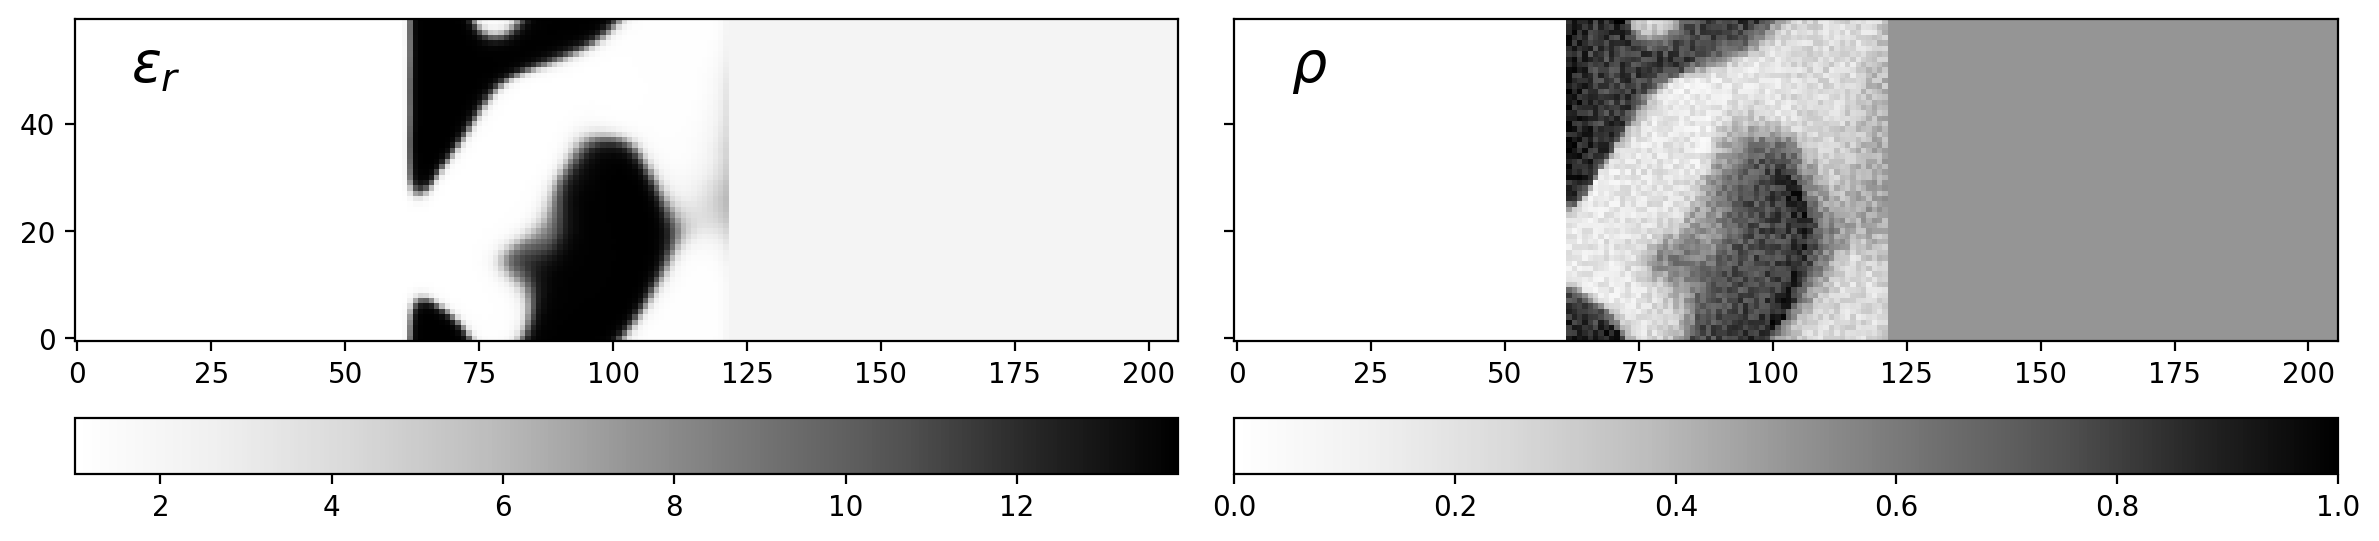

Epoch:  39/100 | Duration: 2.08 secs | Value: 4.697739e-02


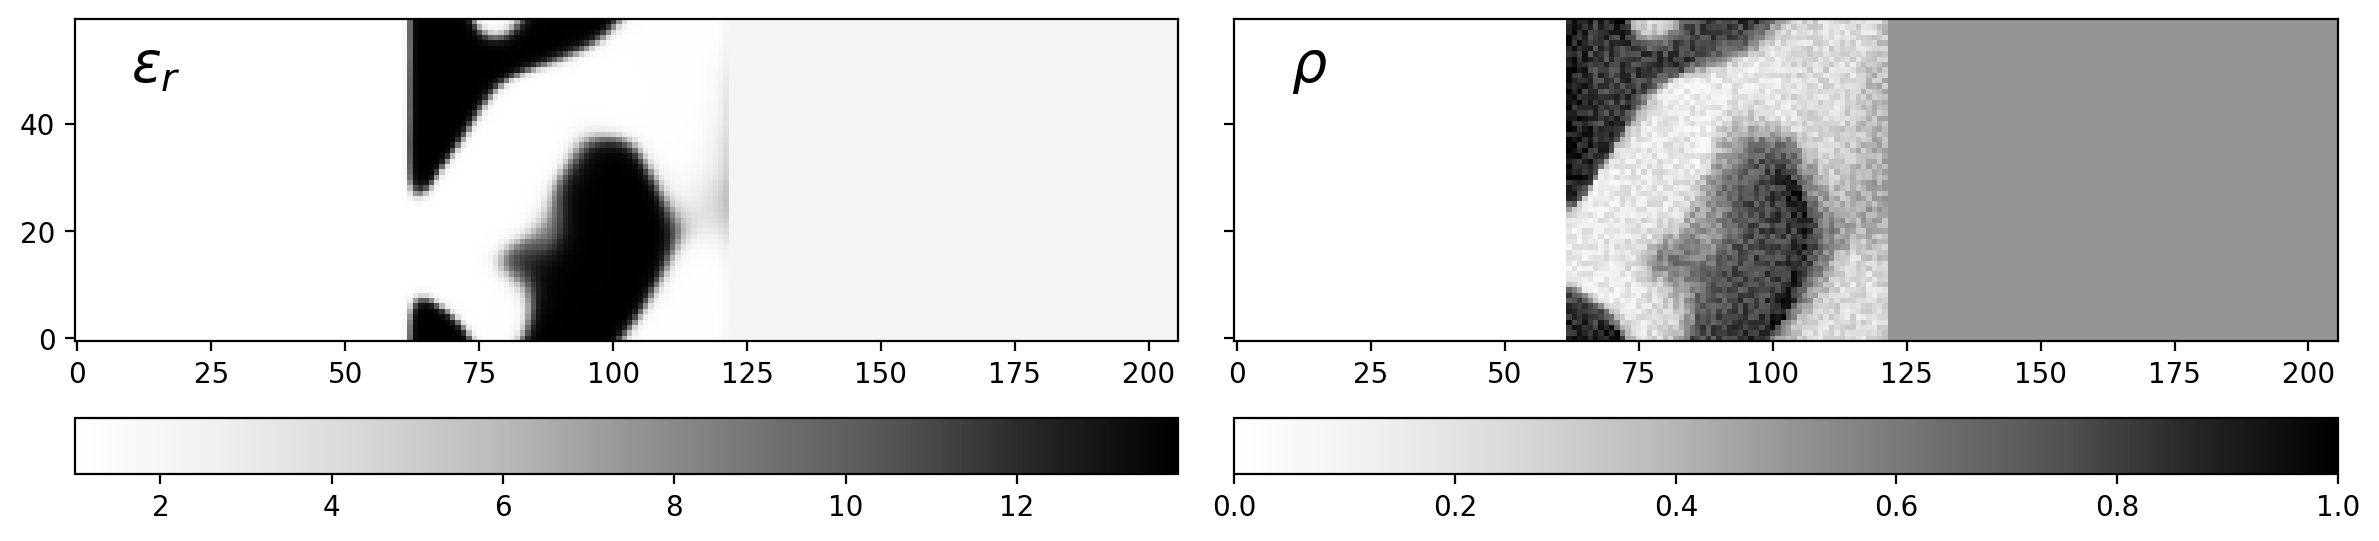

Epoch:  40/100 | Duration: 2.25 secs | Value: 4.745759e-02


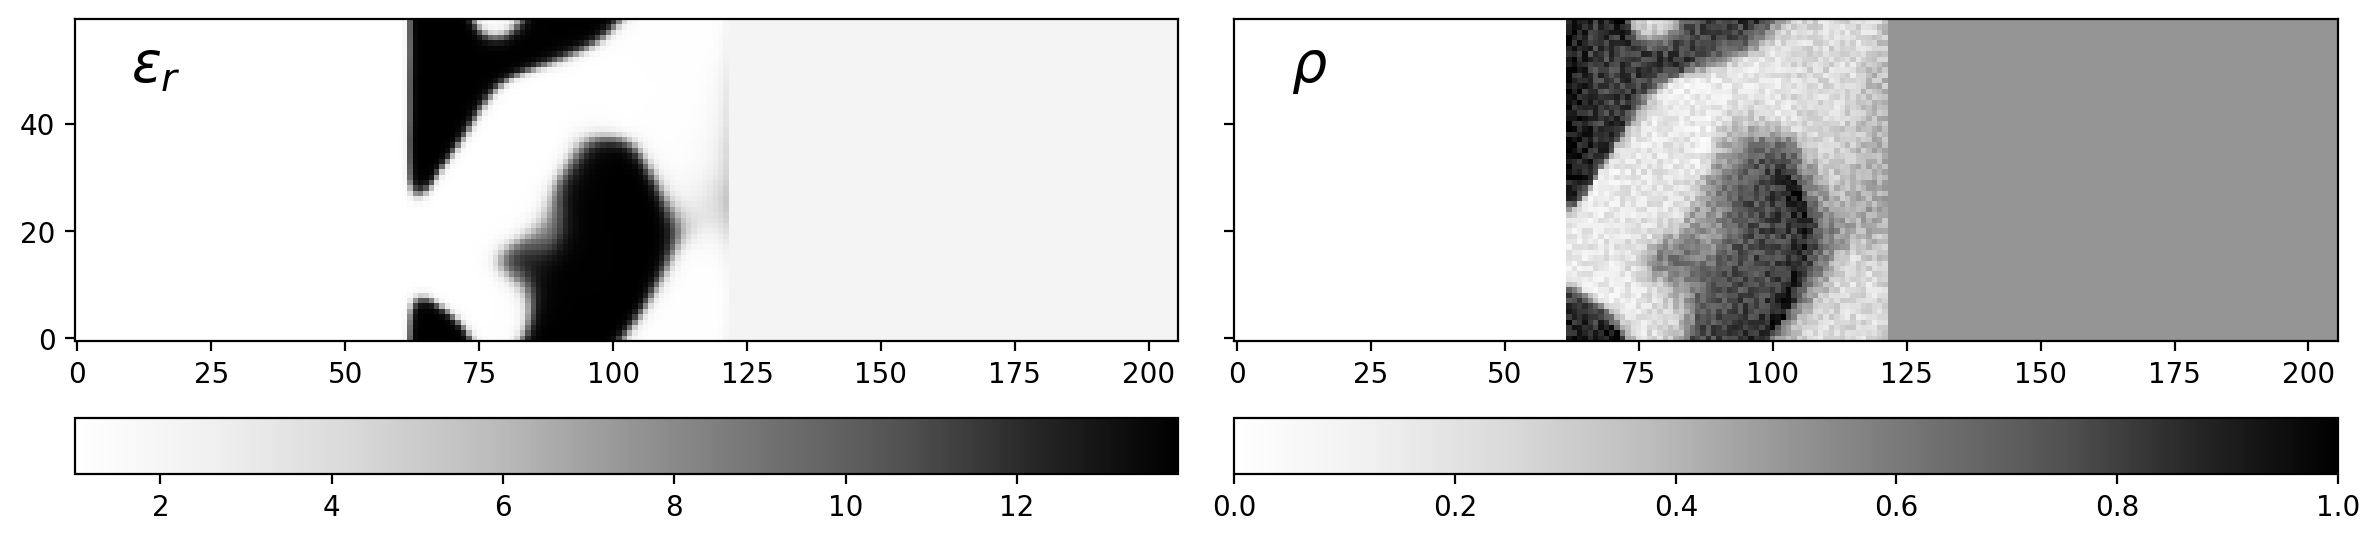

Epoch:  41/100 | Duration: 2.09 secs | Value: 4.792112e-02


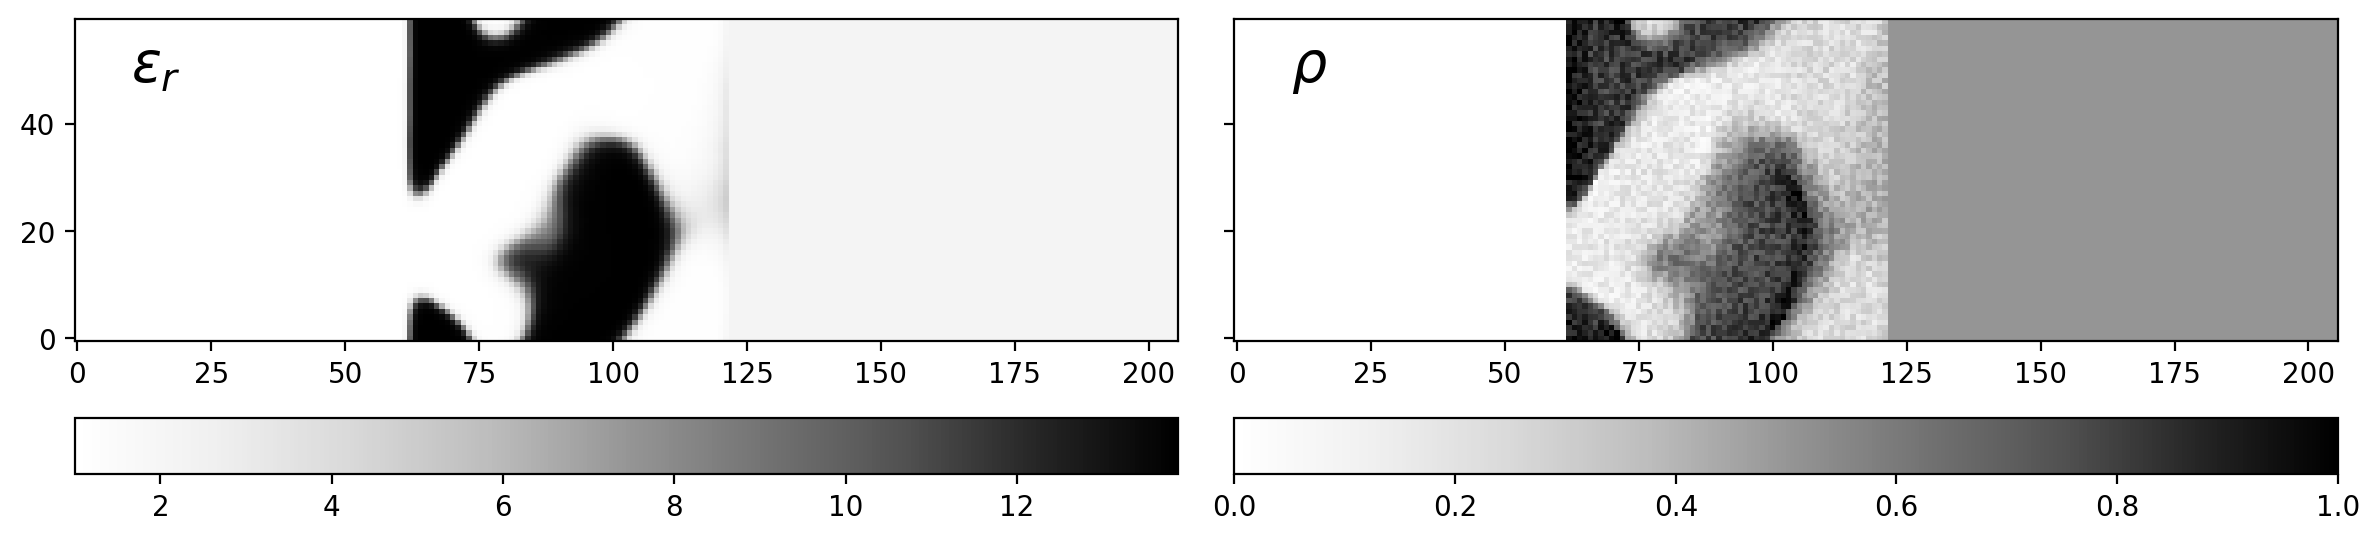

Epoch:  42/100 | Duration: 2.14 secs | Value: 4.836954e-02


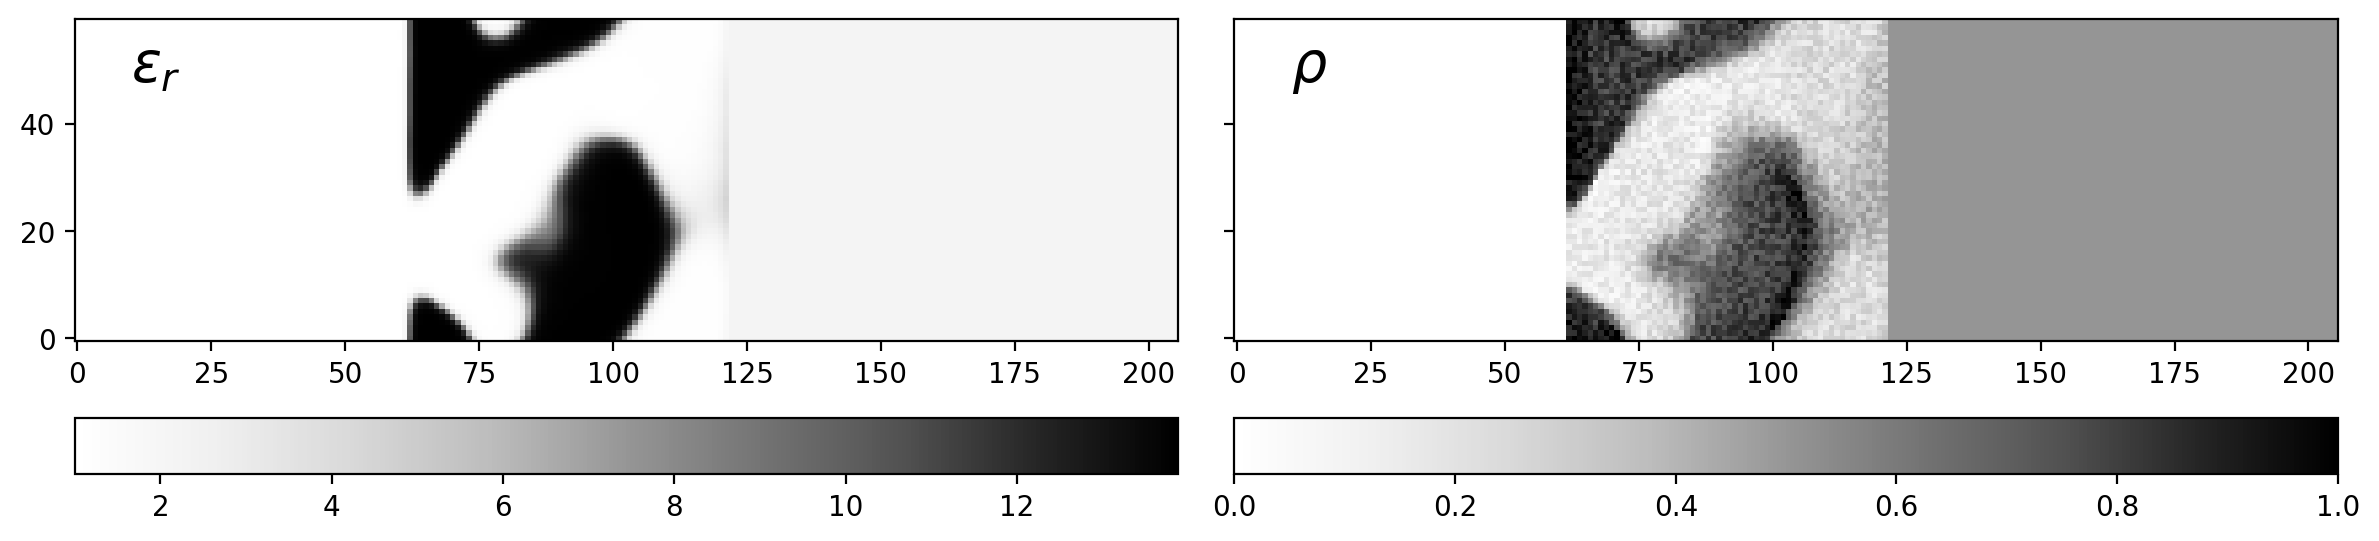

Epoch:  43/100 | Duration: 2.13 secs | Value: 4.880408e-02


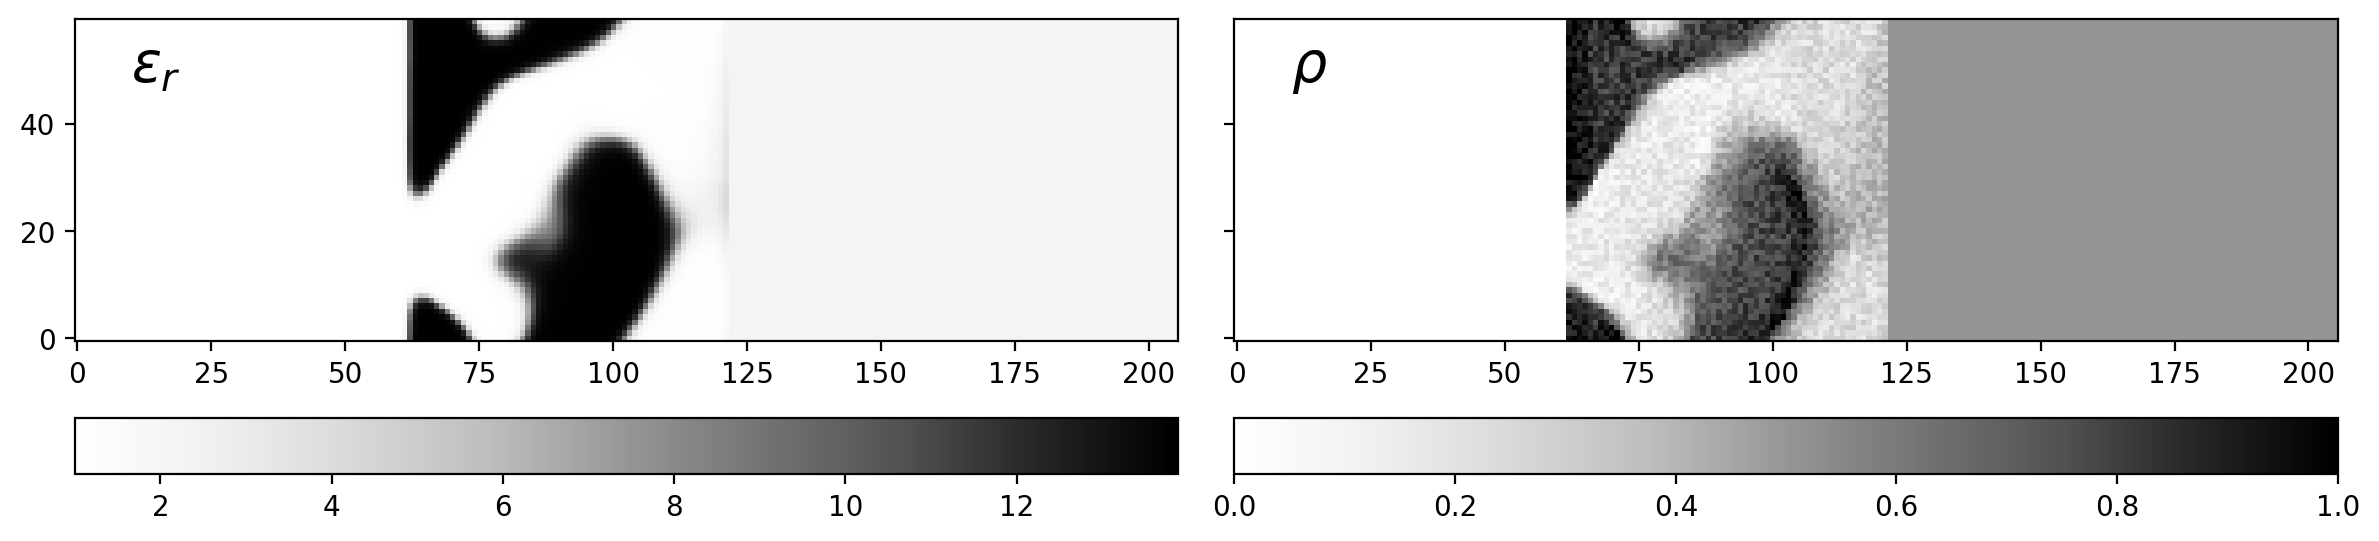

Epoch:  44/100 | Duration: 2.34 secs | Value: 4.922571e-02


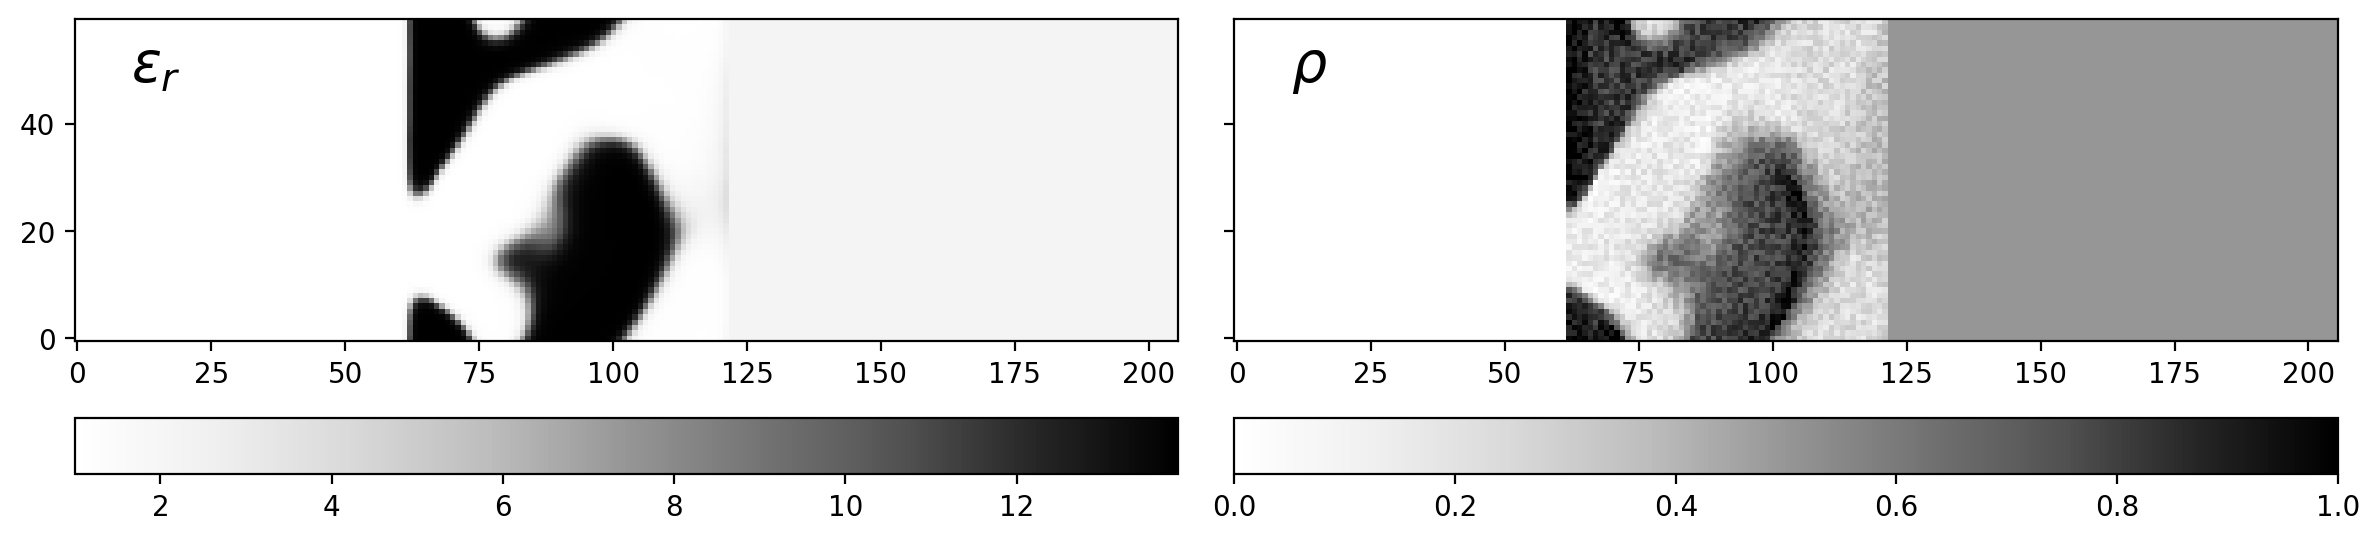

Epoch:  45/100 | Duration: 2.20 secs | Value: 4.963525e-02


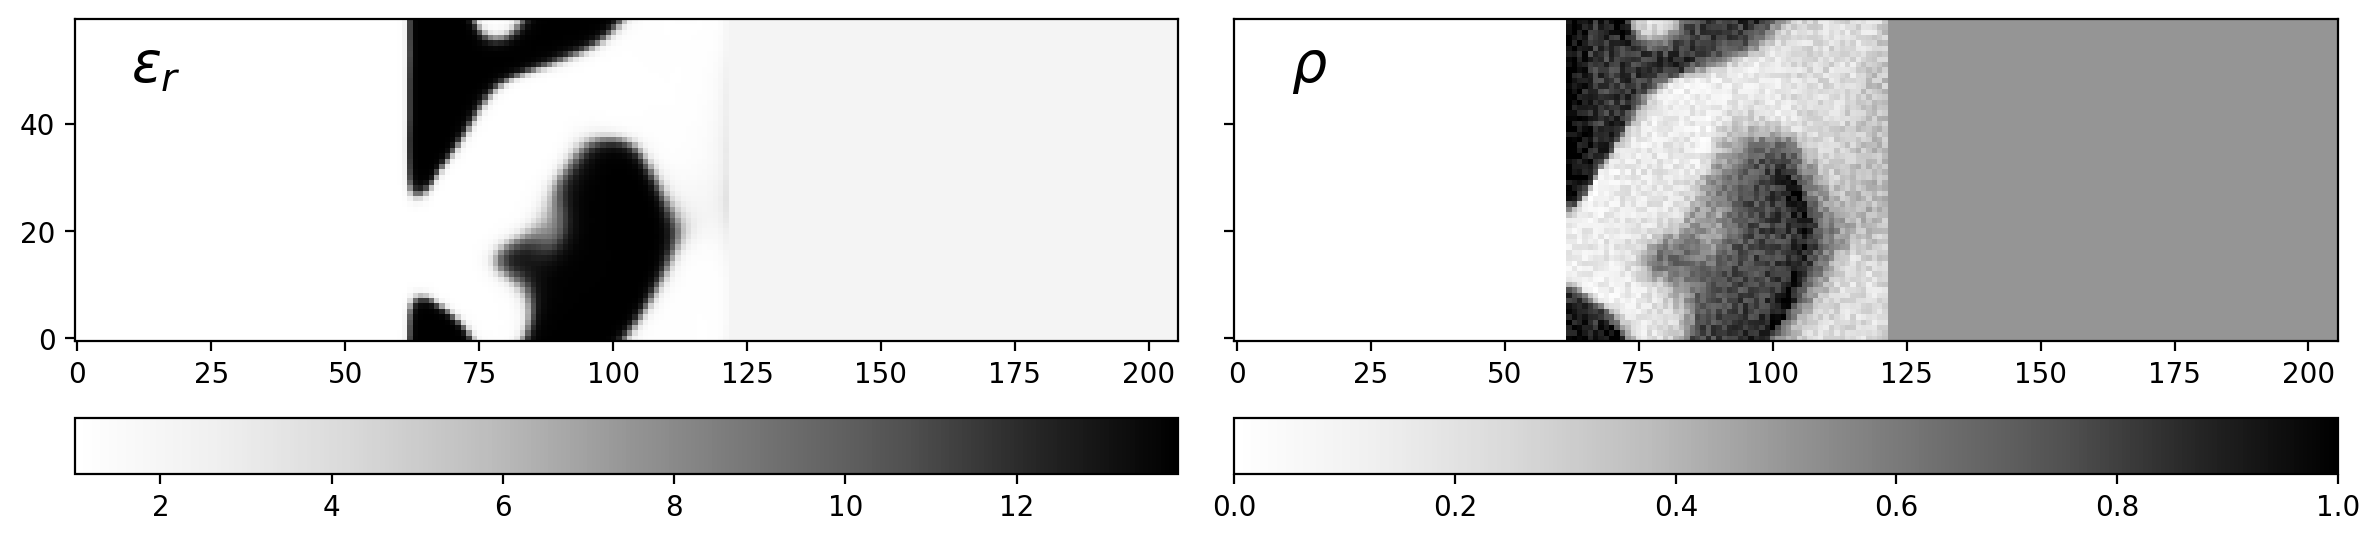

Epoch:  46/100 | Duration: 2.32 secs | Value: 5.003344e-02


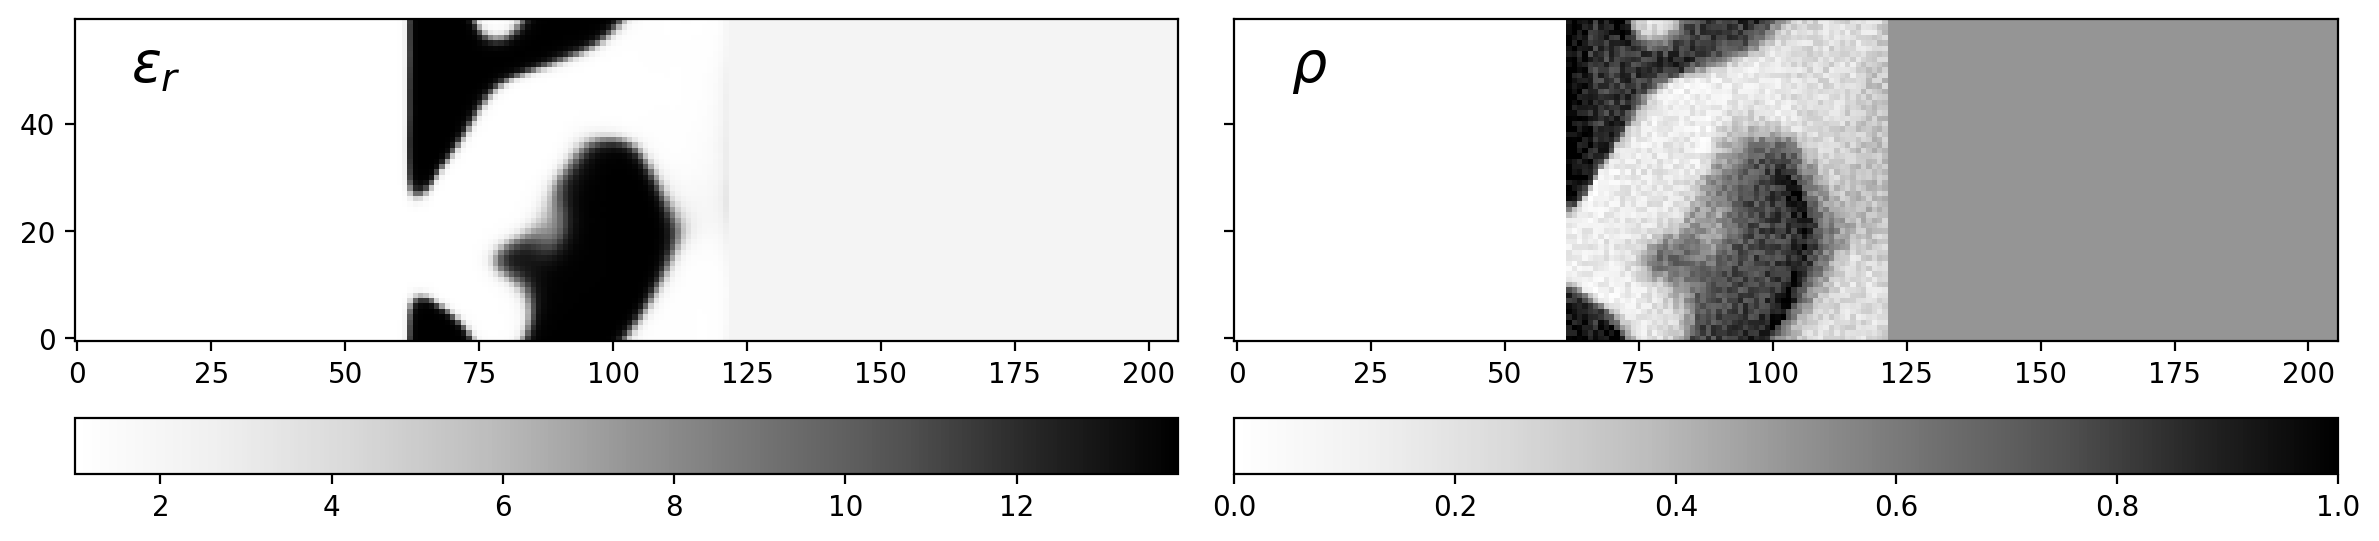

Epoch:  47/100 | Duration: 2.16 secs | Value: 5.042093e-02


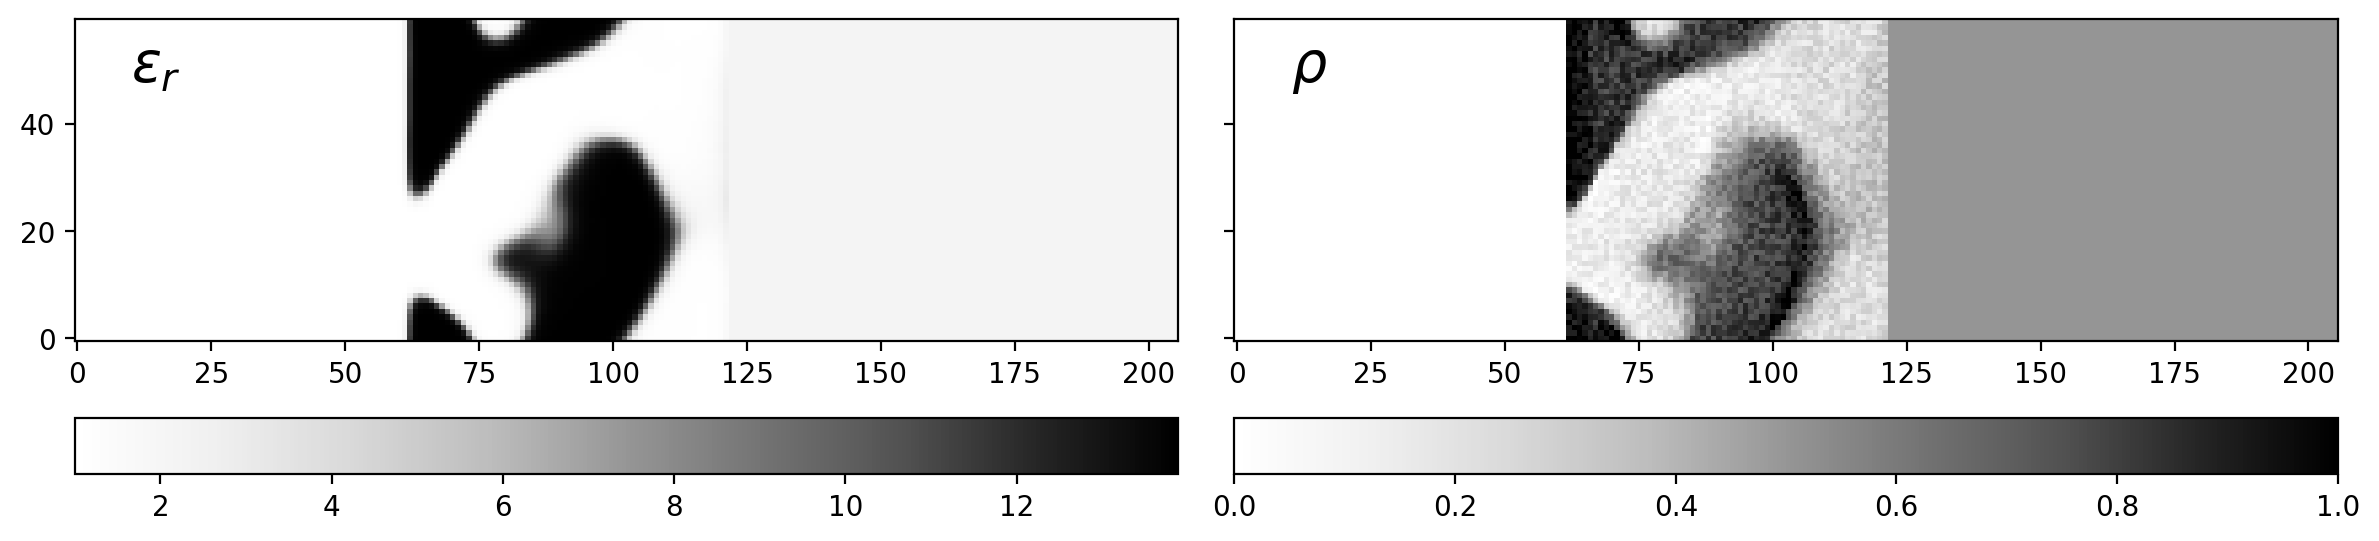

Epoch:  48/100 | Duration: 2.30 secs | Value: 5.079836e-02


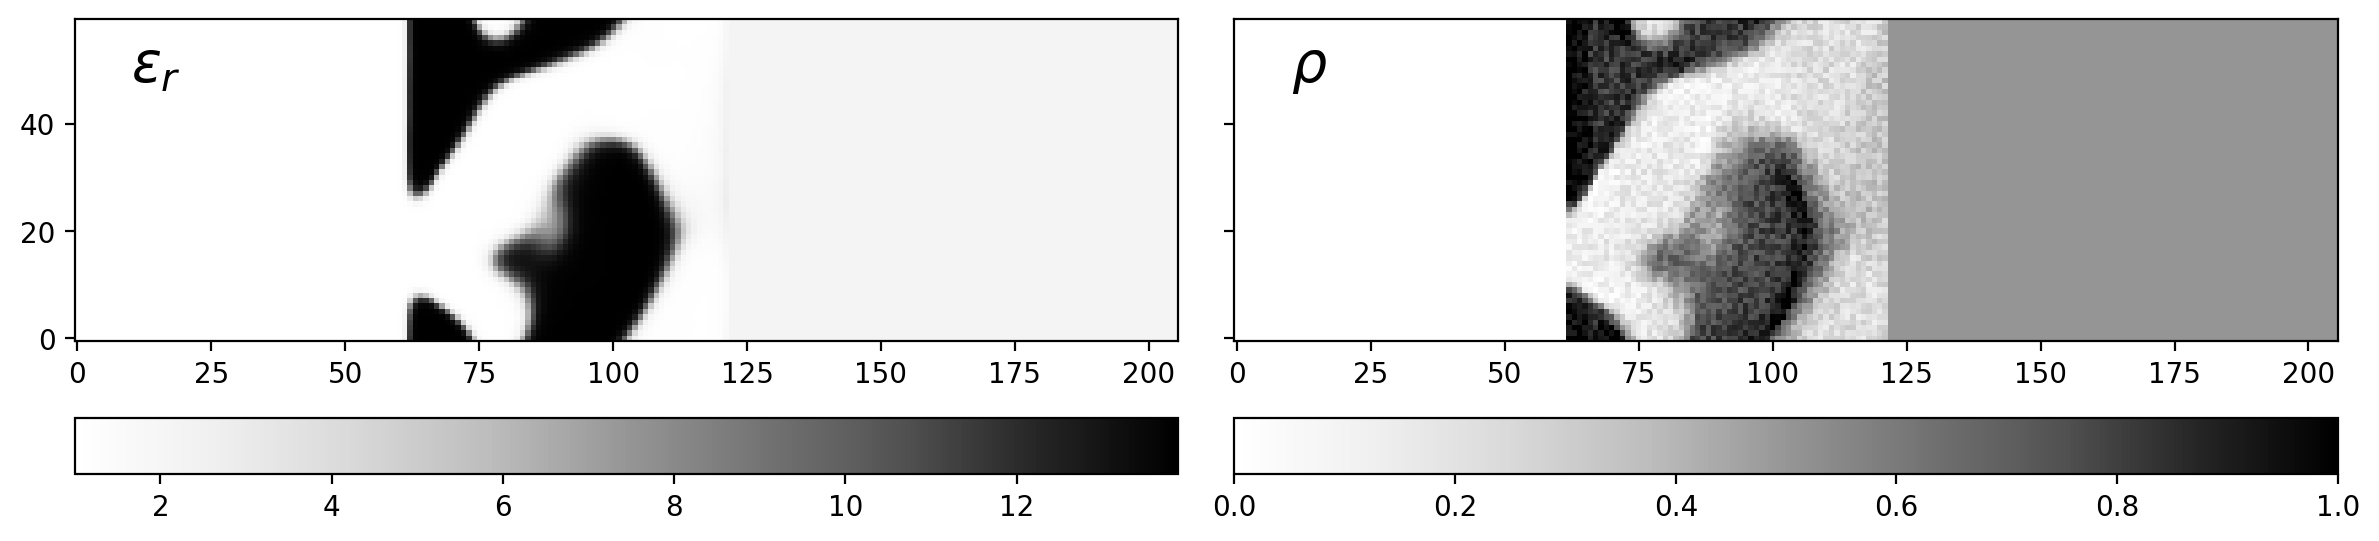

Epoch:  49/100 | Duration: 2.45 secs | Value: 5.116631e-02


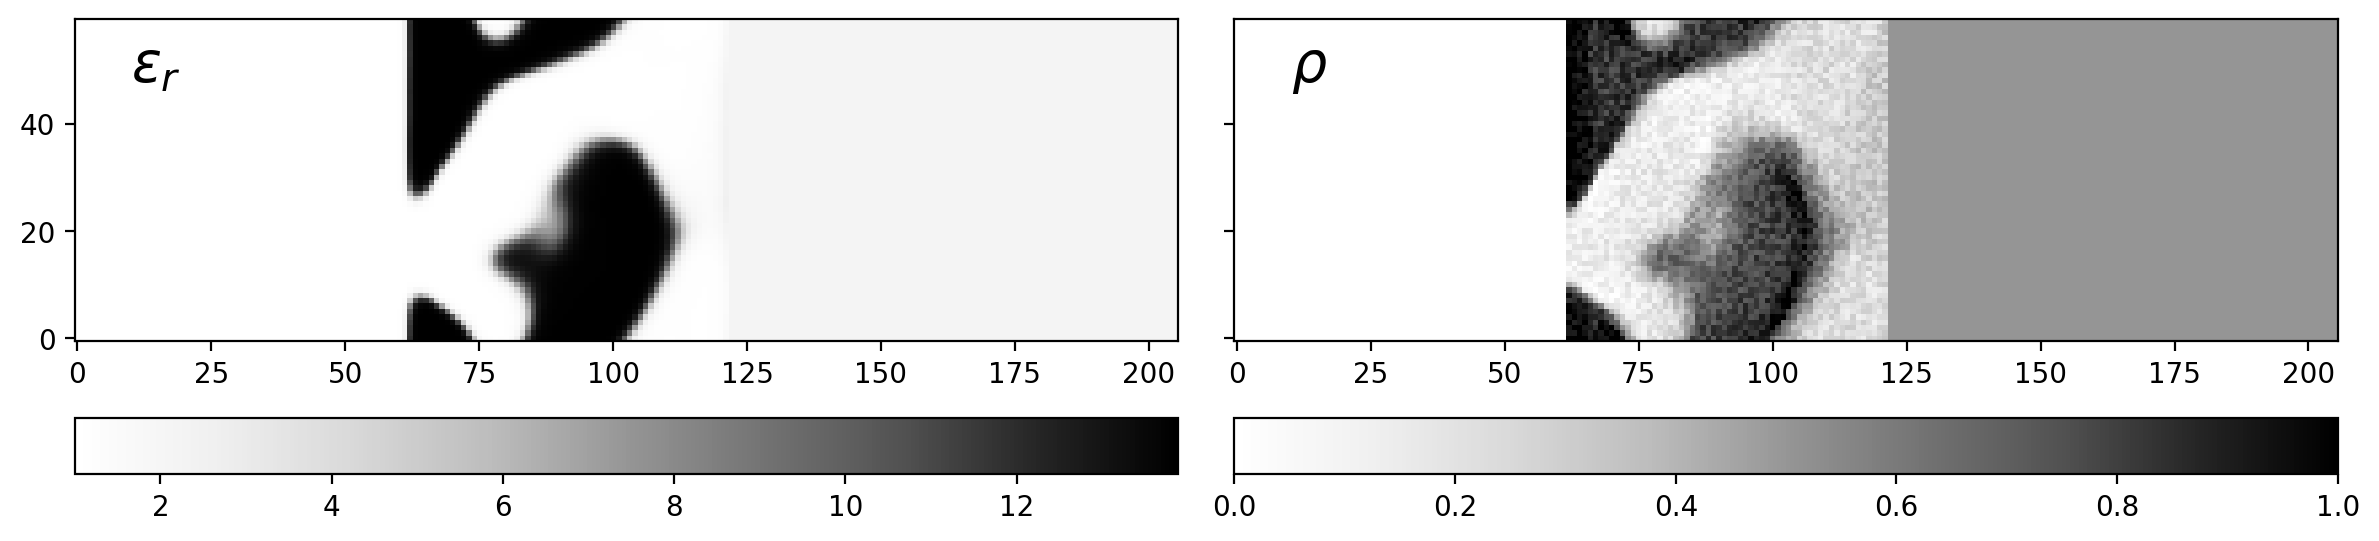

Epoch:  50/100 | Duration: 2.29 secs | Value: 5.152536e-02


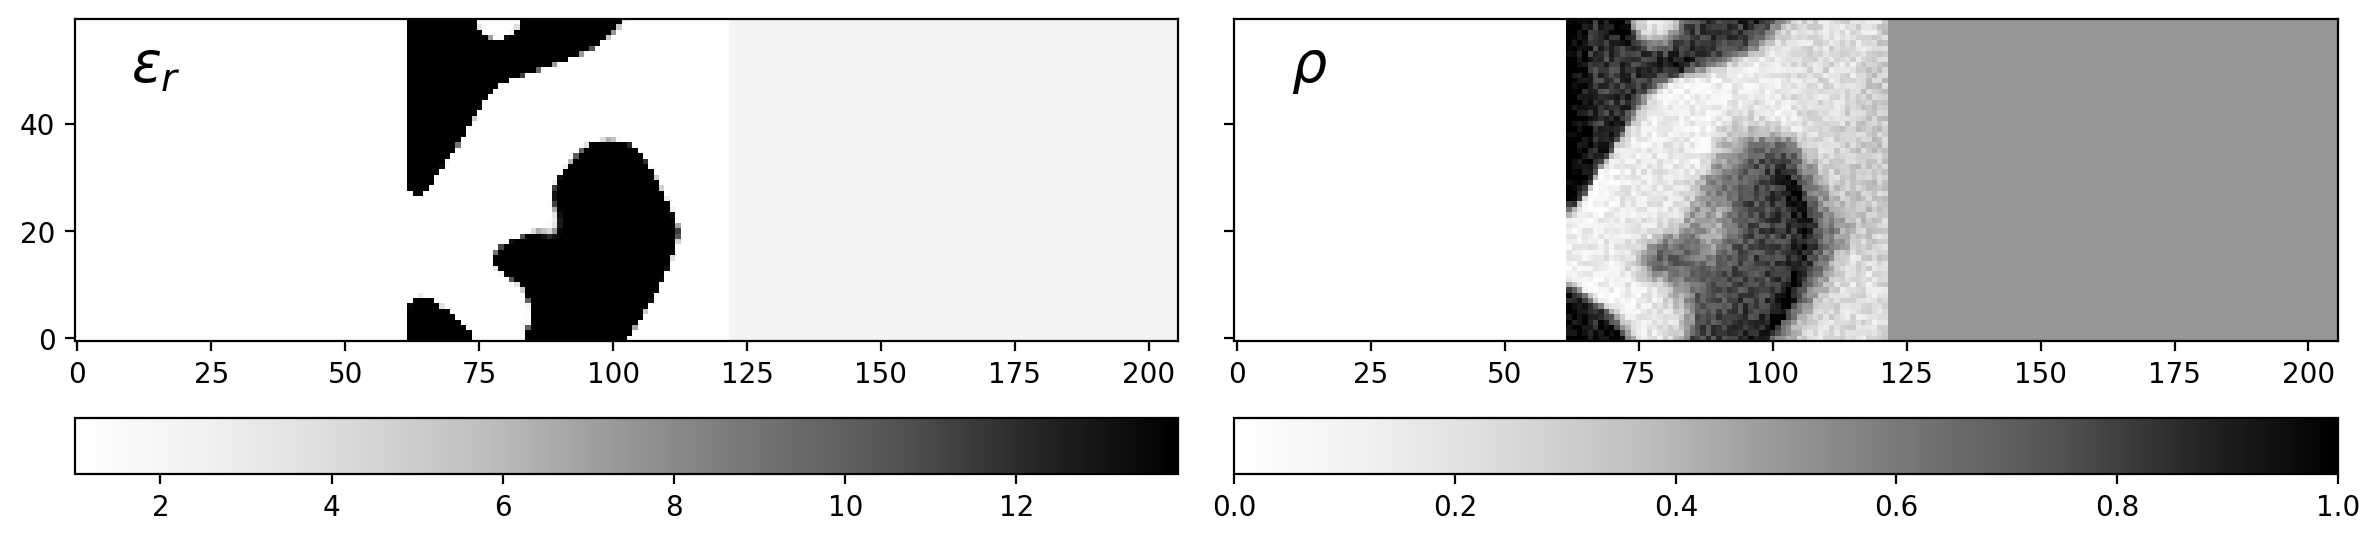

Epoch:  51/100 | Duration: 2.52 secs | Value: 4.775667e-02


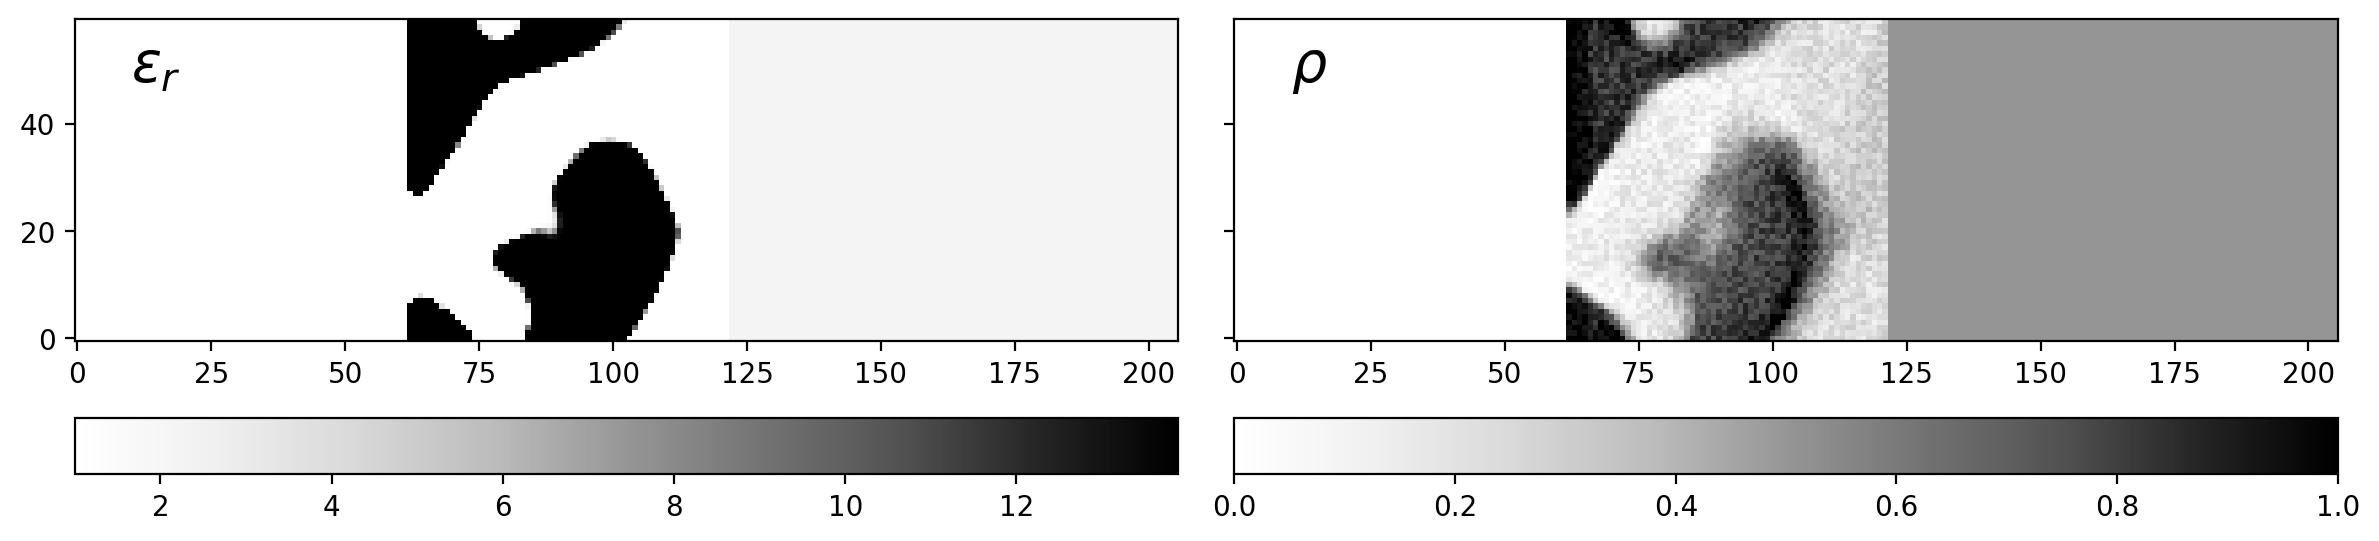

Epoch:  52/100 | Duration: 2.39 secs | Value: 4.790031e-02


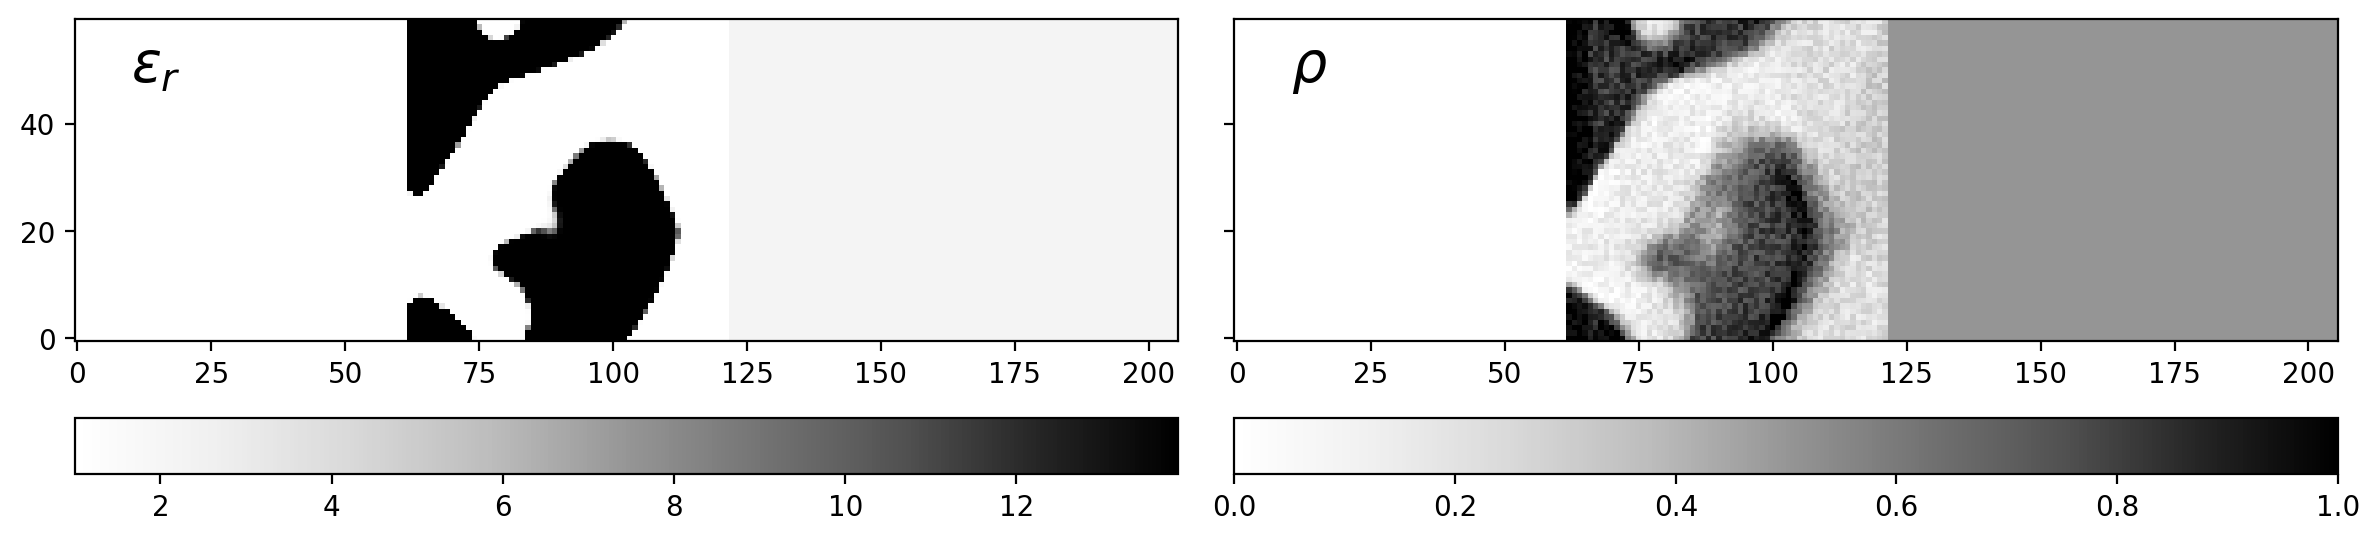

Epoch:  53/100 | Duration: 2.22 secs | Value: 4.812369e-02


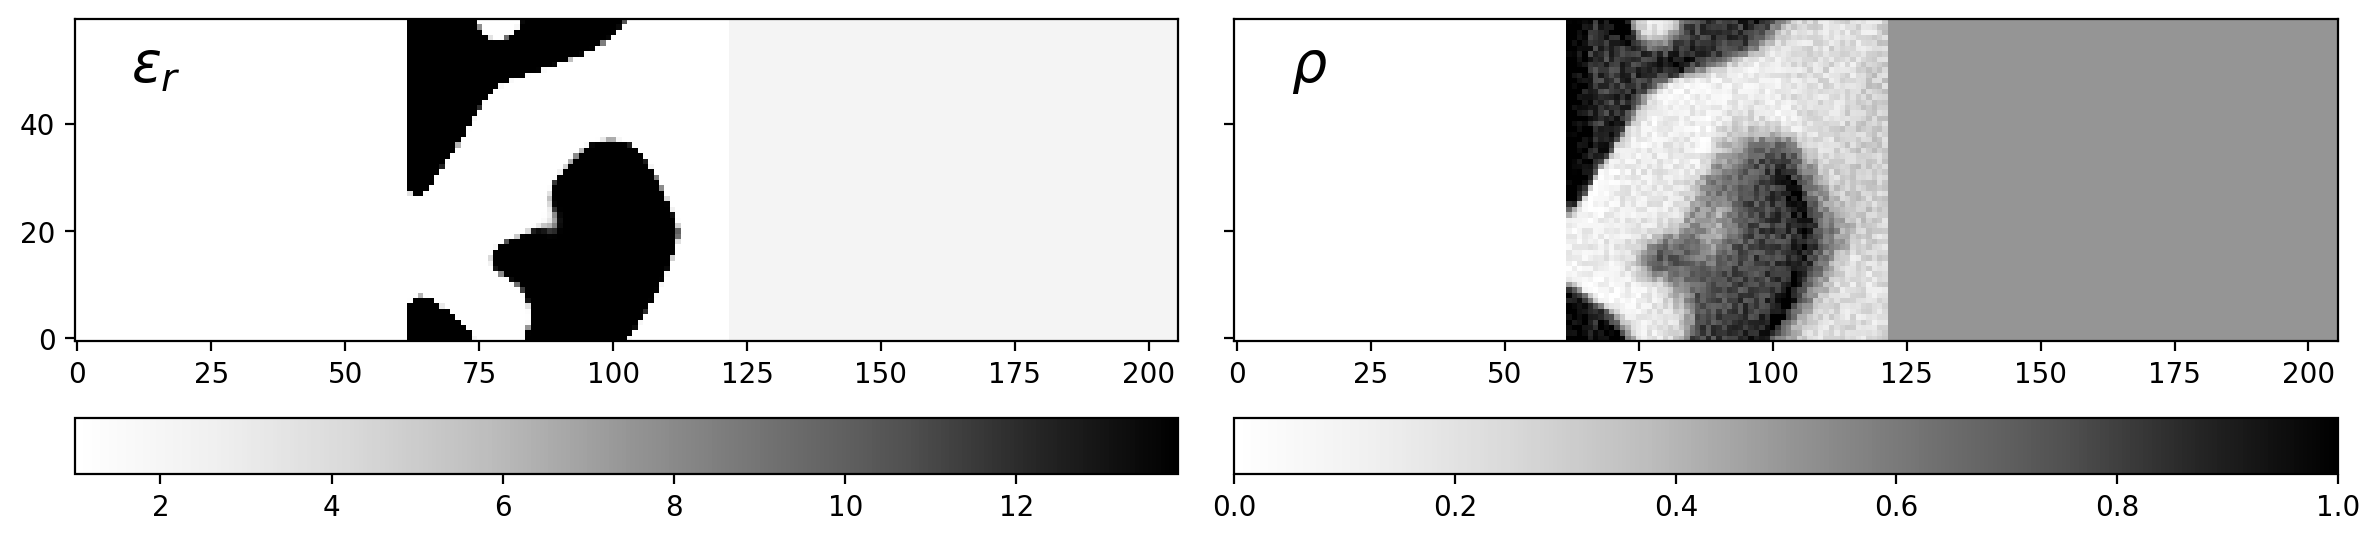

Epoch:  54/100 | Duration: 2.48 secs | Value: 4.846099e-02


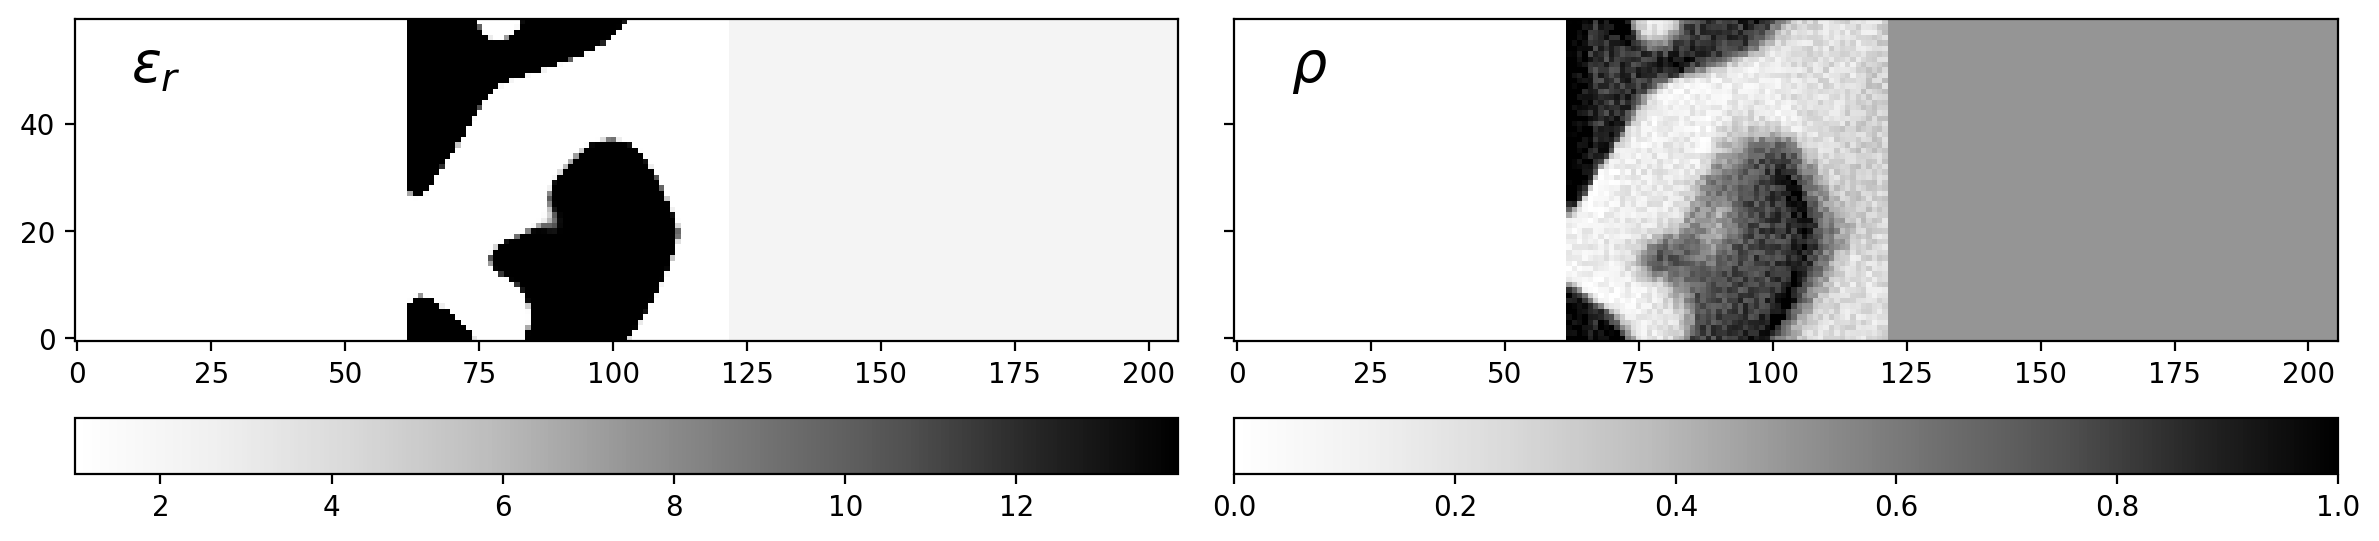

Epoch:  55/100 | Duration: 2.08 secs | Value: 4.877947e-02


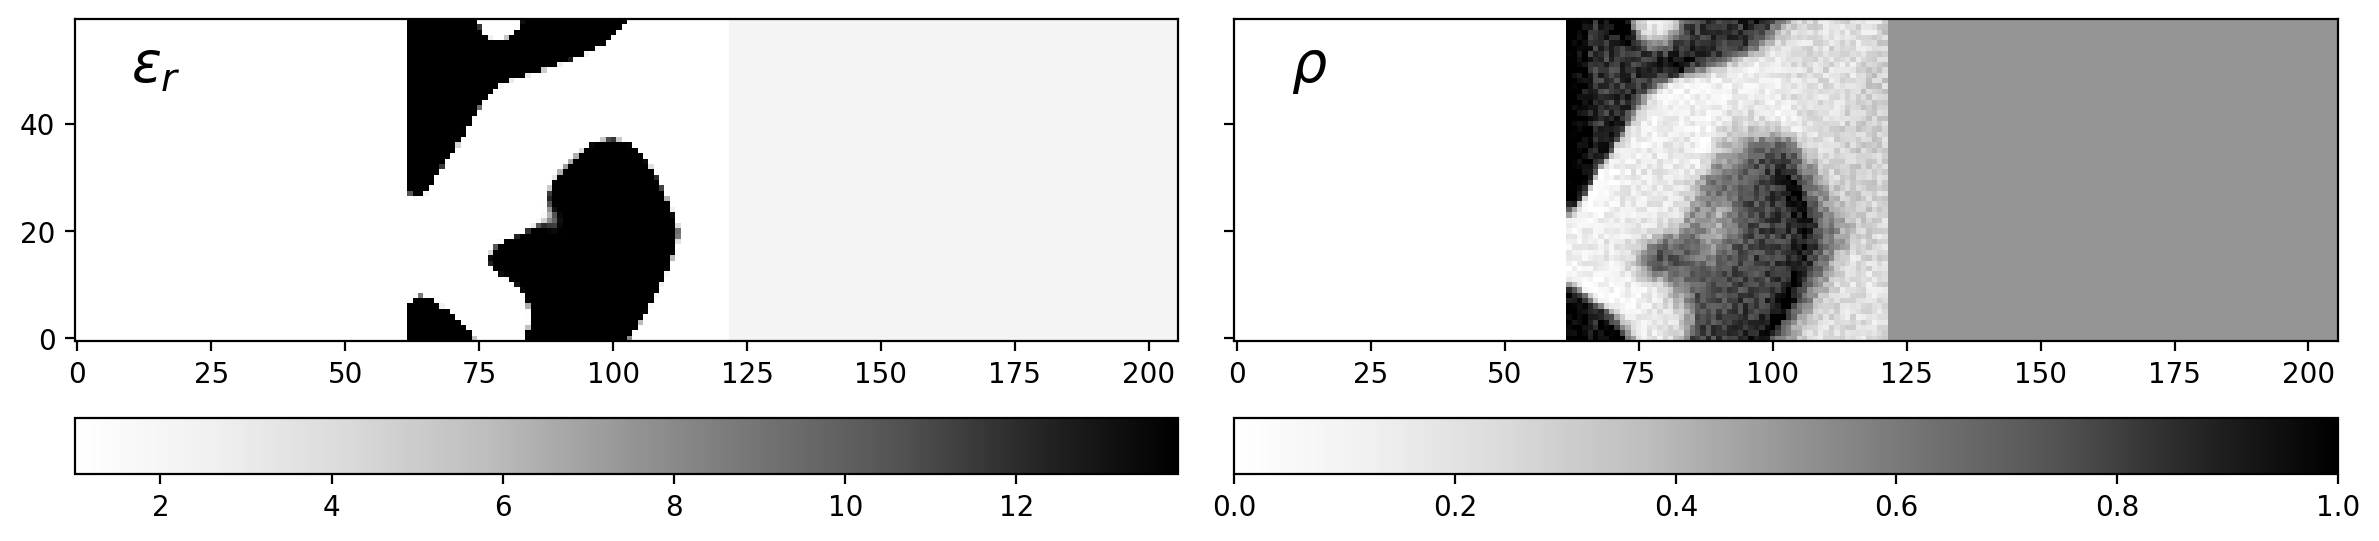

Epoch:  56/100 | Duration: 2.11 secs | Value: 4.897679e-02


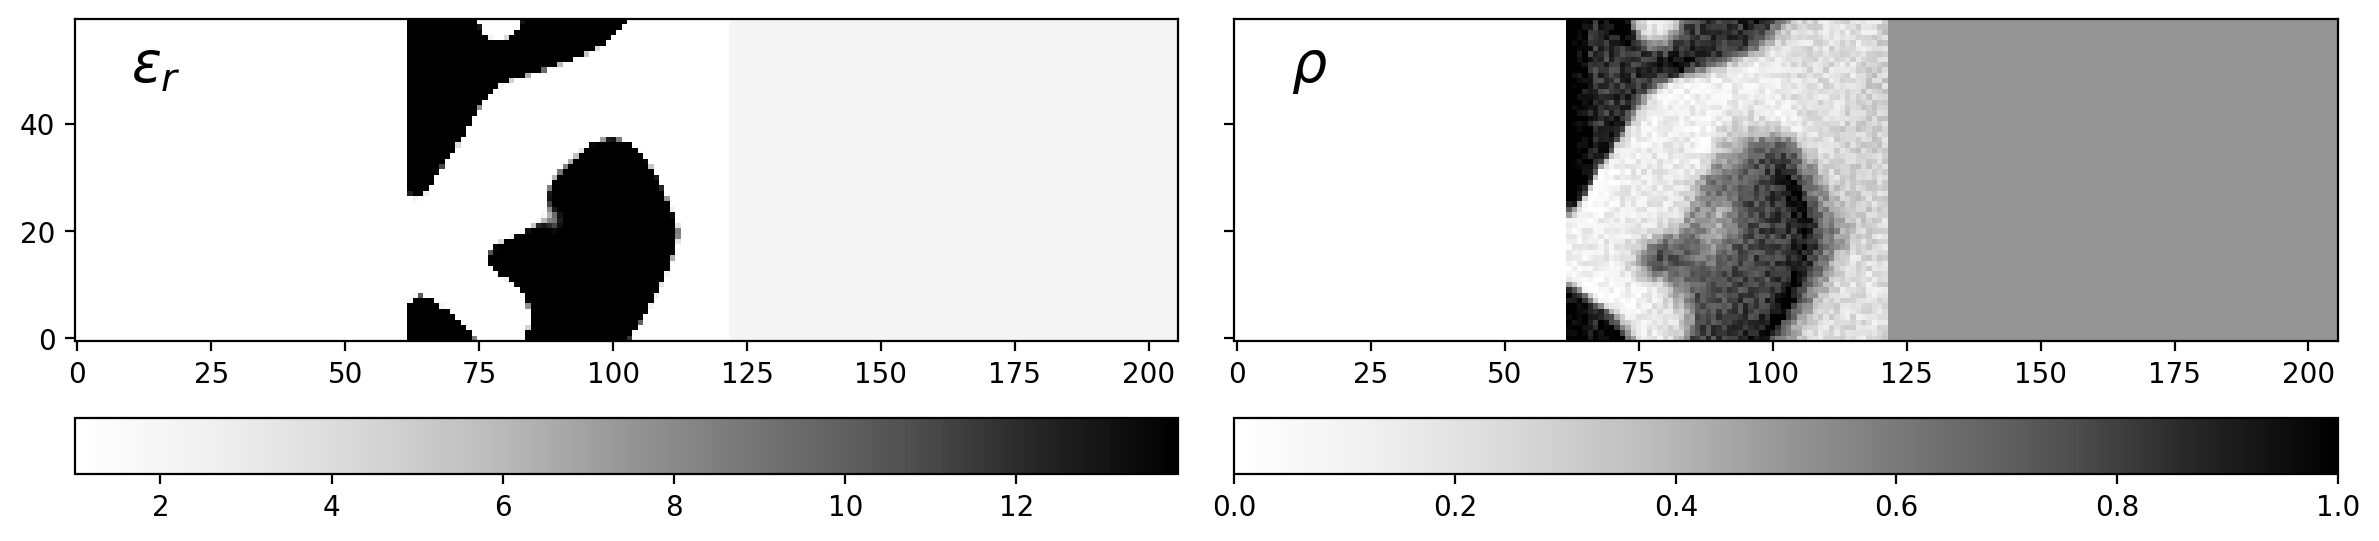

Epoch:  57/100 | Duration: 2.46 secs | Value: 4.910629e-02


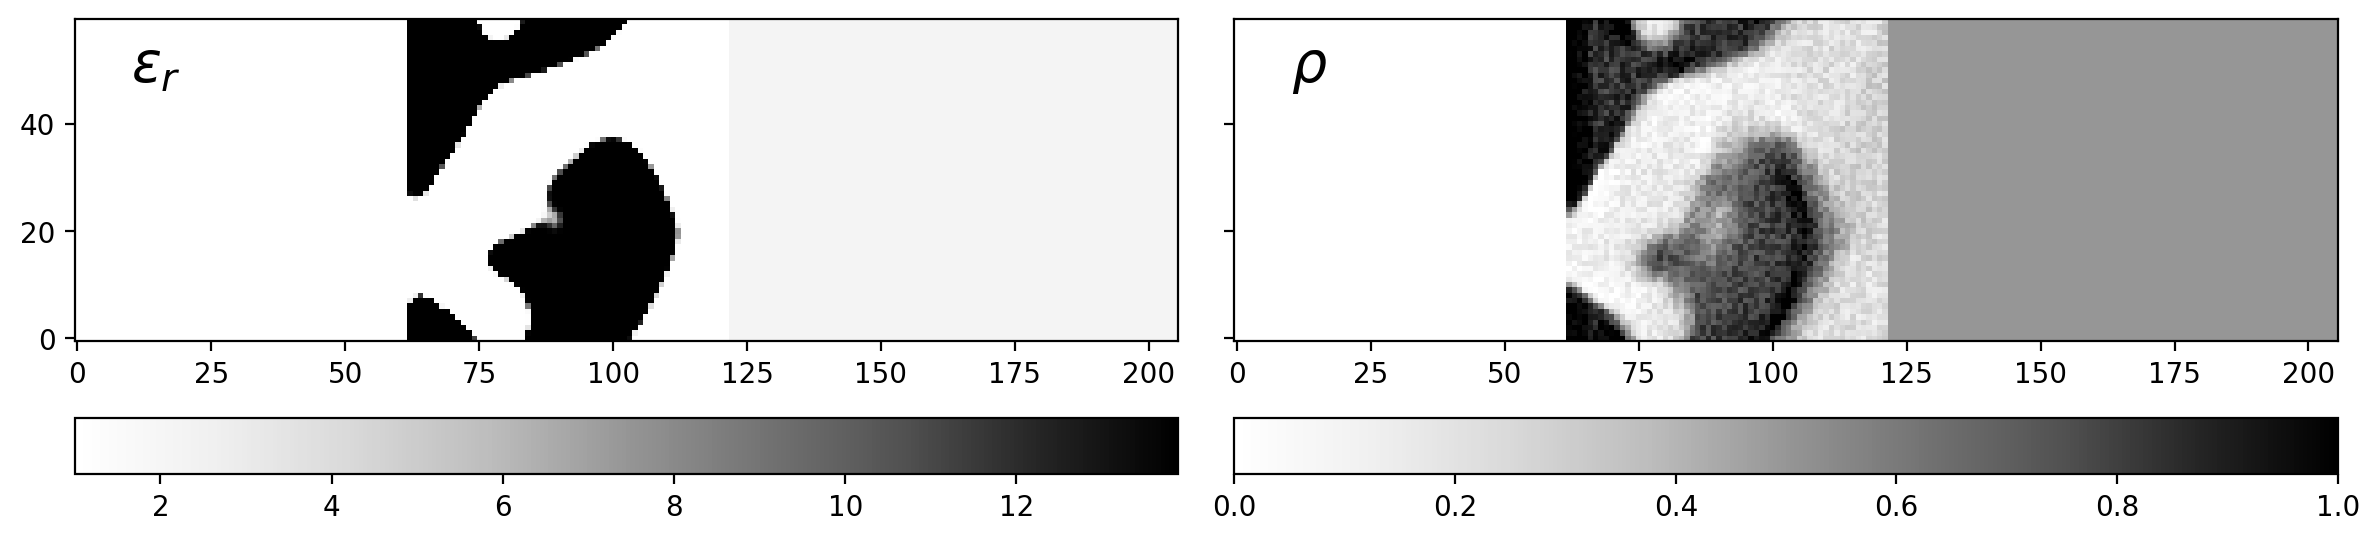

Epoch:  58/100 | Duration: 2.51 secs | Value: 4.924090e-02


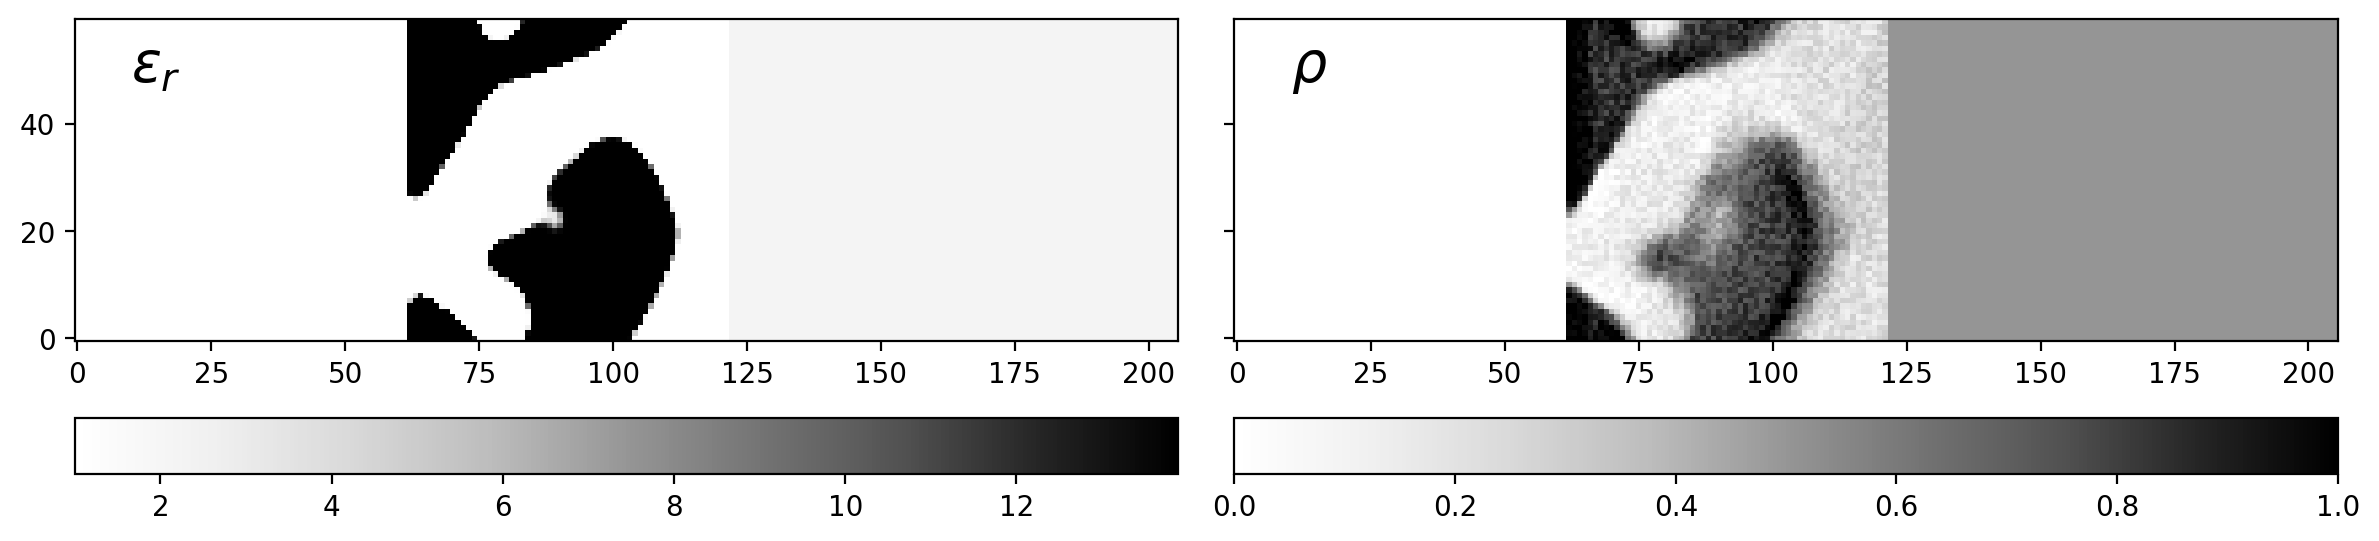

Epoch:  59/100 | Duration: 2.36 secs | Value: 4.942154e-02


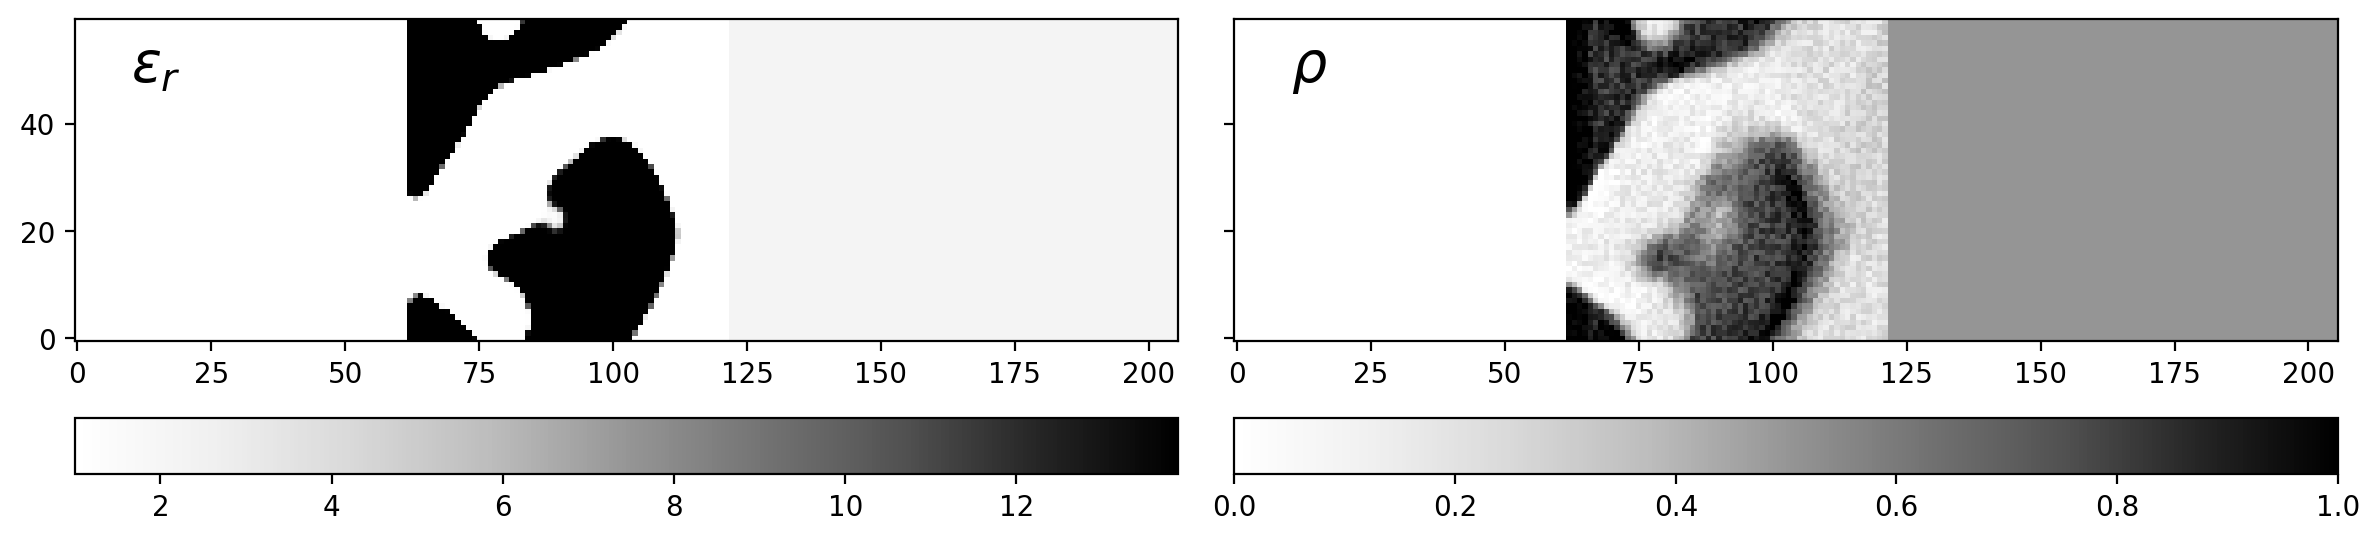

Epoch:  60/100 | Duration: 2.26 secs | Value: 4.962496e-02


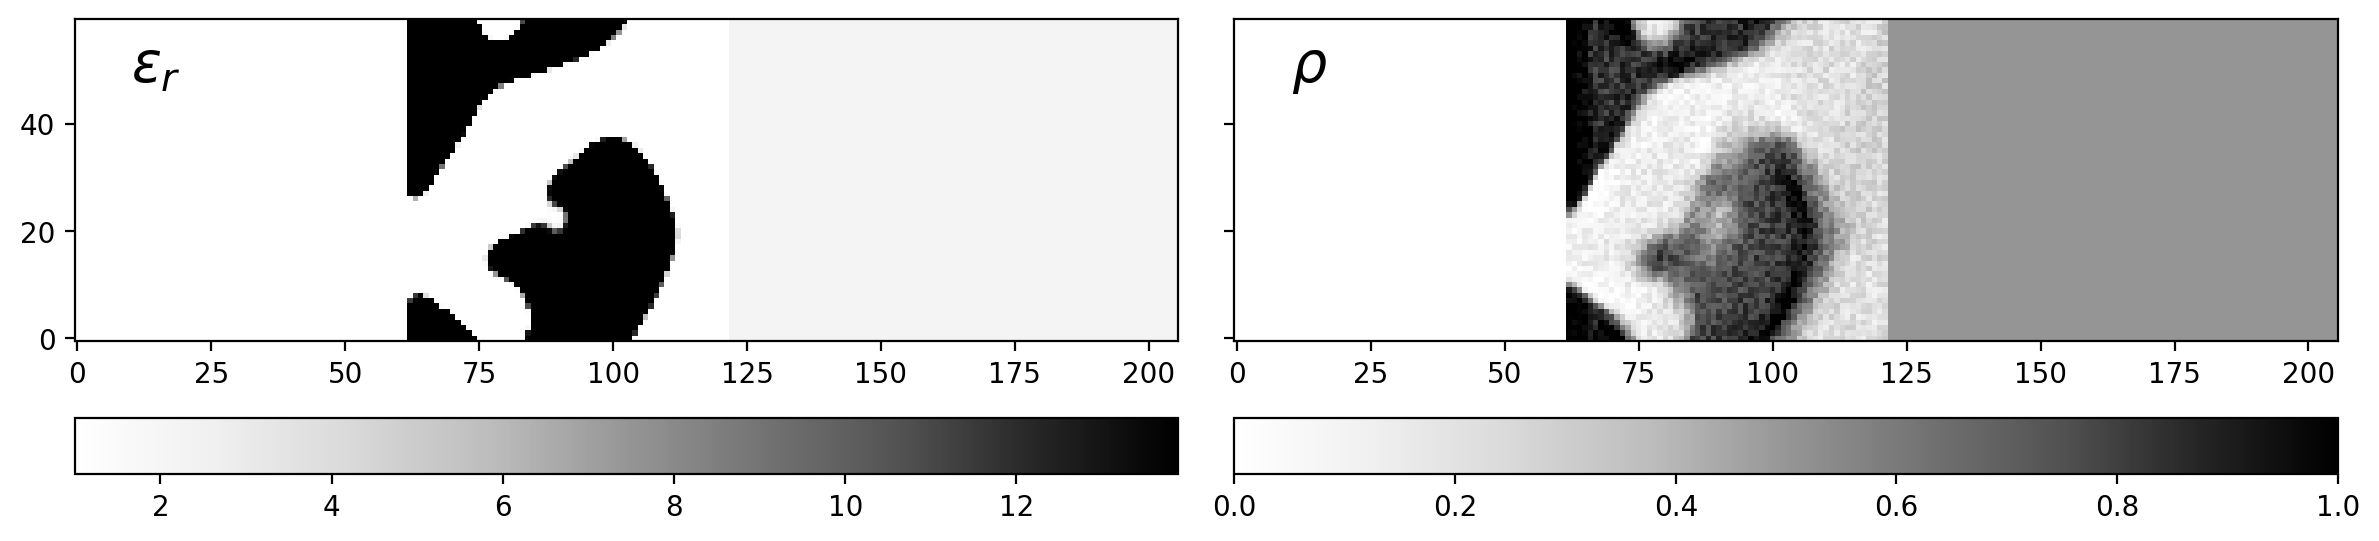

Epoch:  61/100 | Duration: 2.14 secs | Value: 4.984431e-02


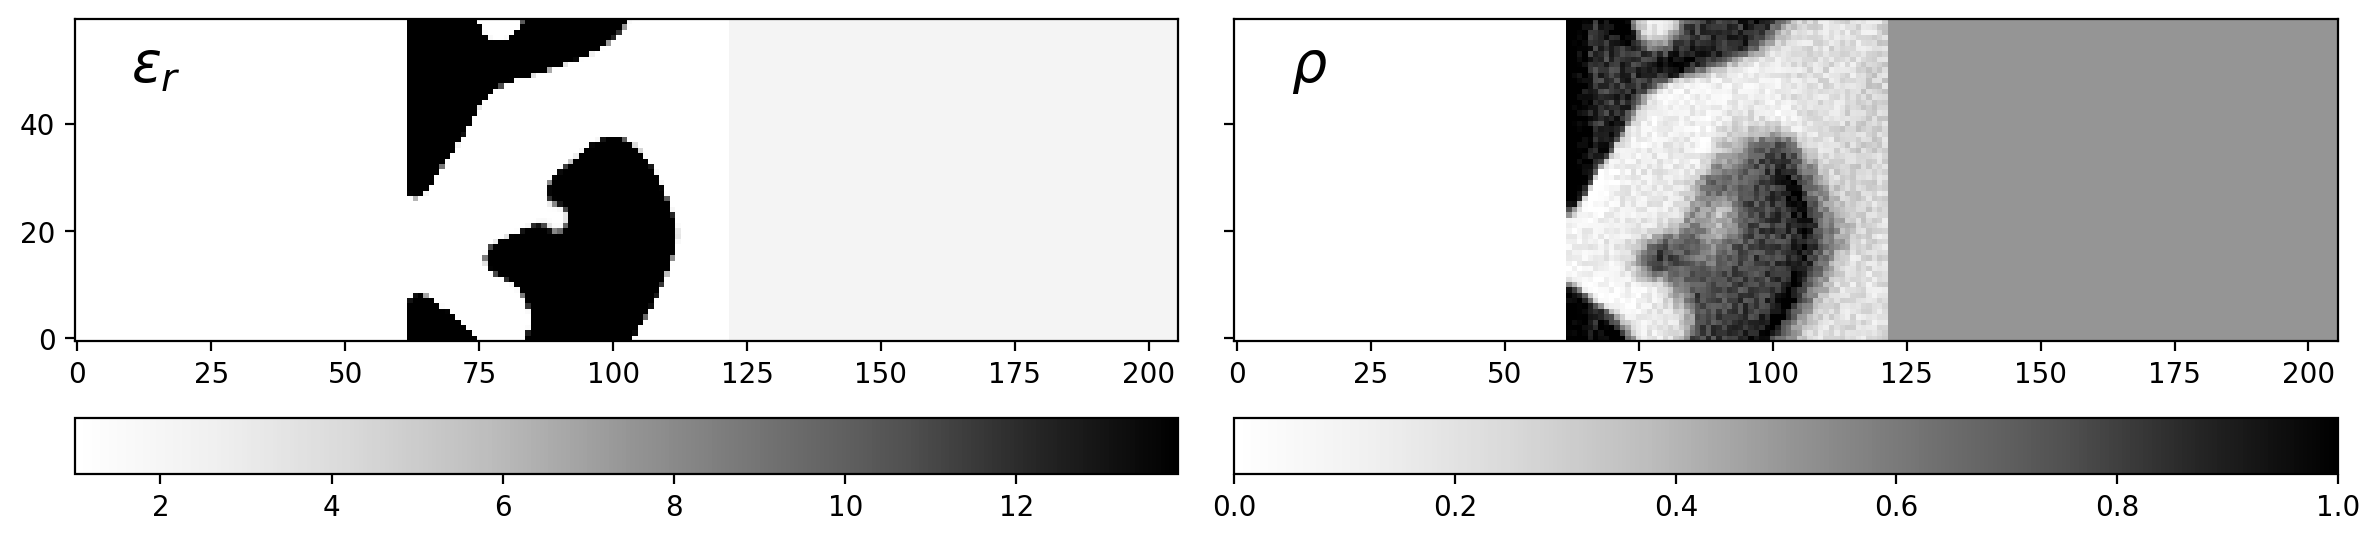

Epoch:  62/100 | Duration: 2.25 secs | Value: 5.006636e-02


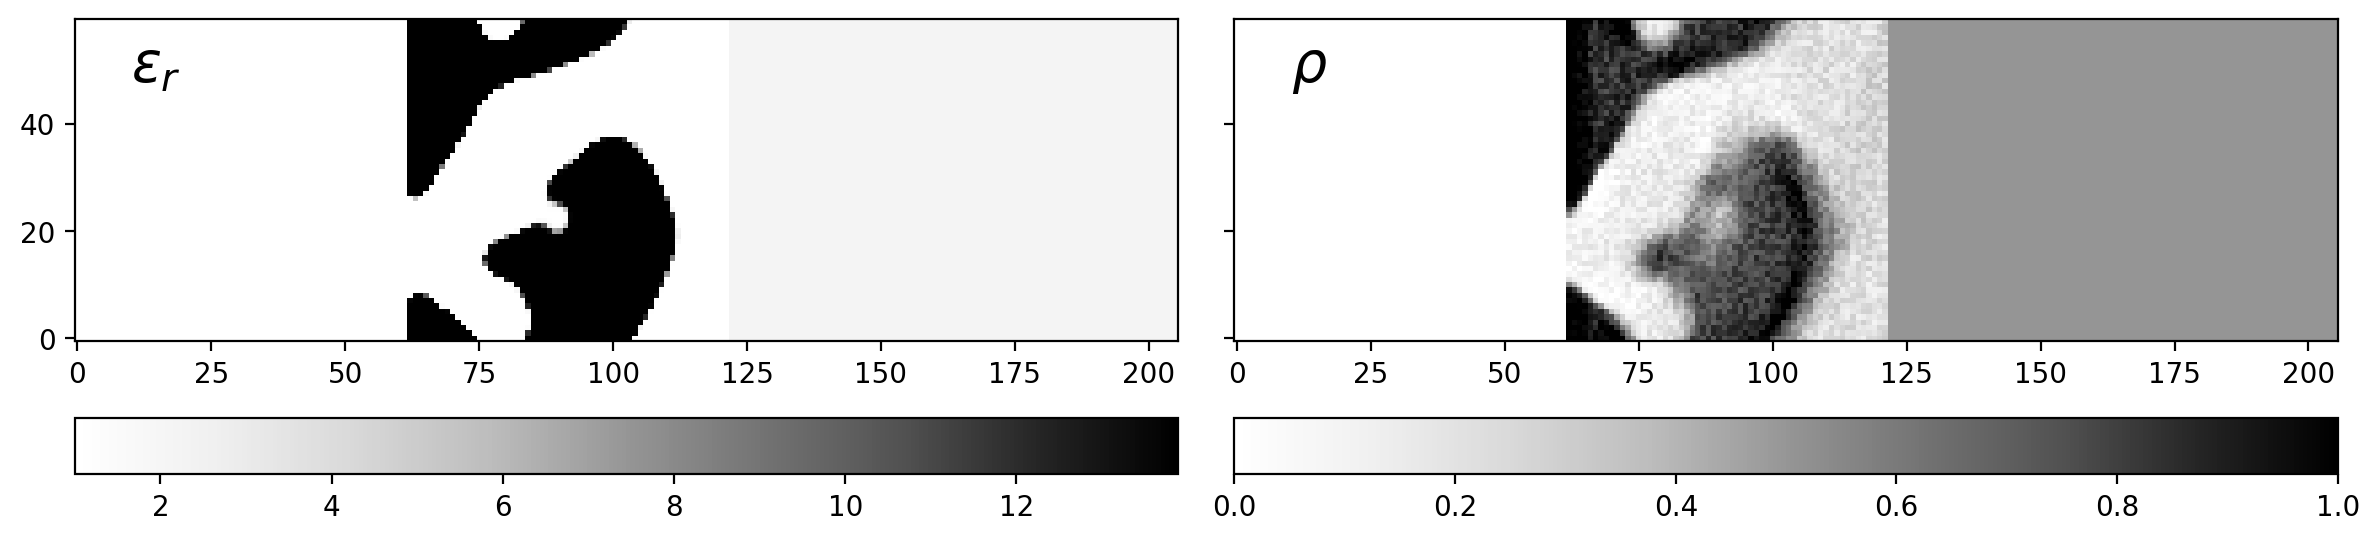

Epoch:  63/100 | Duration: 2.21 secs | Value: 5.021793e-02


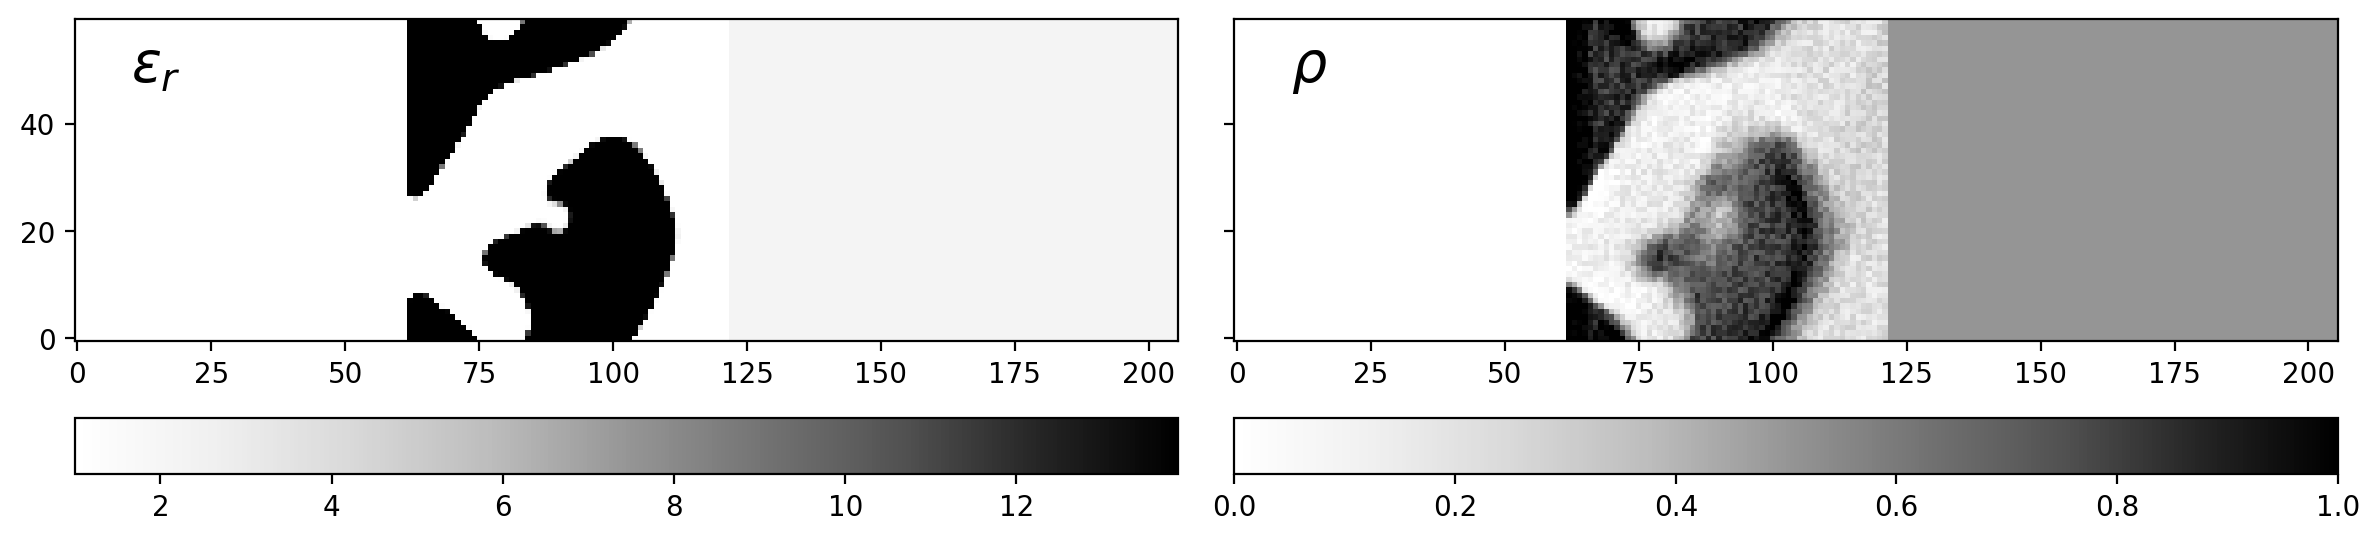

Epoch:  64/100 | Duration: 2.12 secs | Value: 5.032733e-02


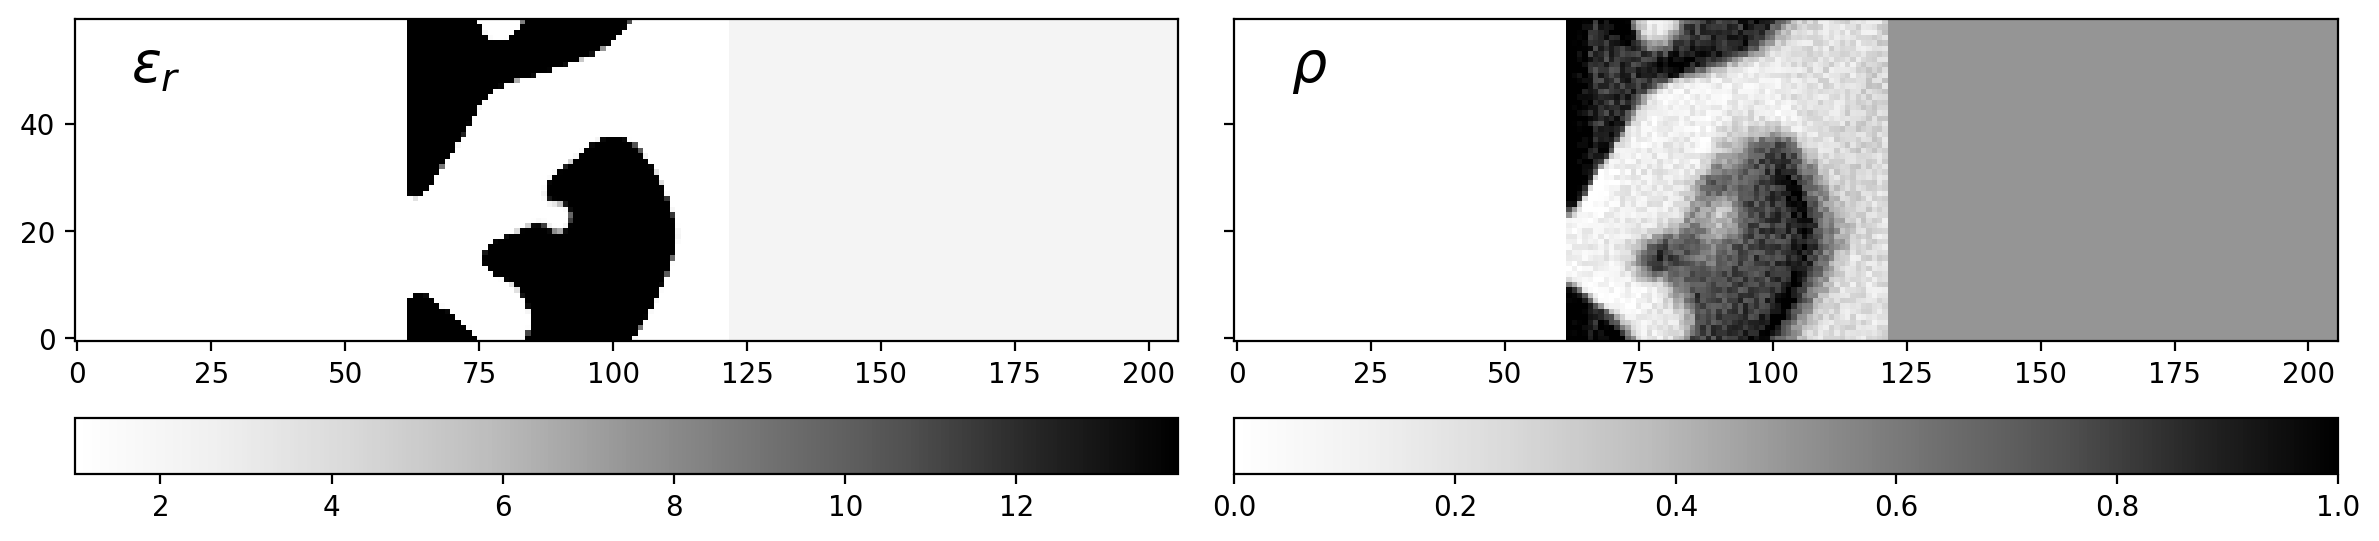

Epoch:  65/100 | Duration: 2.13 secs | Value: 5.042446e-02


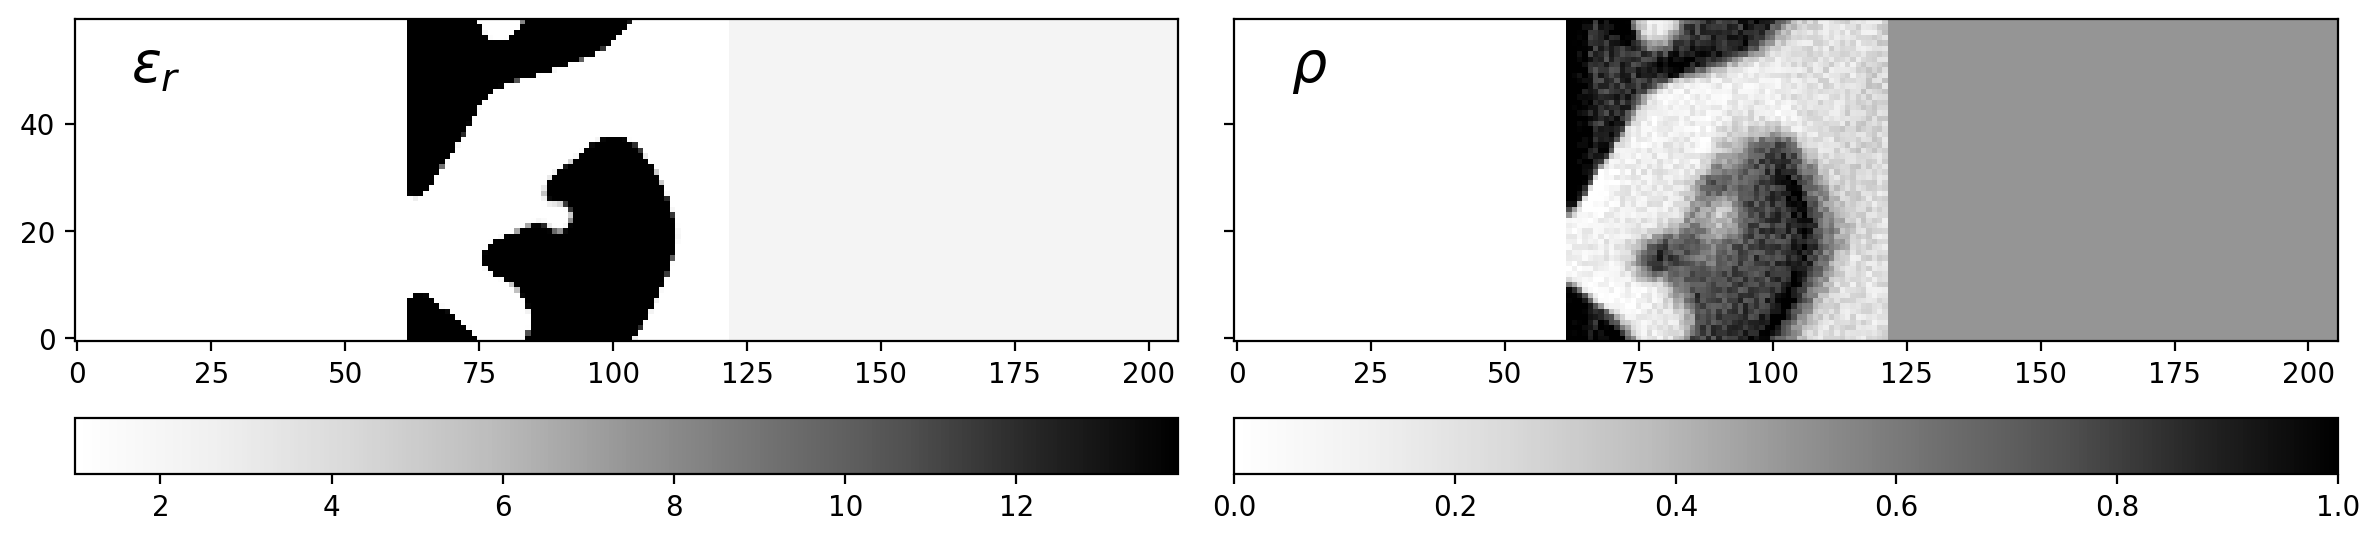

Epoch:  66/100 | Duration: 2.25 secs | Value: 5.053935e-02


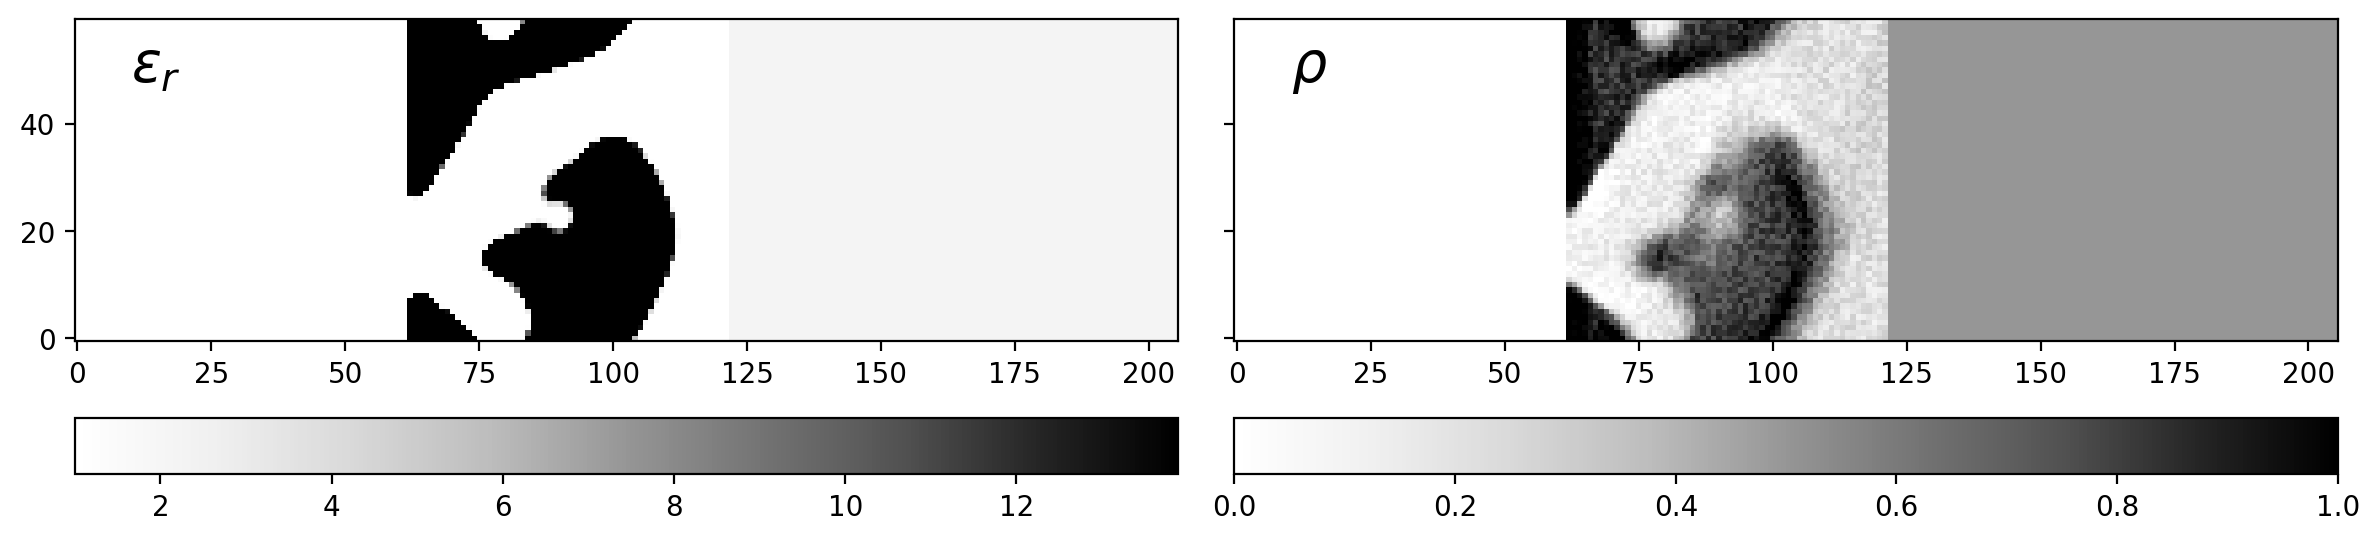

Epoch:  67/100 | Duration: 2.19 secs | Value: 5.064910e-02


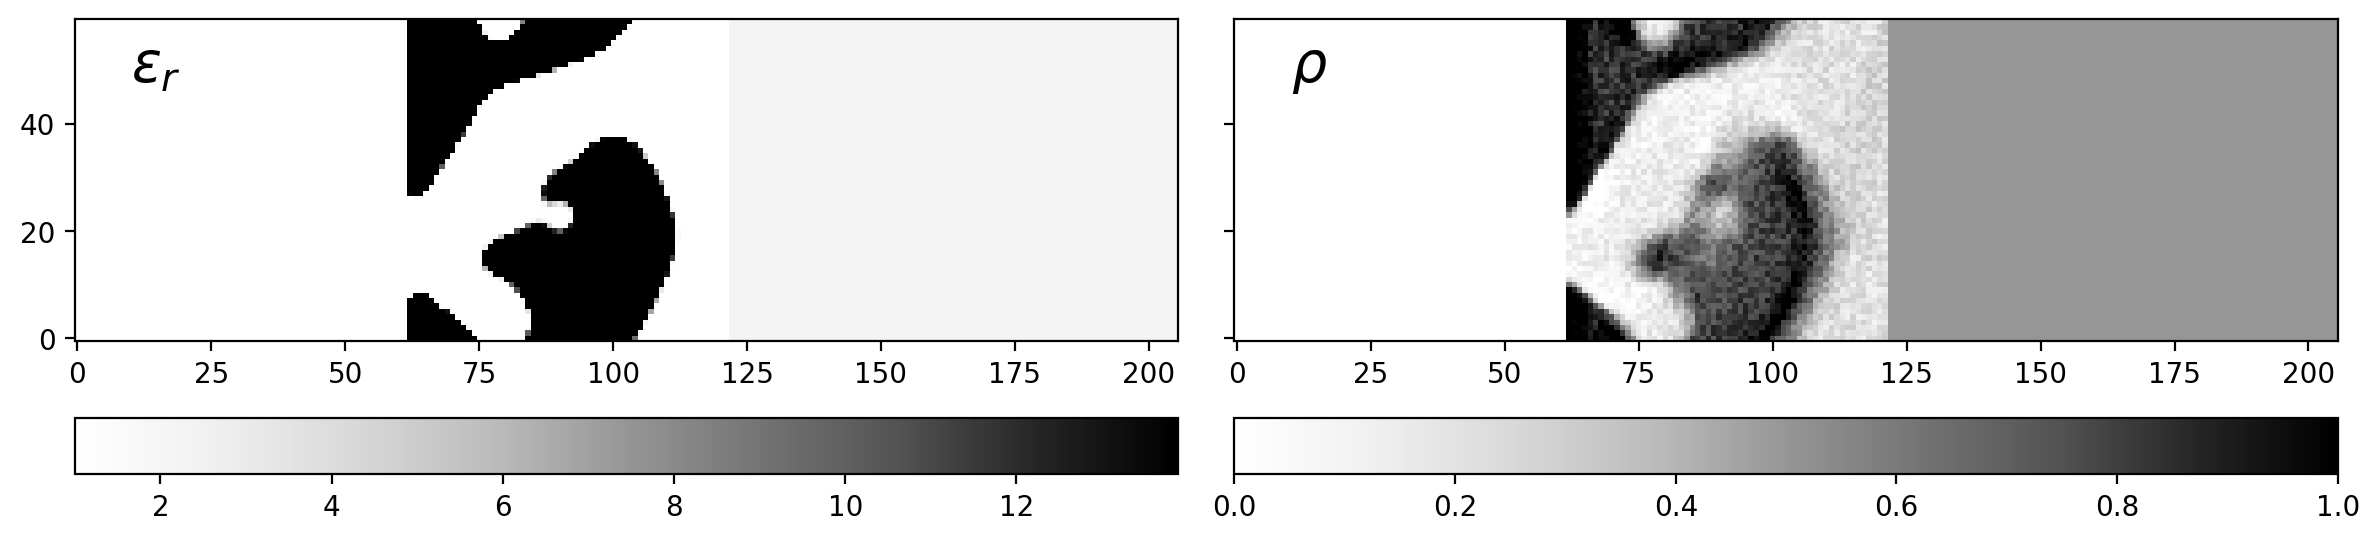

Epoch:  68/100 | Duration: 2.08 secs | Value: 5.073819e-02


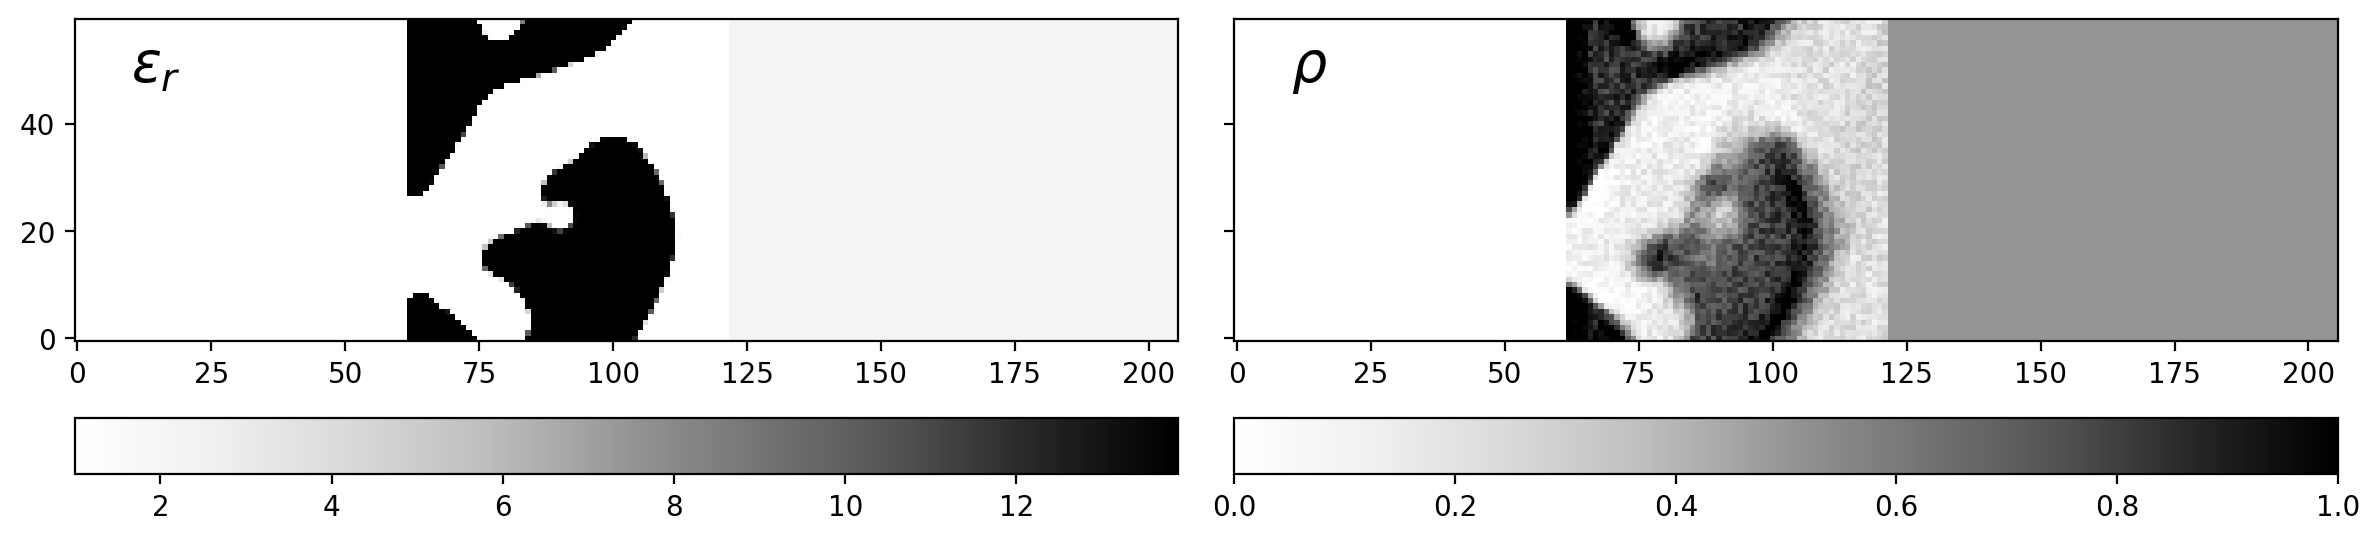

Epoch:  69/100 | Duration: 2.10 secs | Value: 5.081911e-02


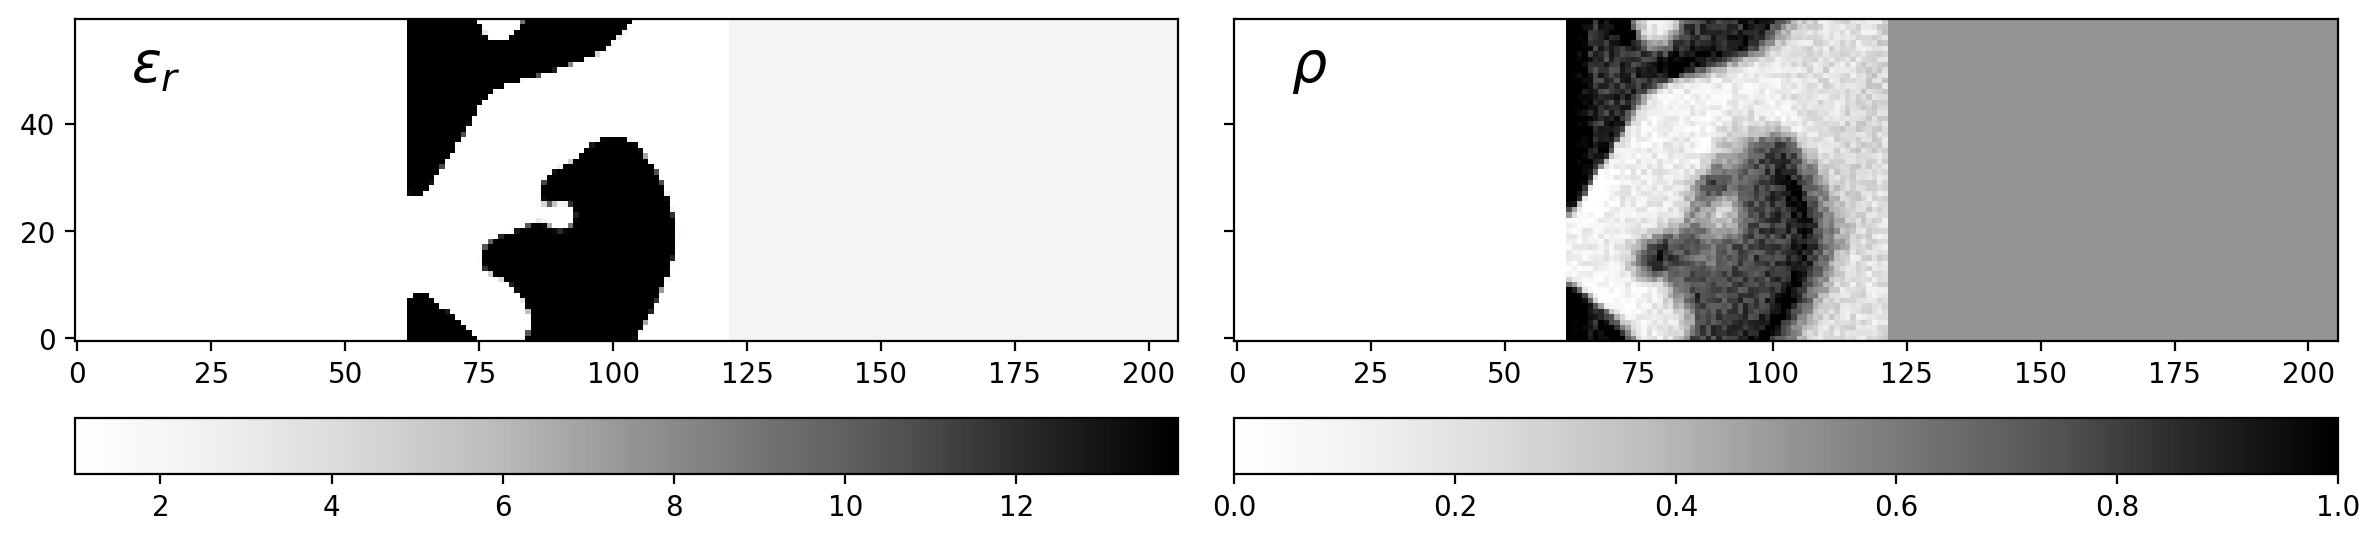

Epoch:  70/100 | Duration: 2.18 secs | Value: 5.089389e-02


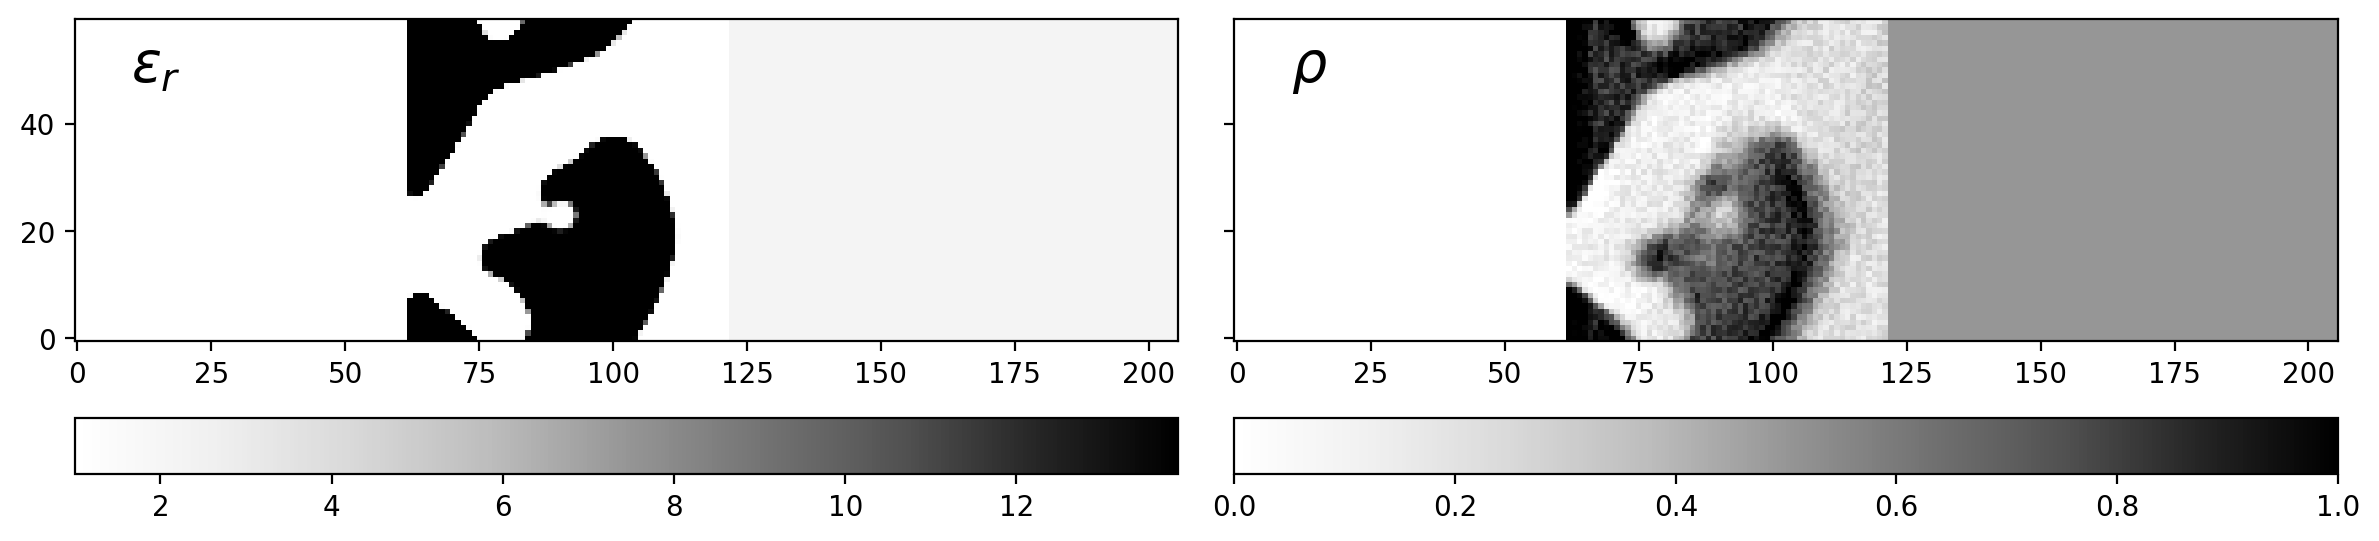

Epoch:  71/100 | Duration: 2.32 secs | Value: 5.100358e-02


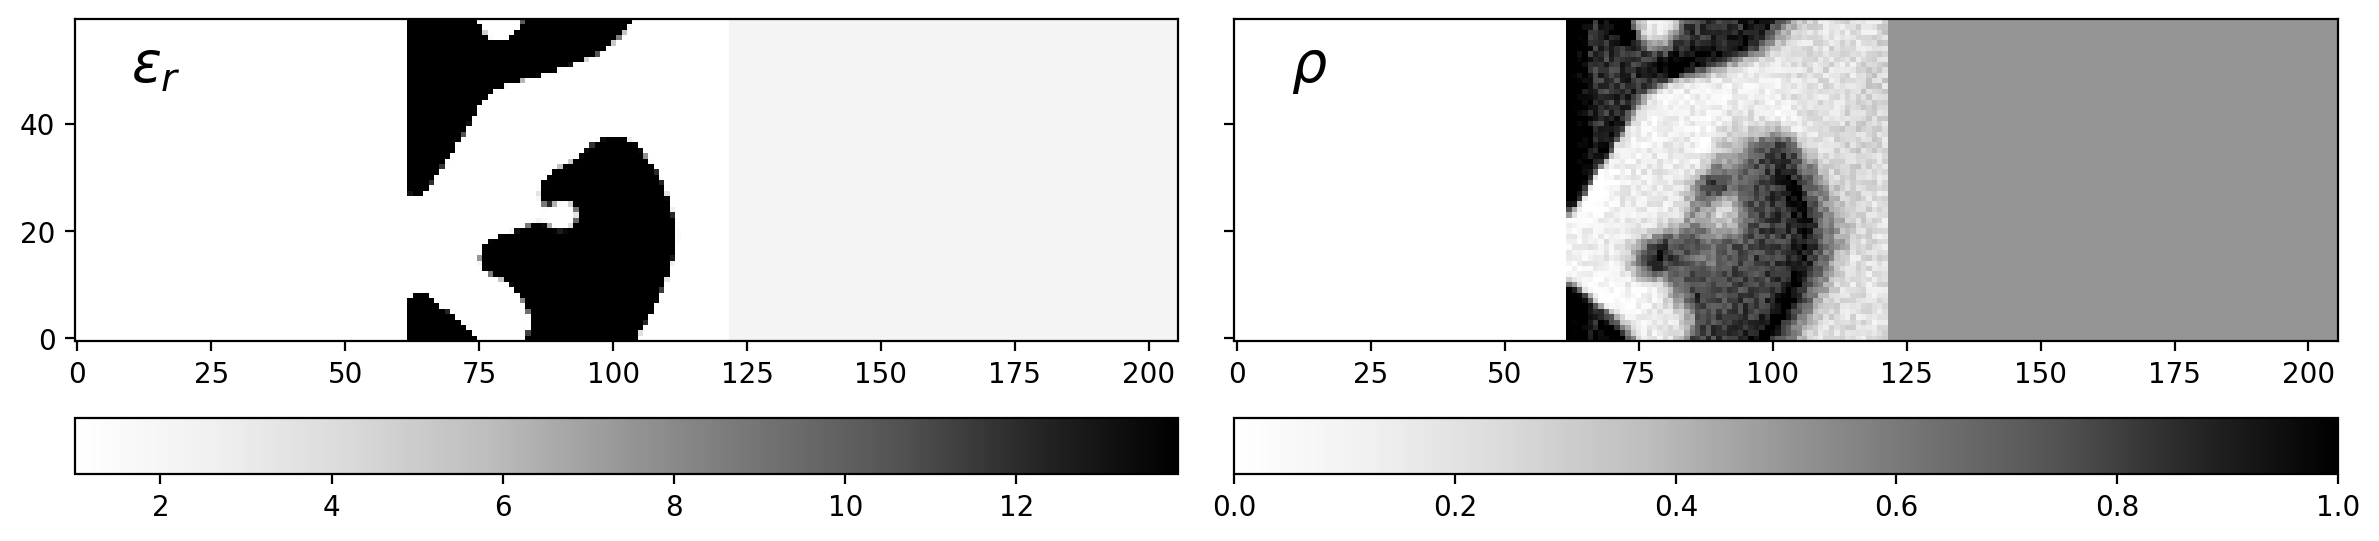

Epoch:  72/100 | Duration: 2.27 secs | Value: 5.116647e-02


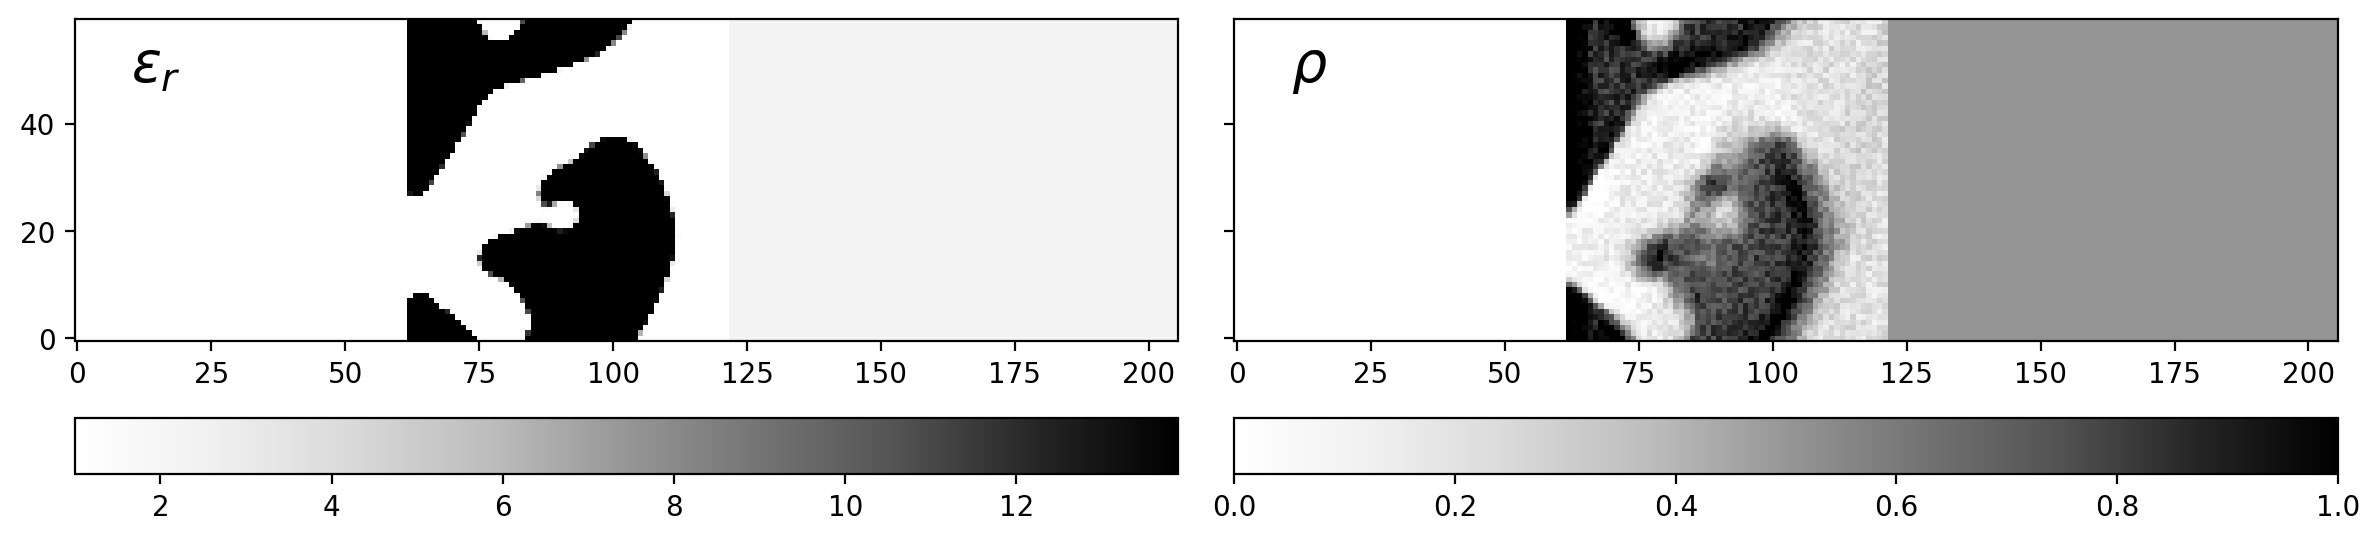

Epoch:  73/100 | Duration: 2.10 secs | Value: 5.131508e-02


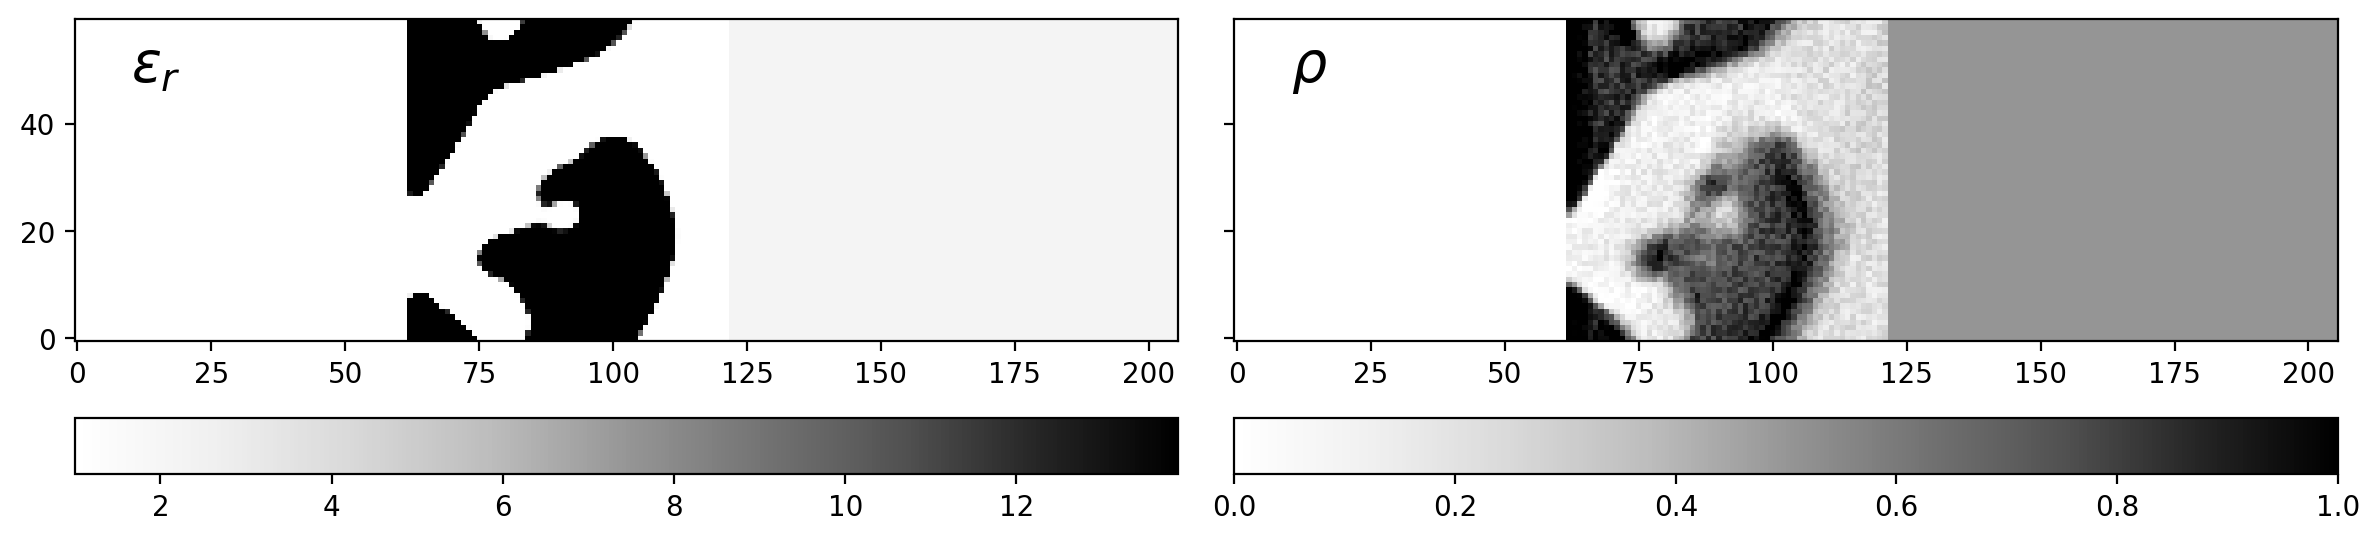

Epoch:  74/100 | Duration: 2.24 secs | Value: 5.142431e-02


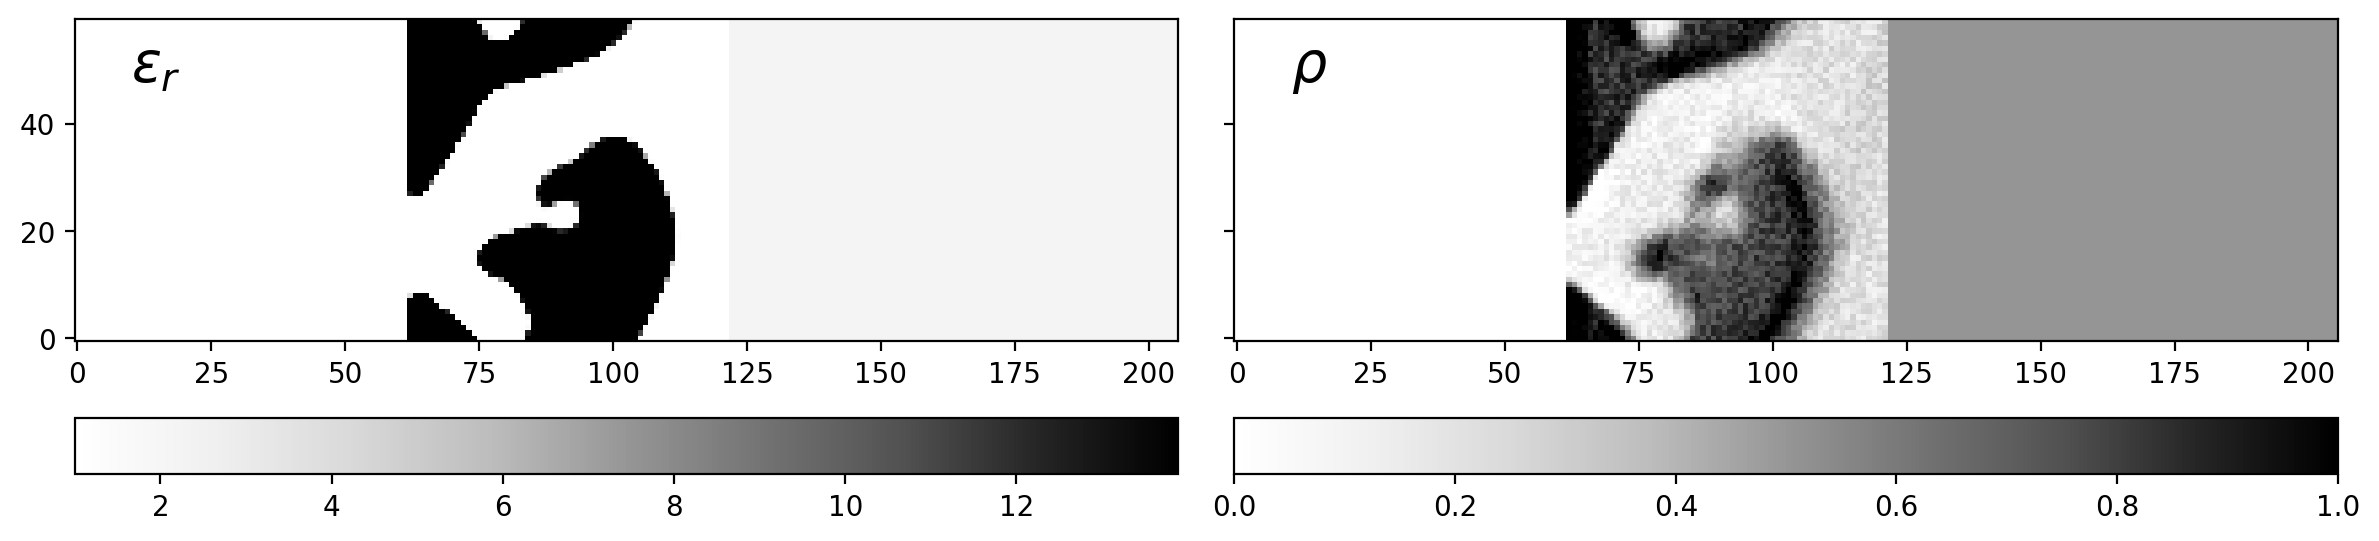

Epoch:  75/100 | Duration: 2.30 secs | Value: 5.148894e-02


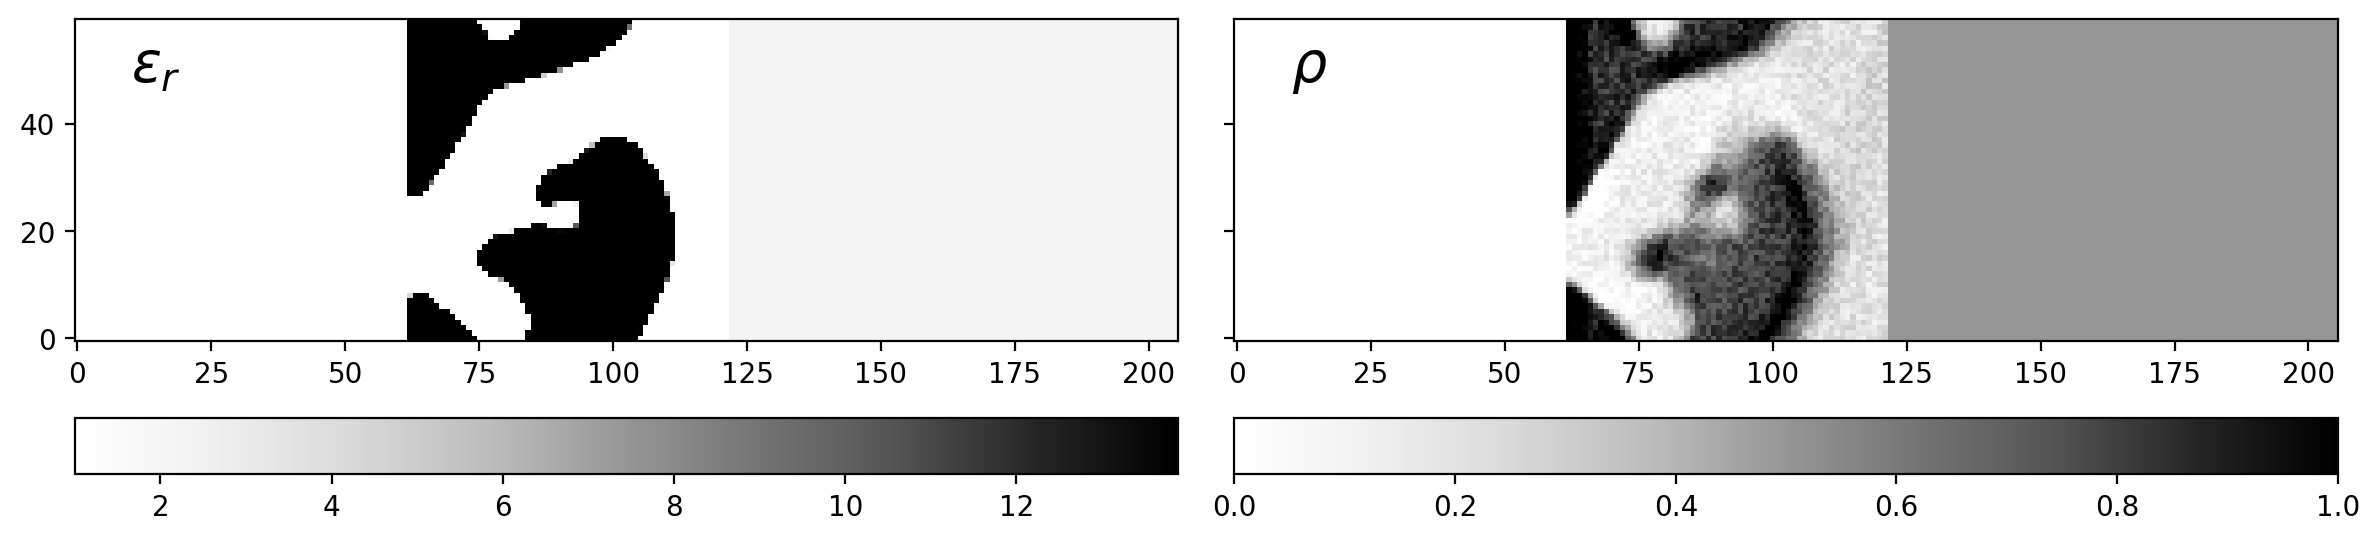

Epoch:  76/100 | Duration: 2.27 secs | Value: 5.155434e-02


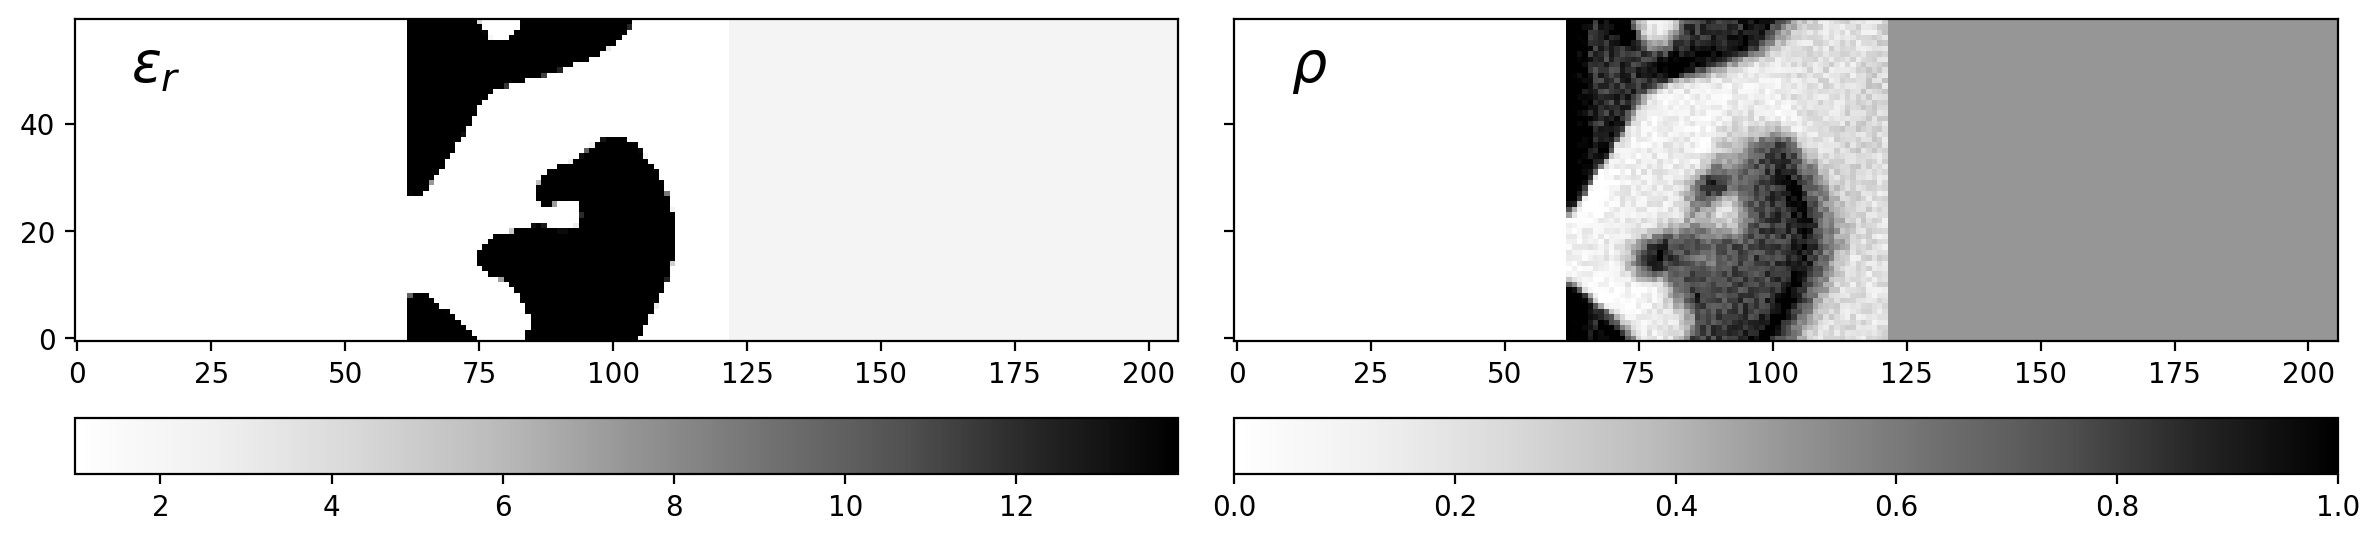

Epoch:  77/100 | Duration: 2.29 secs | Value: 5.165926e-02


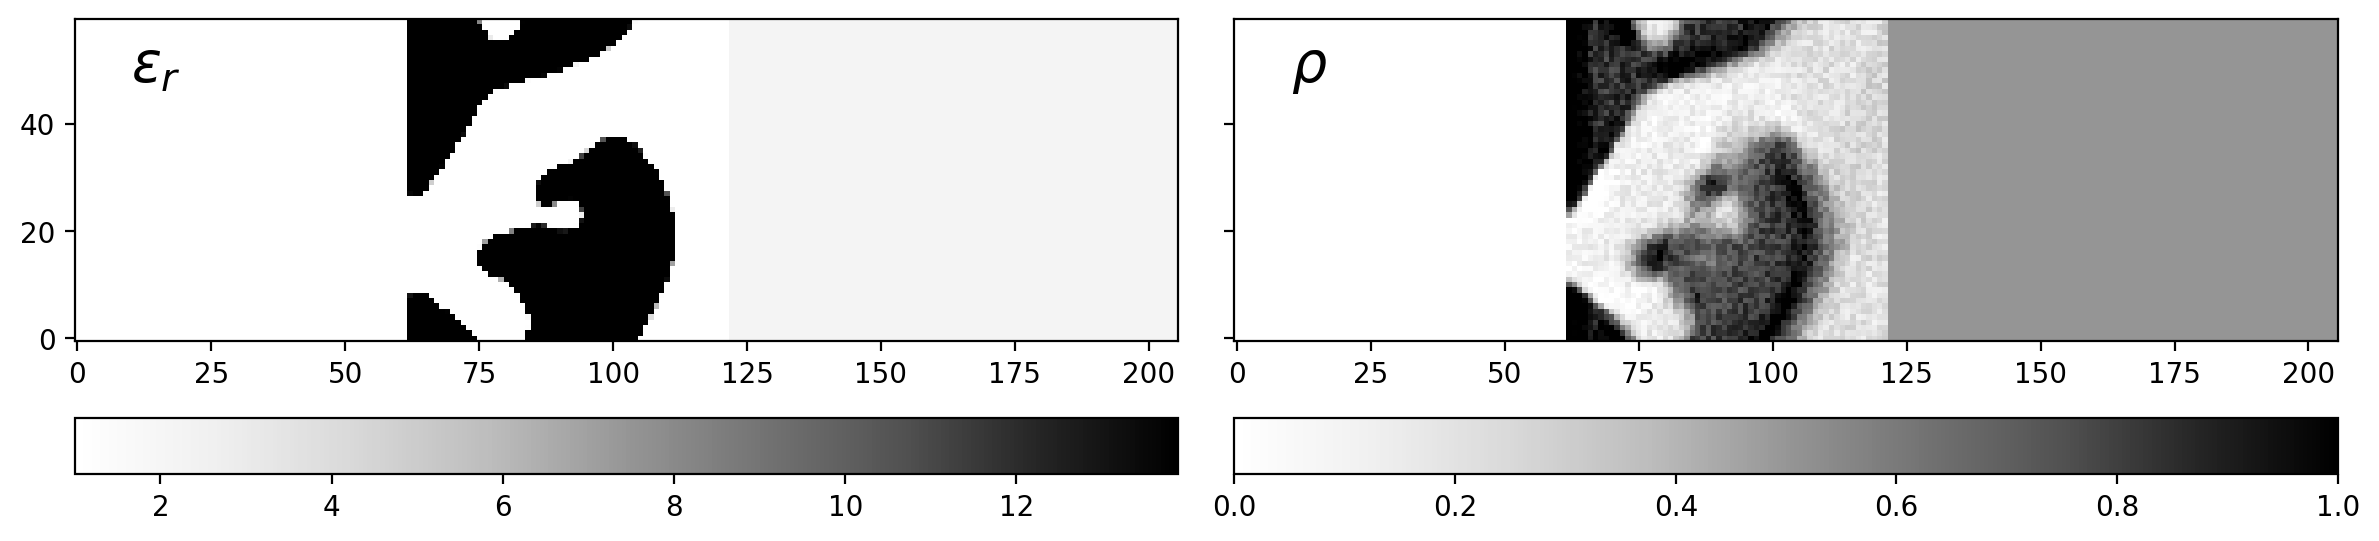

Epoch:  78/100 | Duration: 2.06 secs | Value: 5.175148e-02


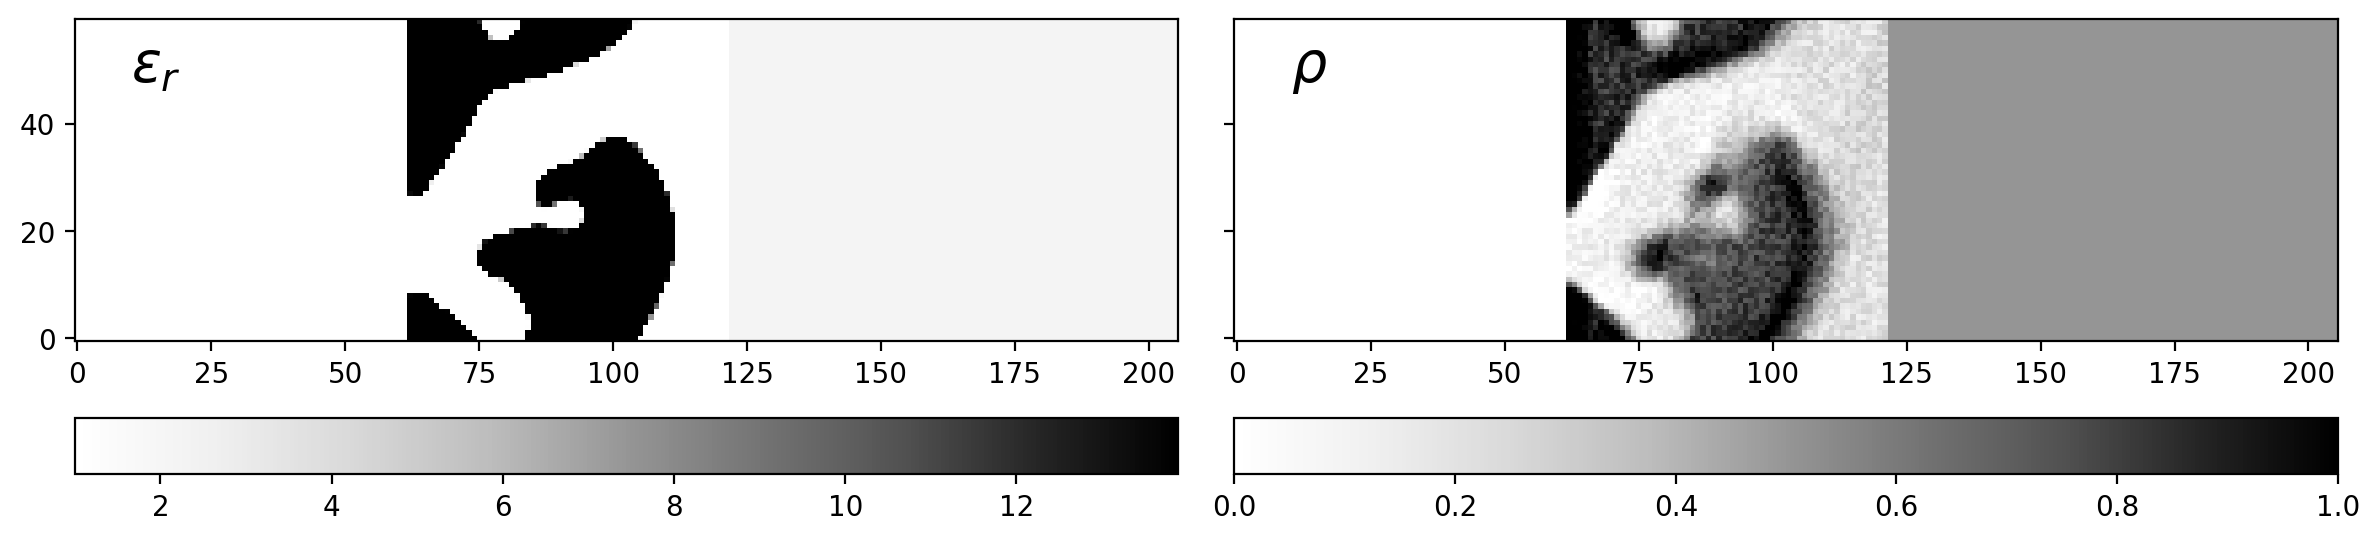

Epoch:  79/100 | Duration: 2.28 secs | Value: 5.184053e-02


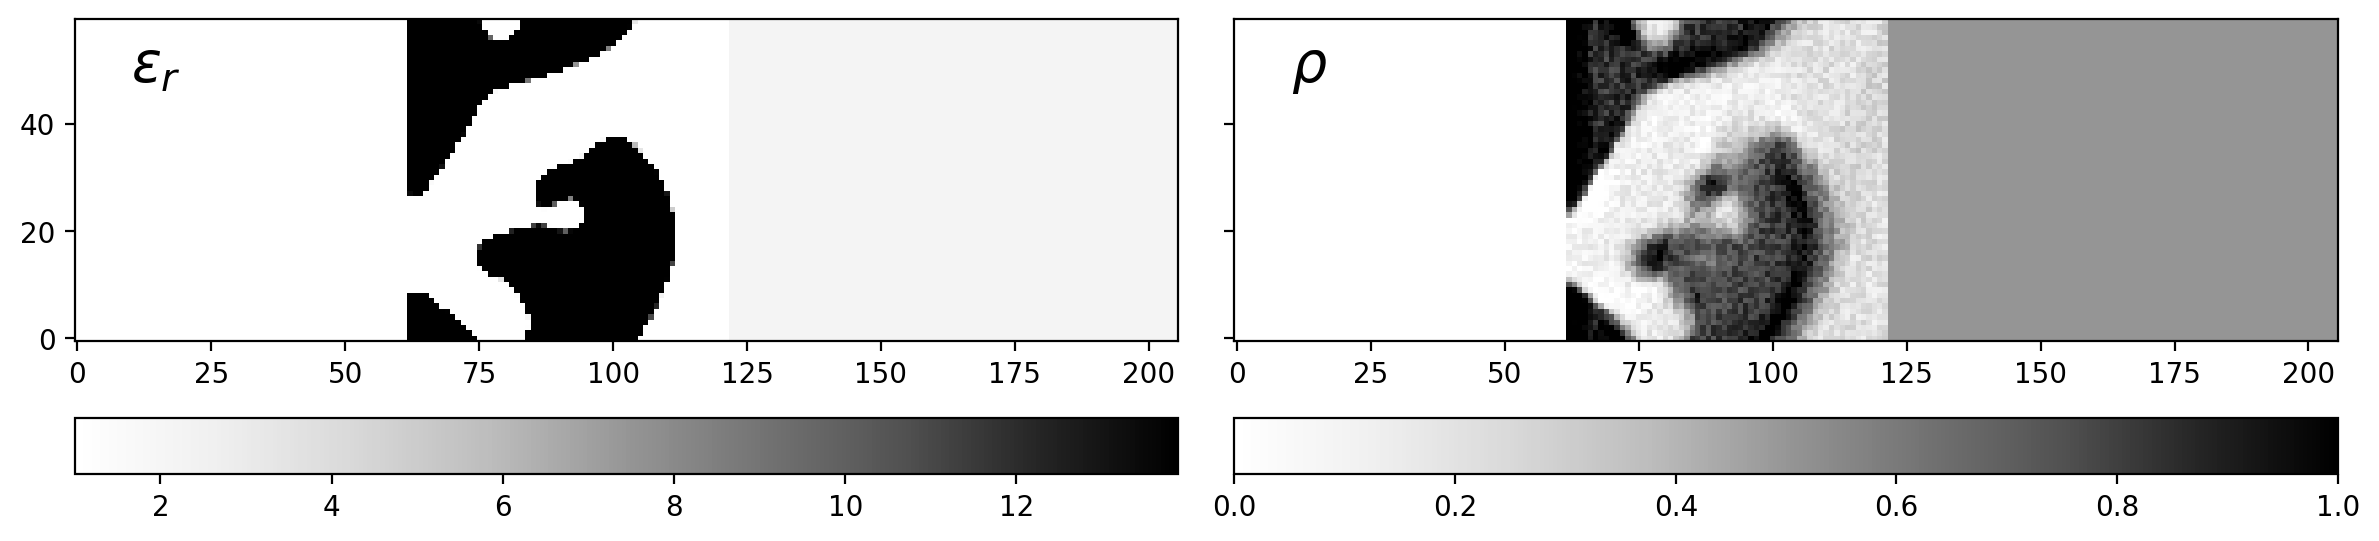

Epoch:  80/100 | Duration: 2.08 secs | Value: 5.190450e-02


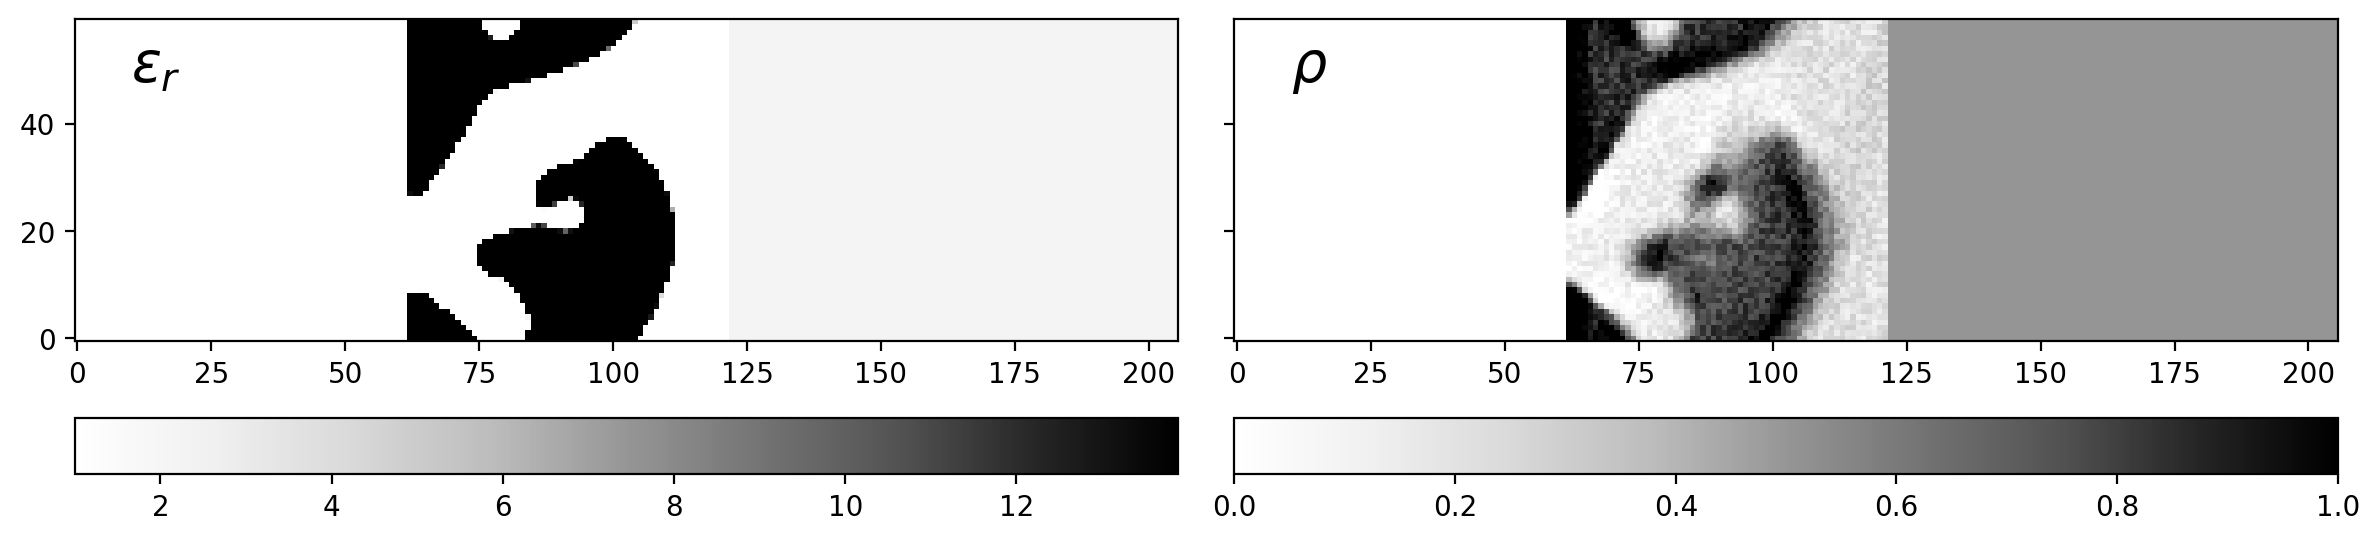

Epoch:  81/100 | Duration: 2.19 secs | Value: 5.192055e-02


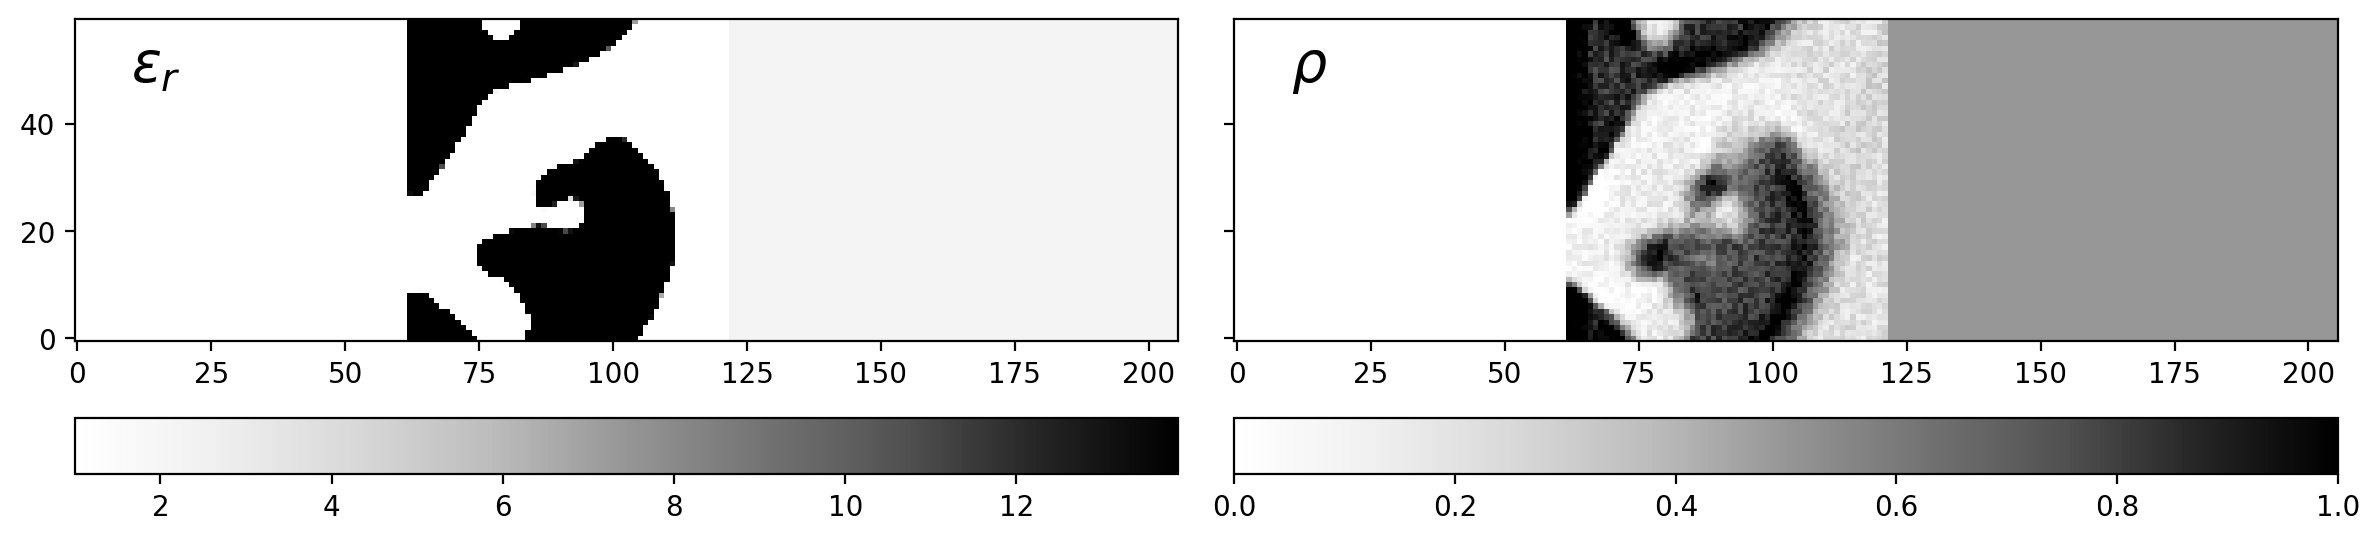

Epoch:  82/100 | Duration: 2.30 secs | Value: 5.191830e-02


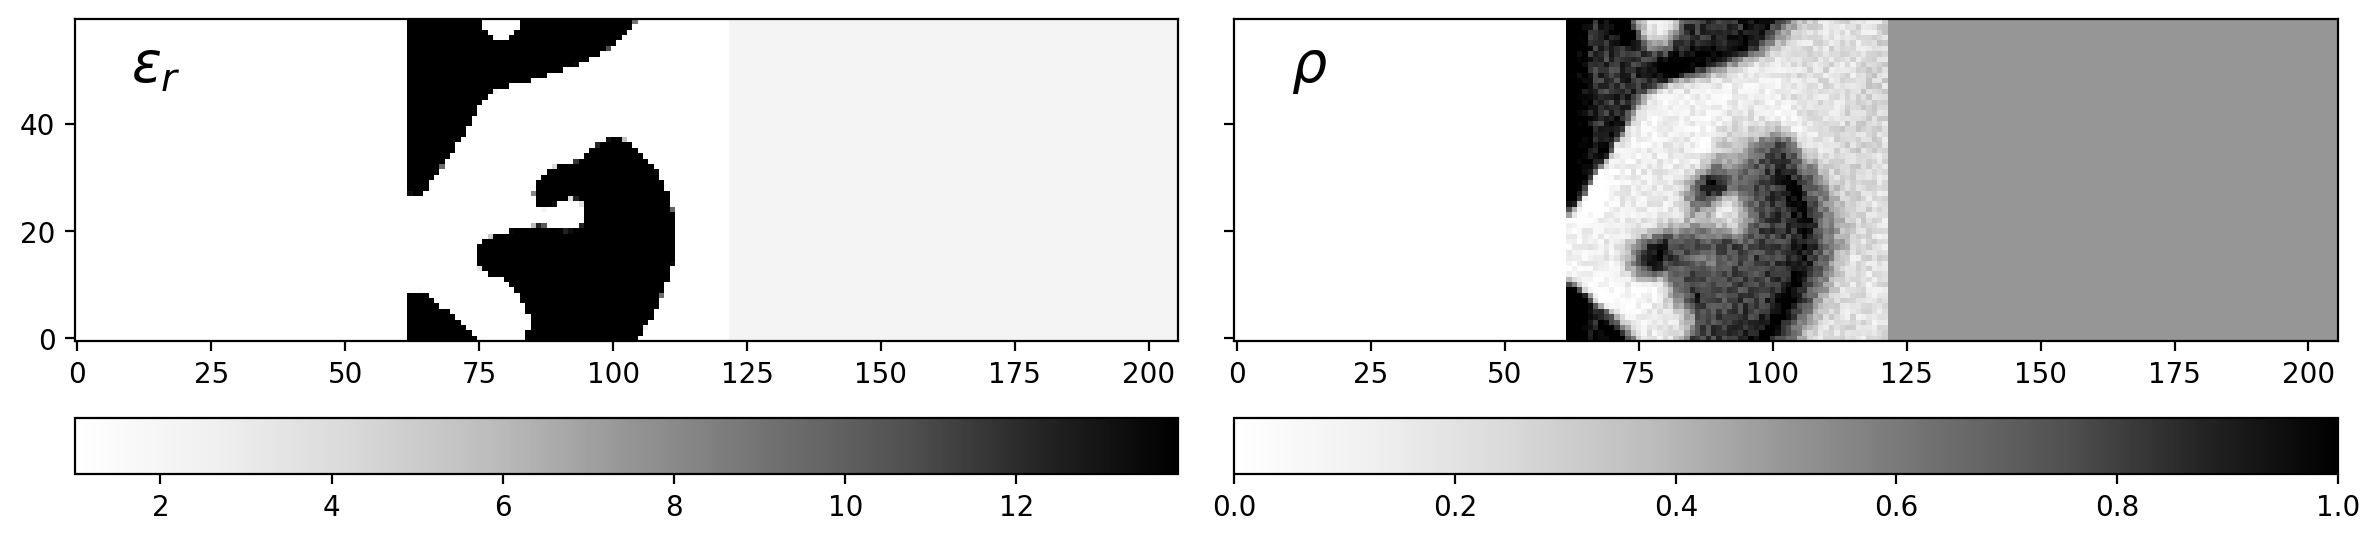

Epoch:  83/100 | Duration: 2.13 secs | Value: 5.195924e-02


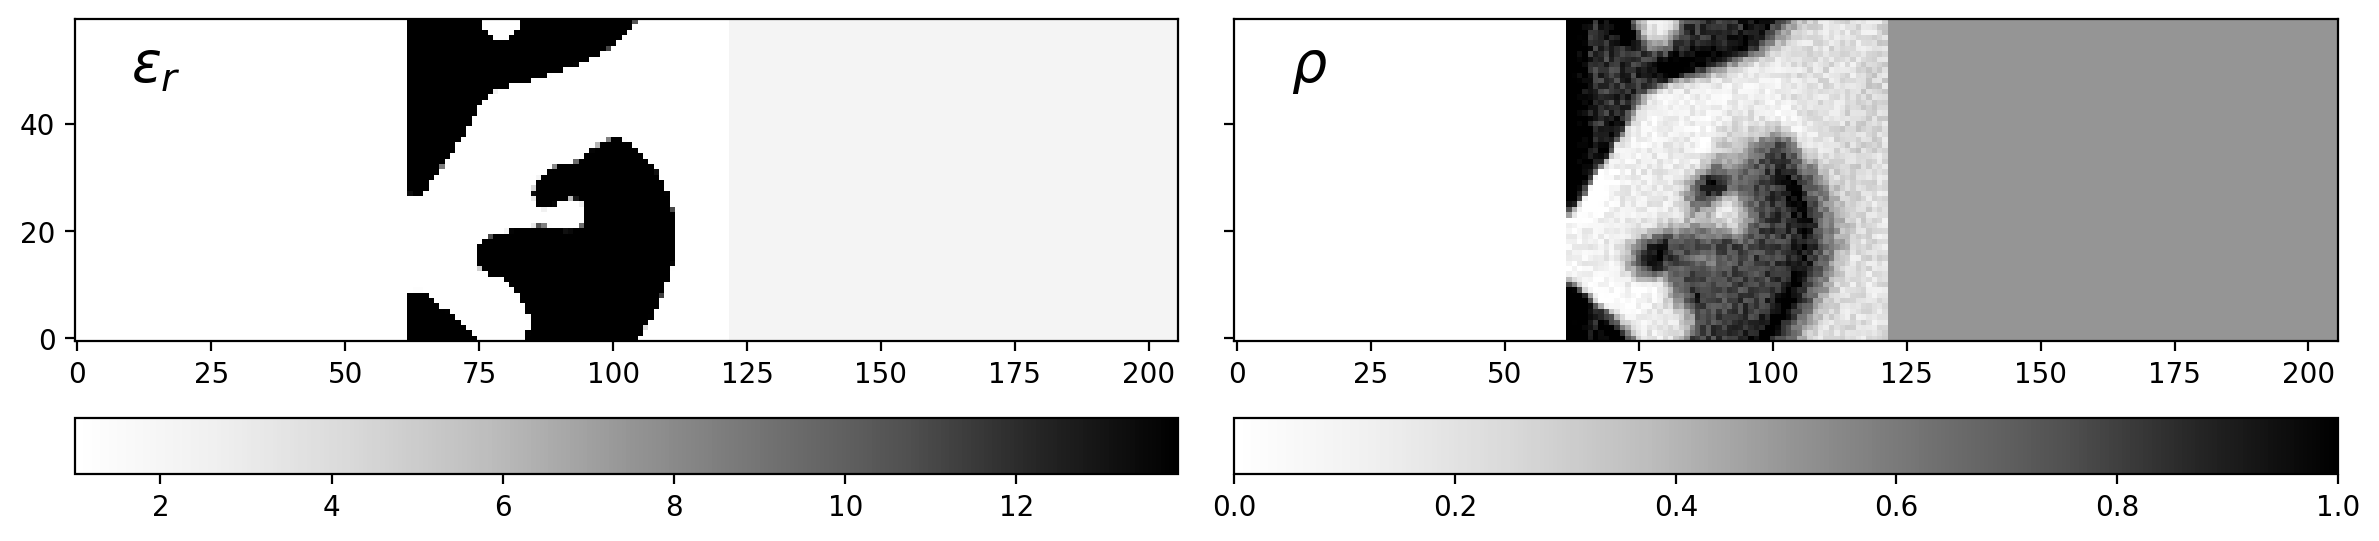

Epoch:  84/100 | Duration: 2.19 secs | Value: 5.202241e-02


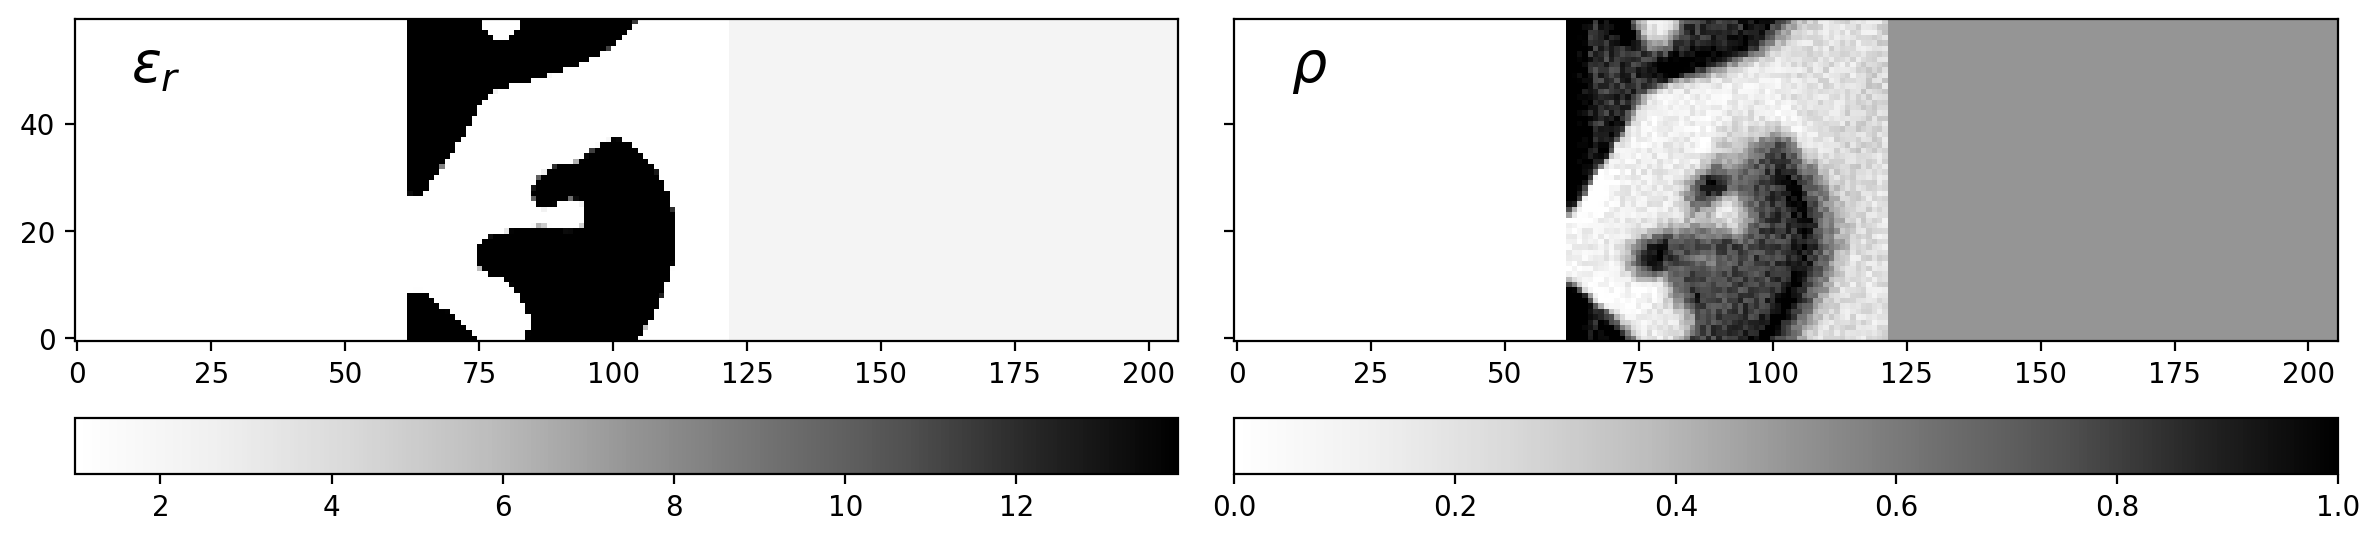

Epoch:  85/100 | Duration: 2.08 secs | Value: 5.210399e-02


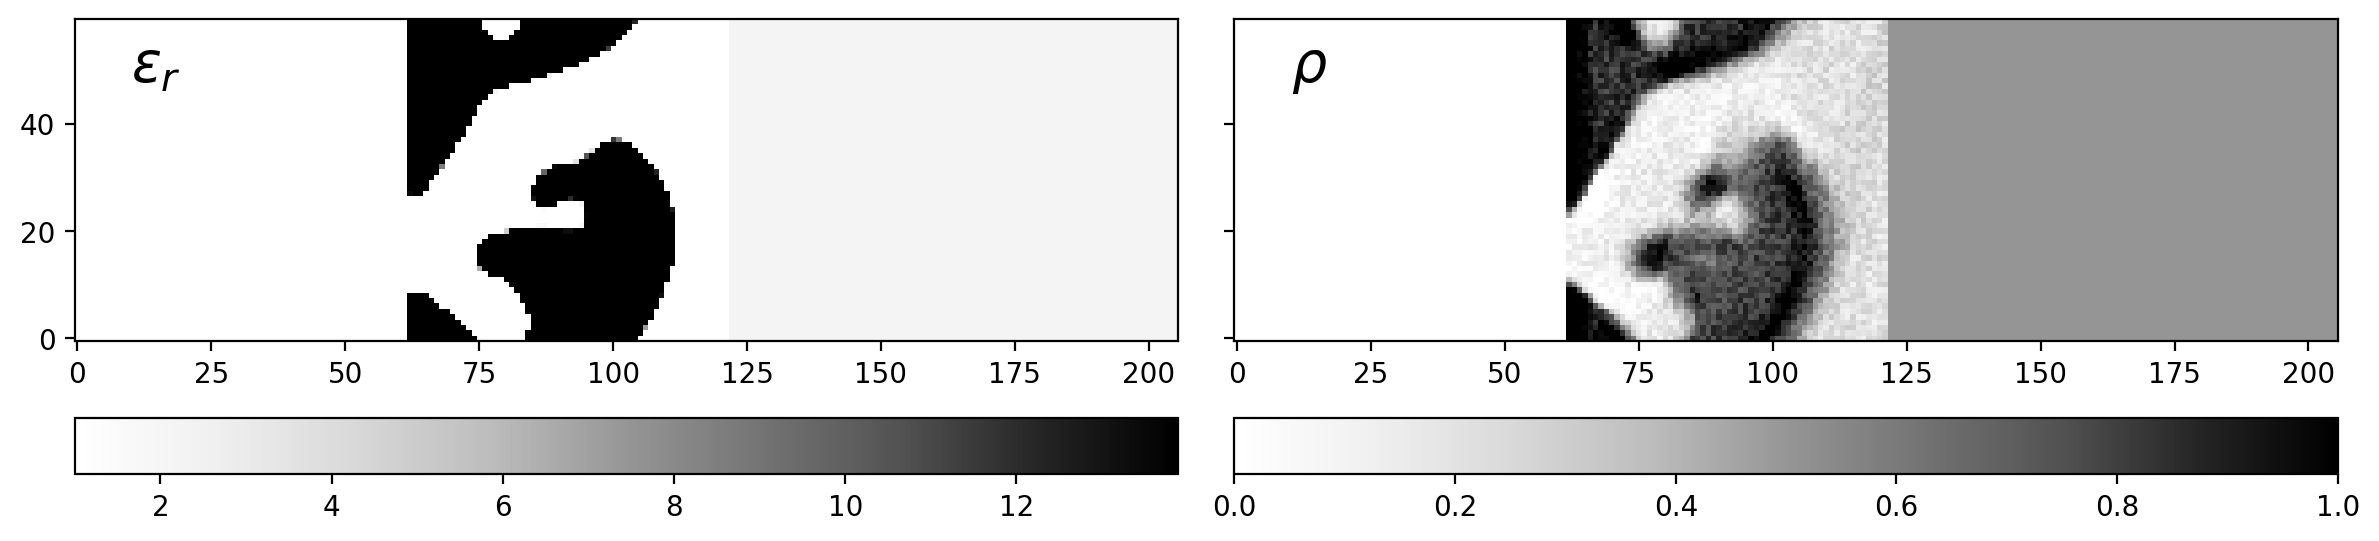

Epoch:  86/100 | Duration: 2.15 secs | Value: 5.218127e-02


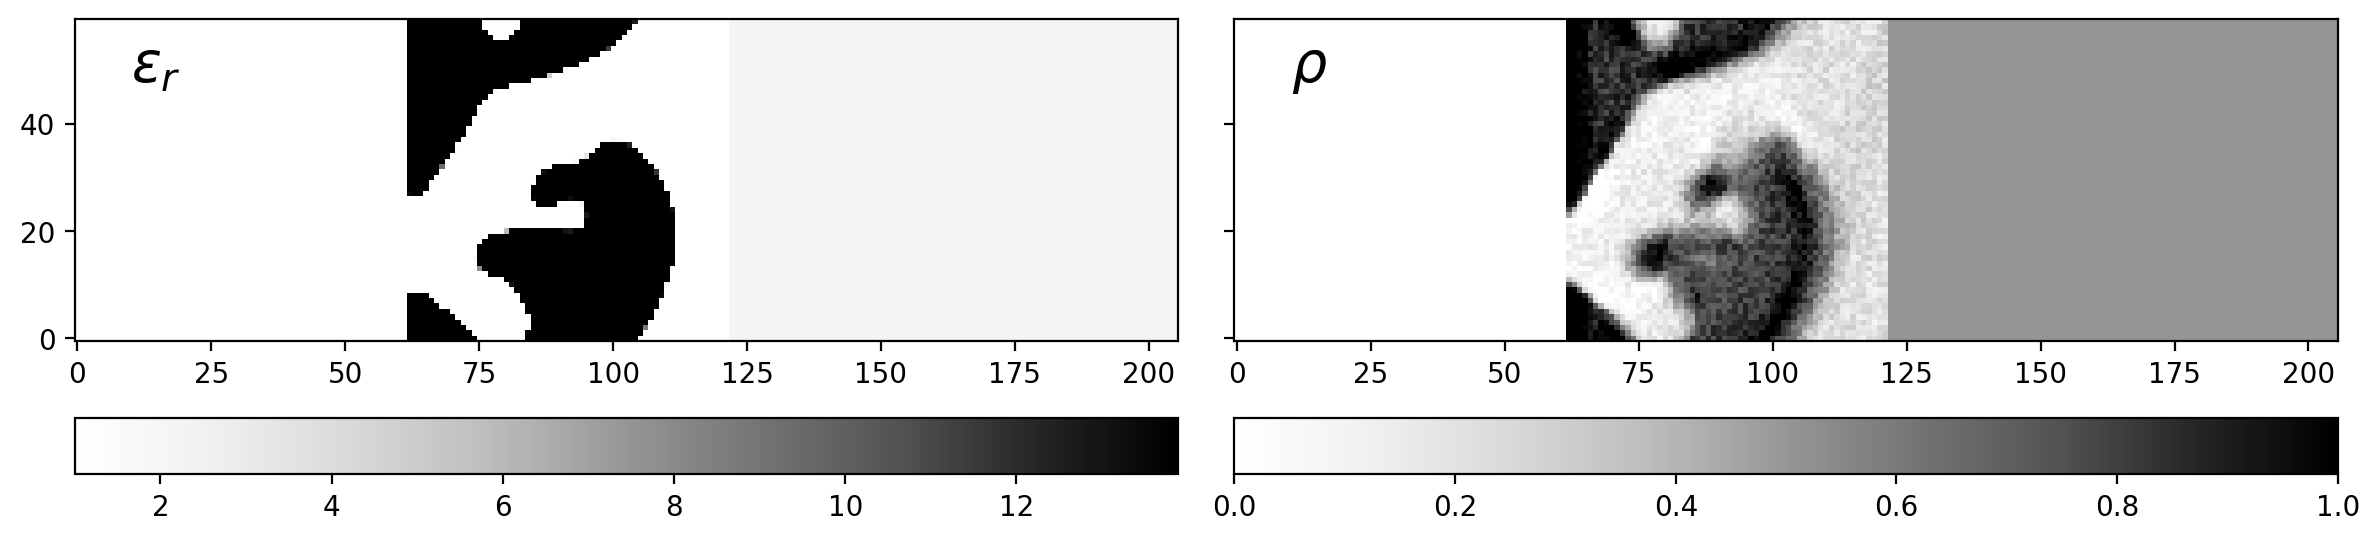

Epoch:  87/100 | Duration: 2.13 secs | Value: 5.230407e-02


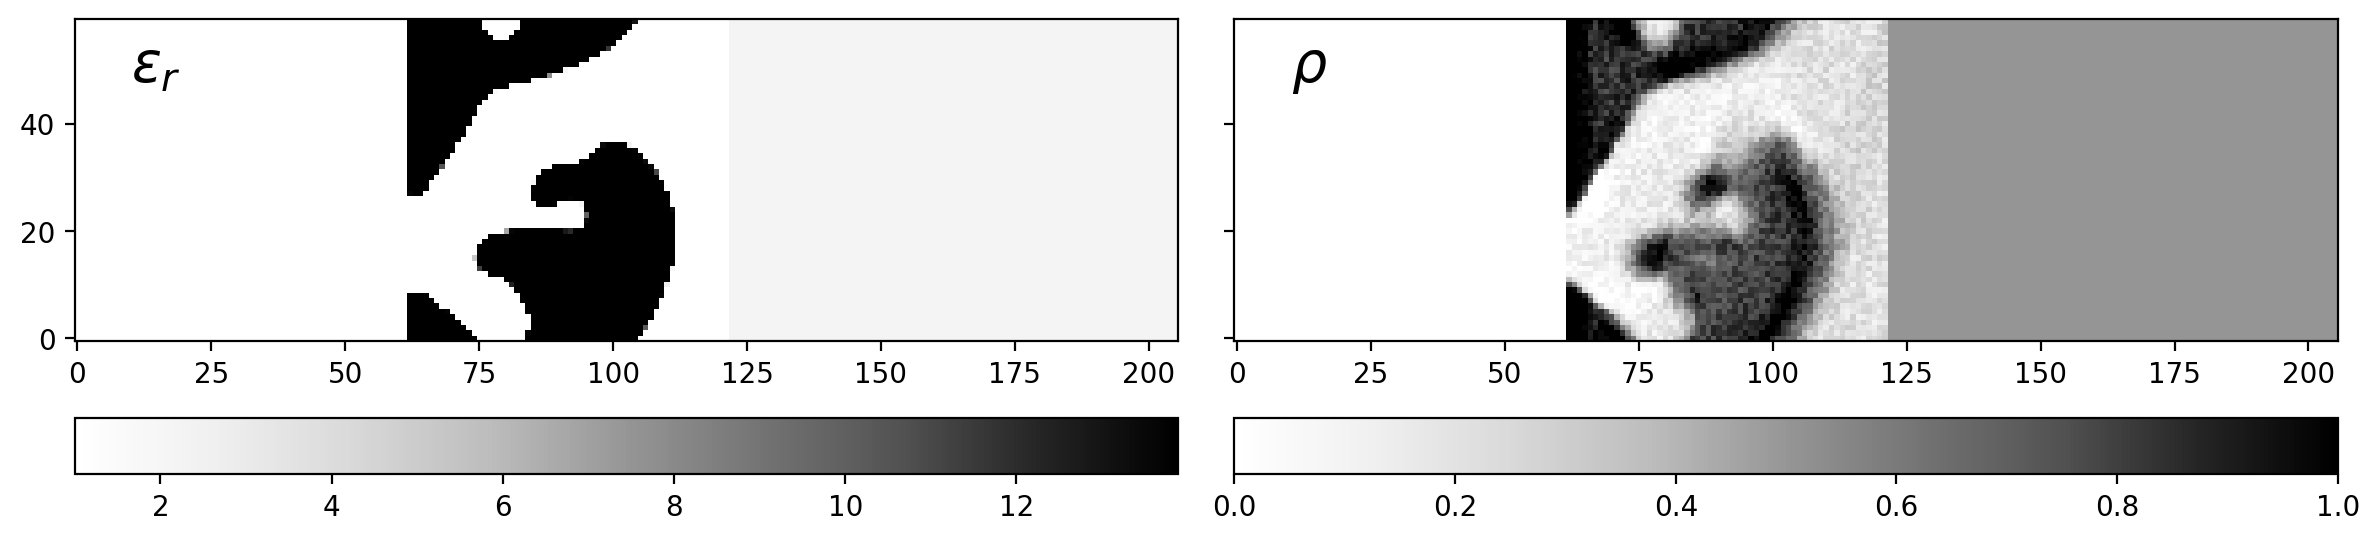

Epoch:  88/100 | Duration: 2.25 secs | Value: 5.245631e-02


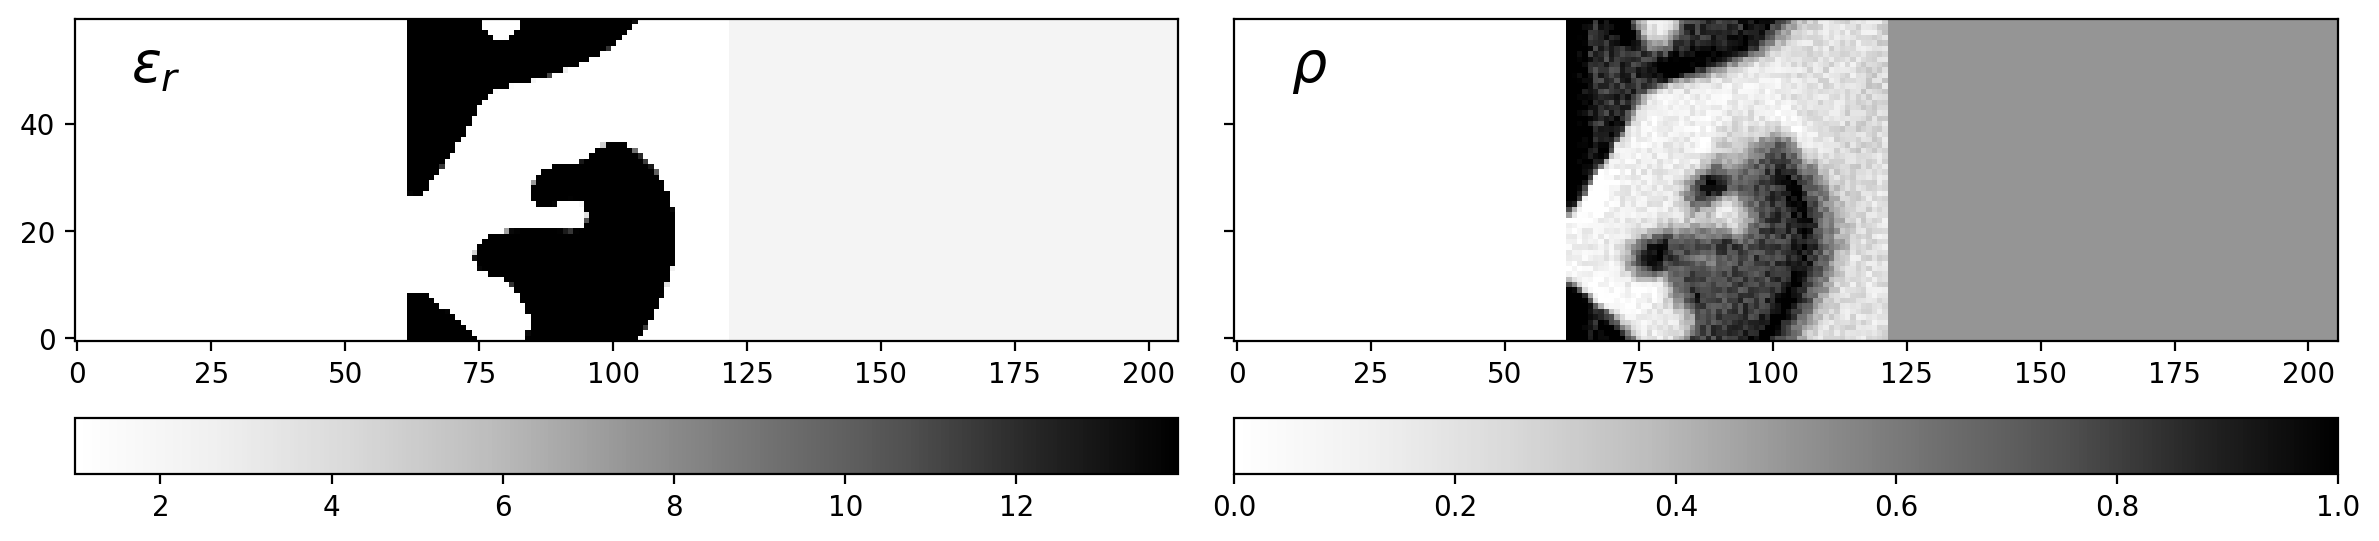

Epoch:  89/100 | Duration: 2.23 secs | Value: 5.259715e-02


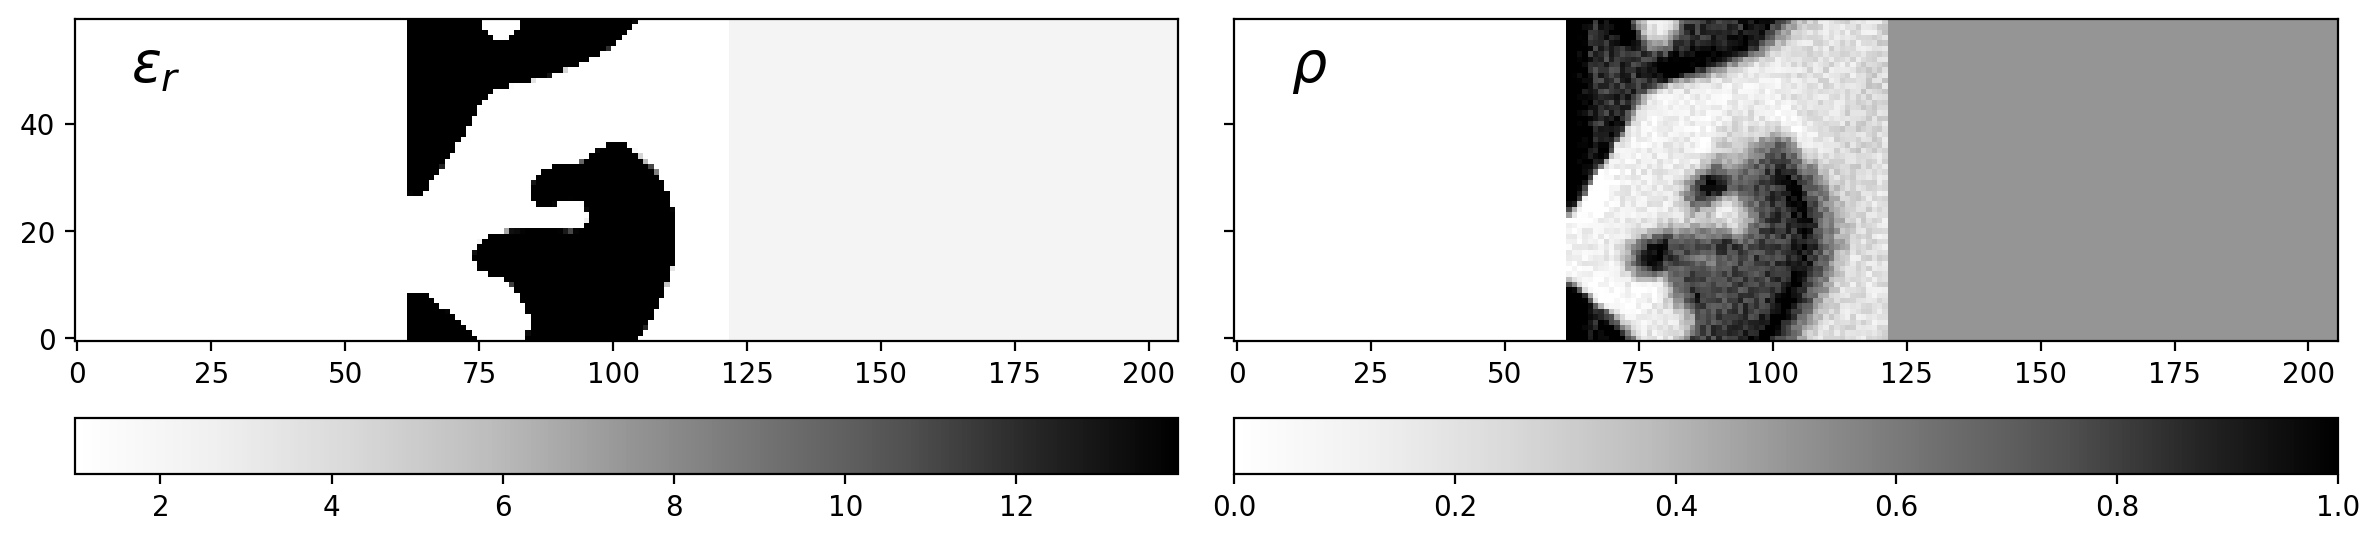

Epoch:  90/100 | Duration: 2.09 secs | Value: 5.268499e-02


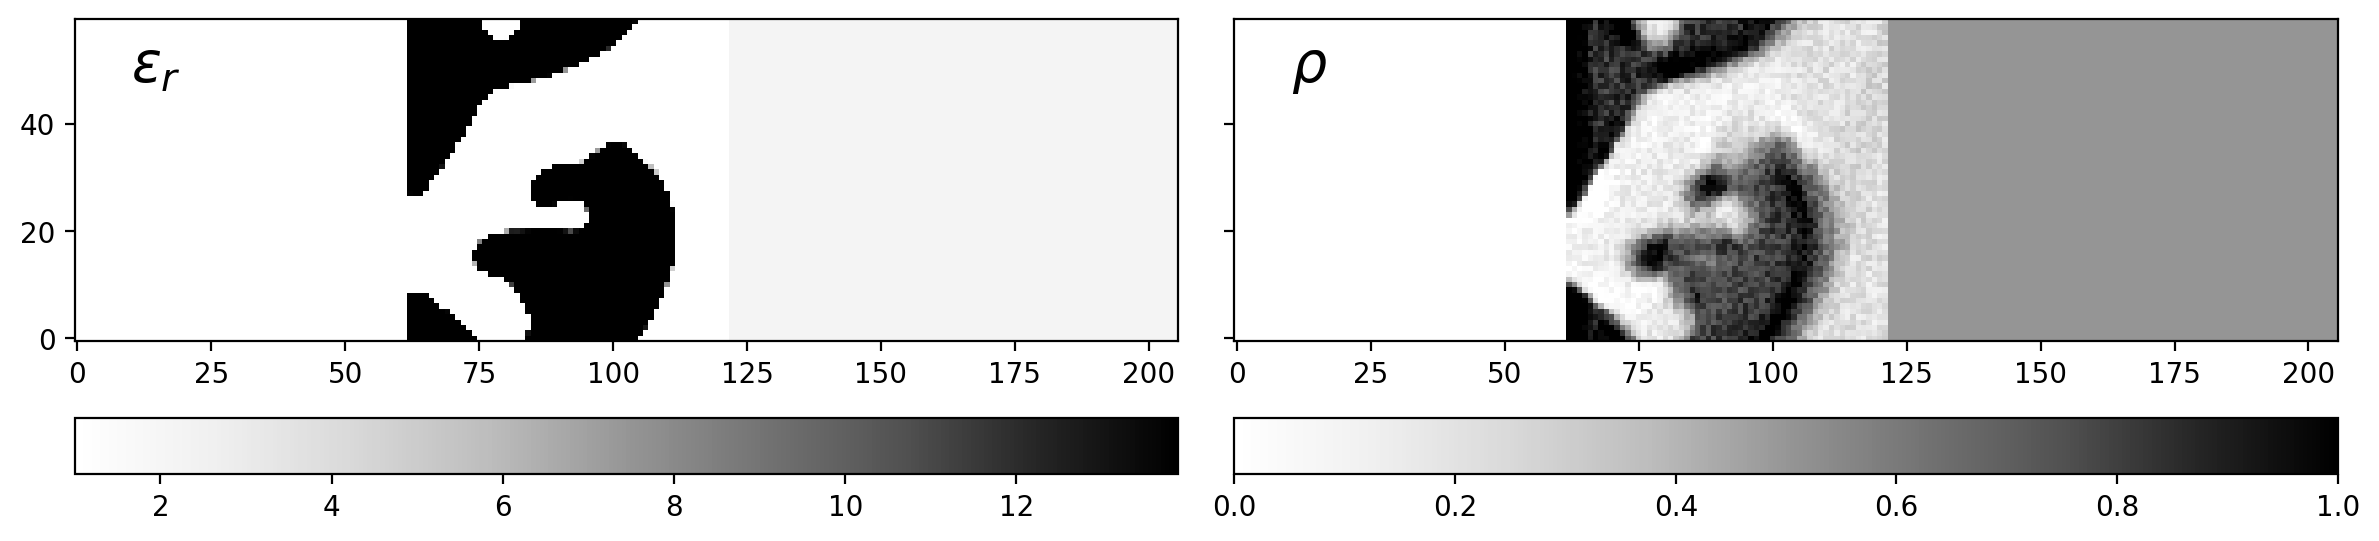

Epoch:  91/100 | Duration: 2.22 secs | Value: 5.275291e-02


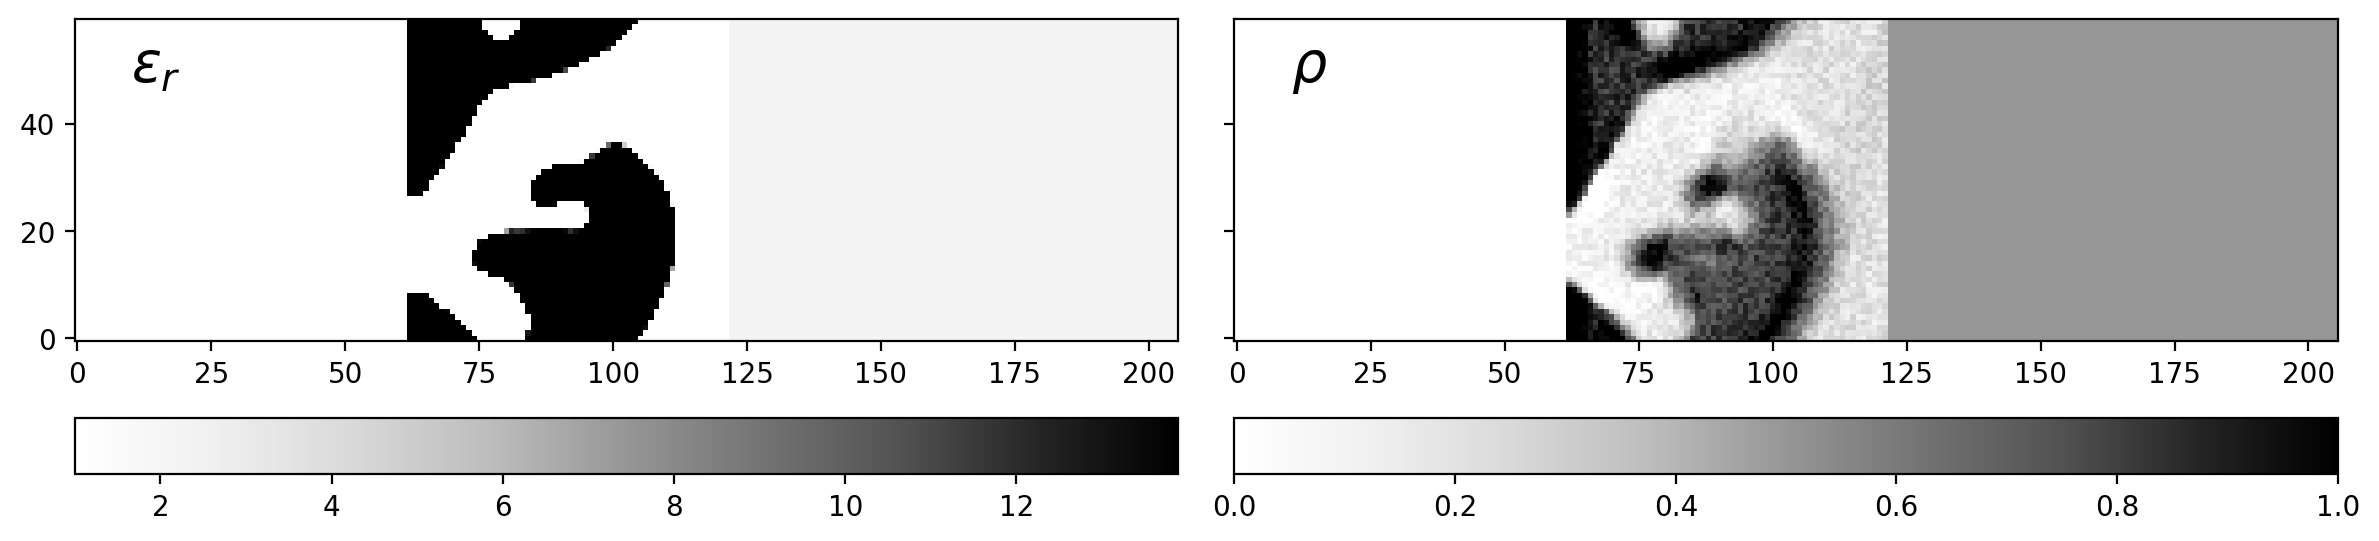

Epoch:  92/100 | Duration: 2.09 secs | Value: 5.279497e-02


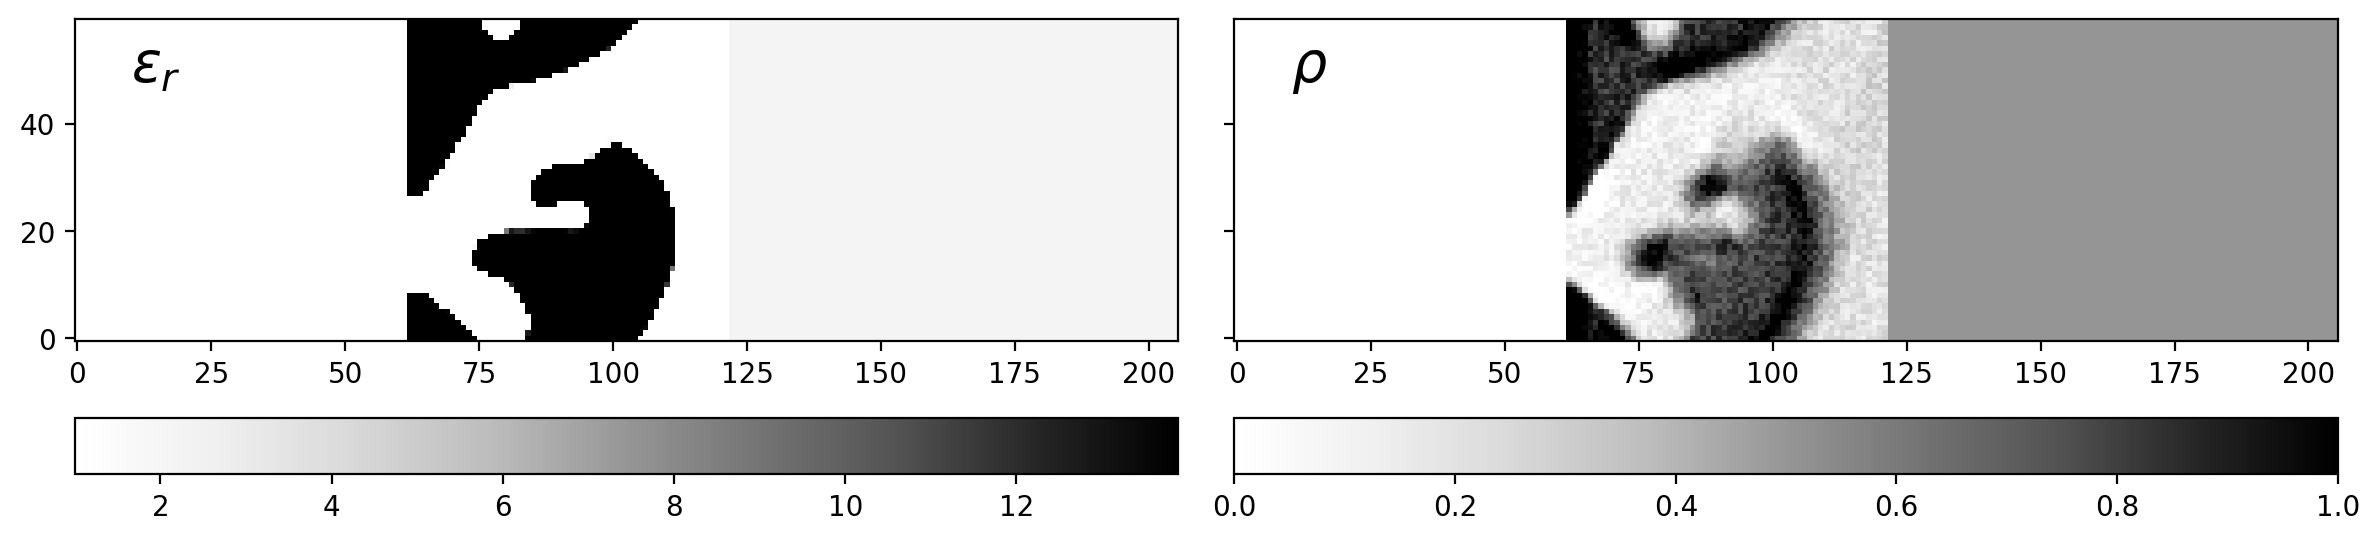

Epoch:  93/100 | Duration: 1.98 secs | Value: 5.283371e-02


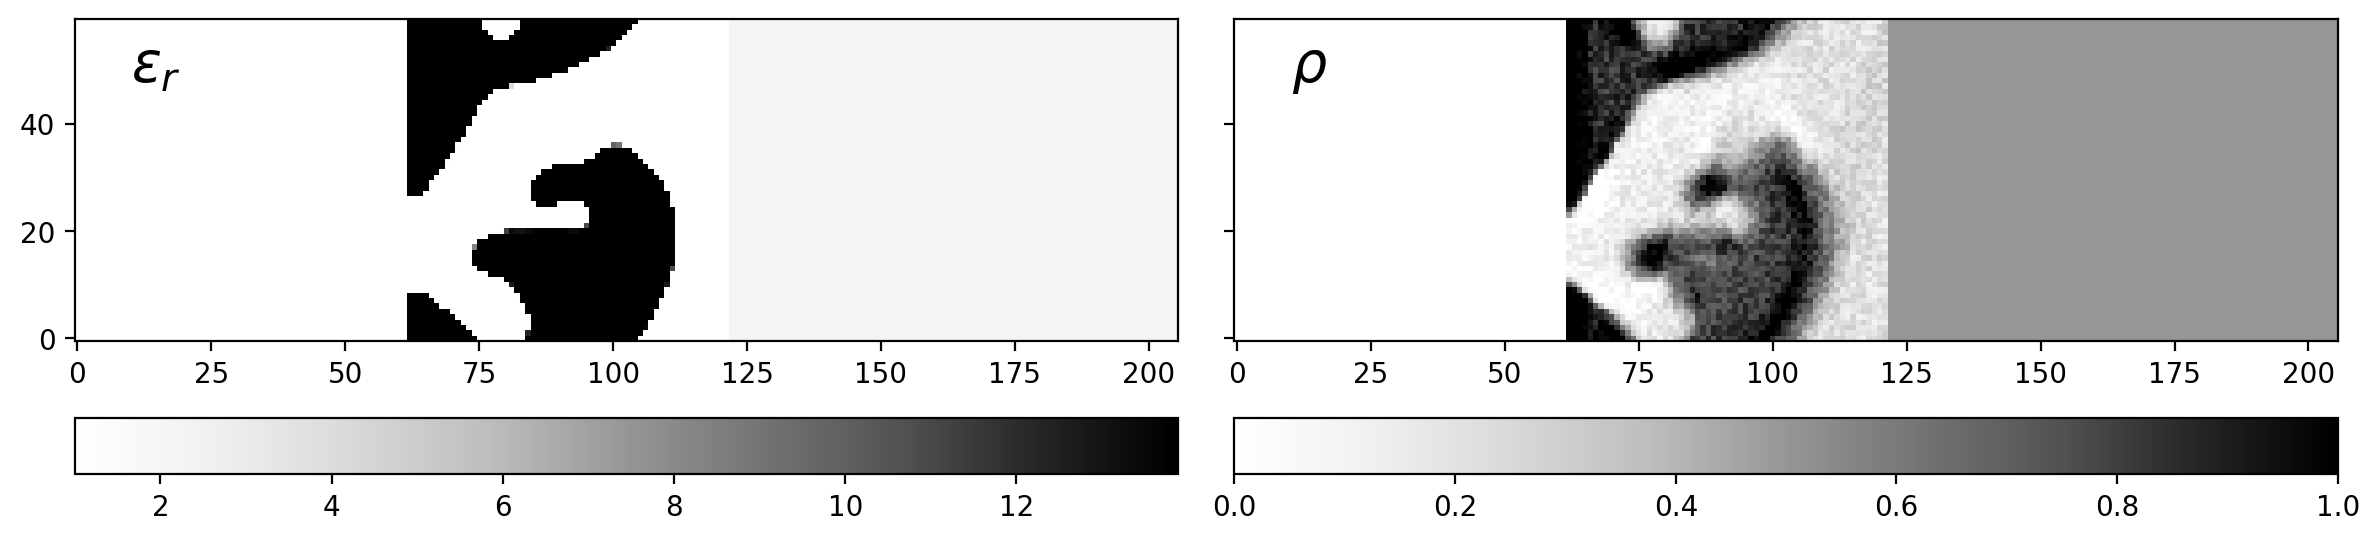

Epoch:  94/100 | Duration: 2.09 secs | Value: 5.289431e-02


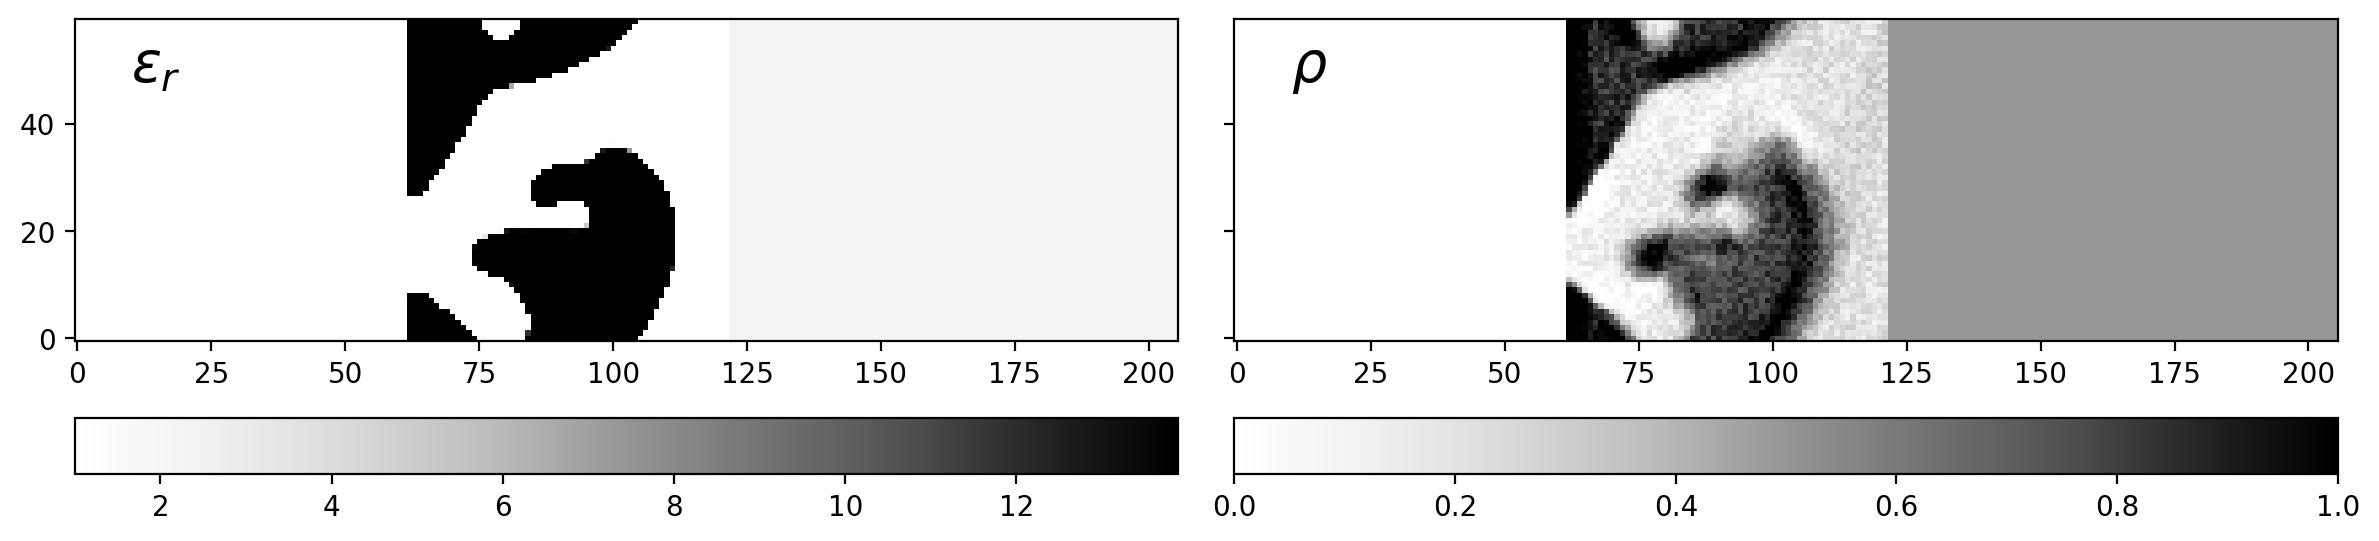

Epoch:  95/100 | Duration: 2.11 secs | Value: 5.298375e-02


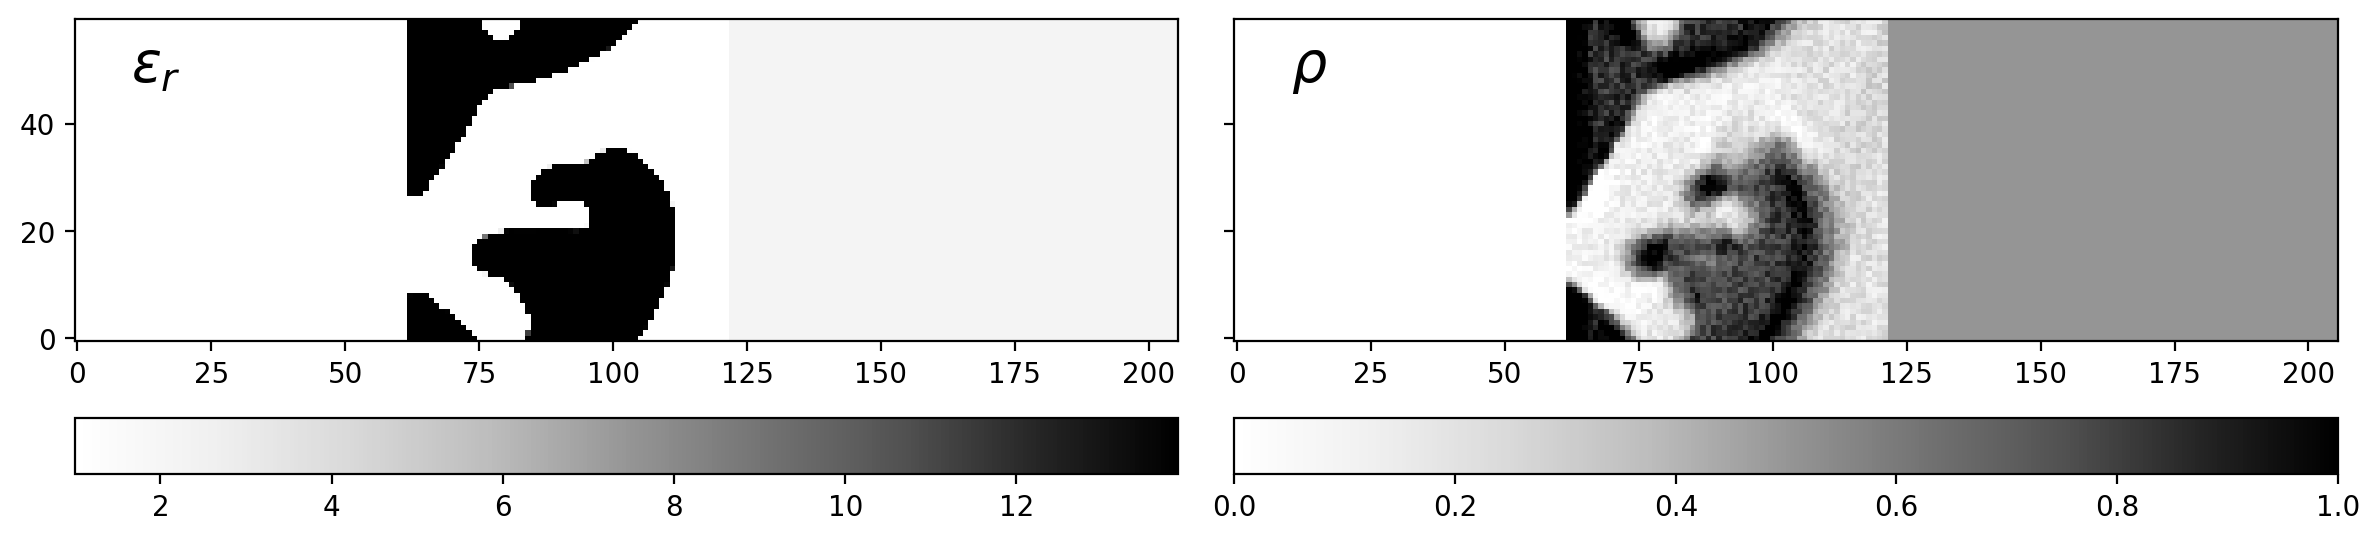

Epoch:  96/100 | Duration: 2.14 secs | Value: 5.301010e-02


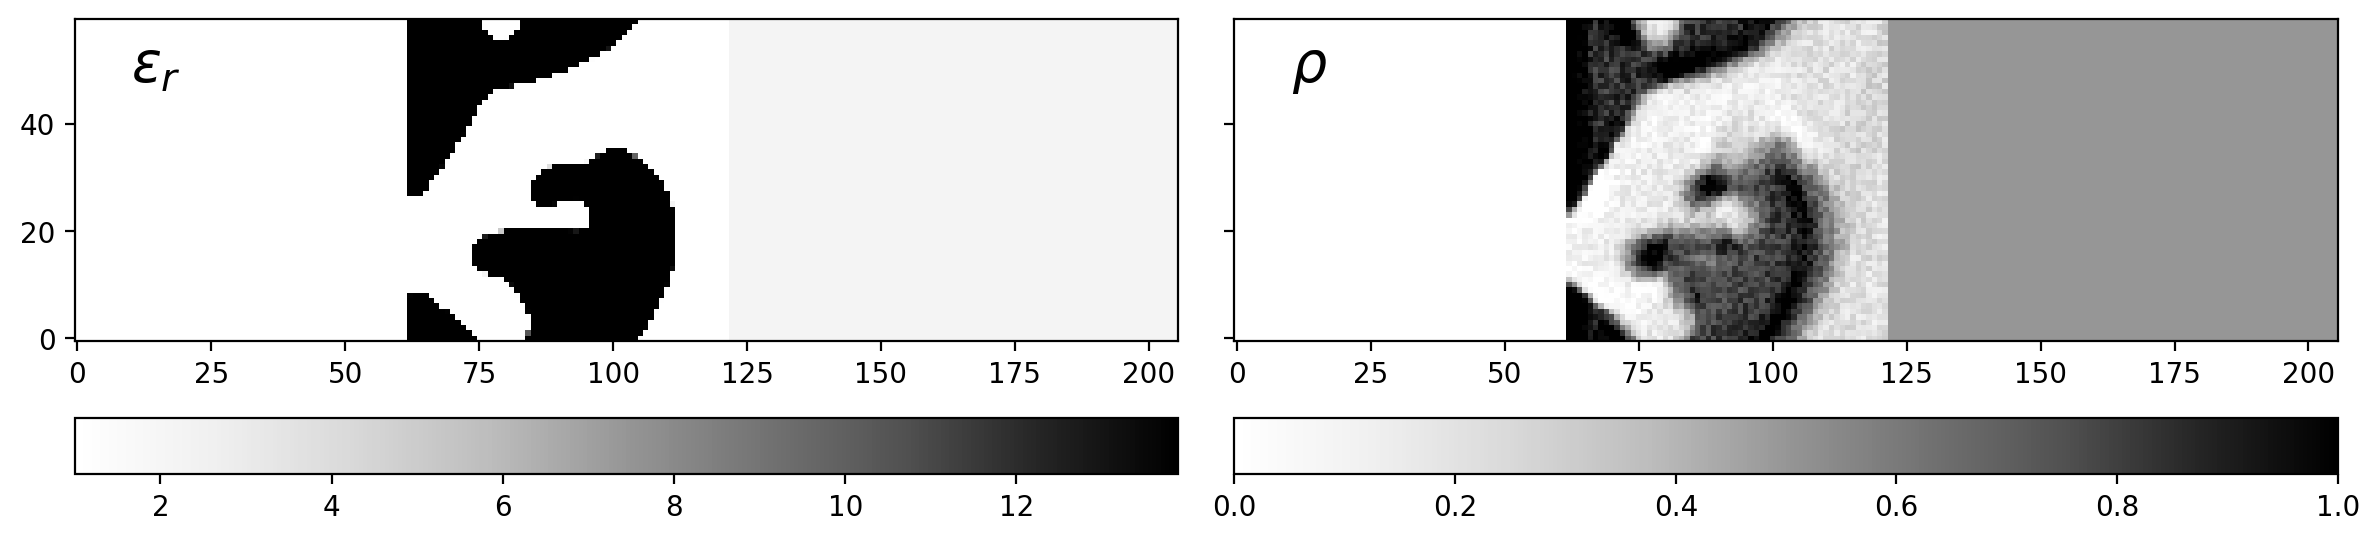

Epoch:  97/100 | Duration: 2.09 secs | Value: 5.301392e-02


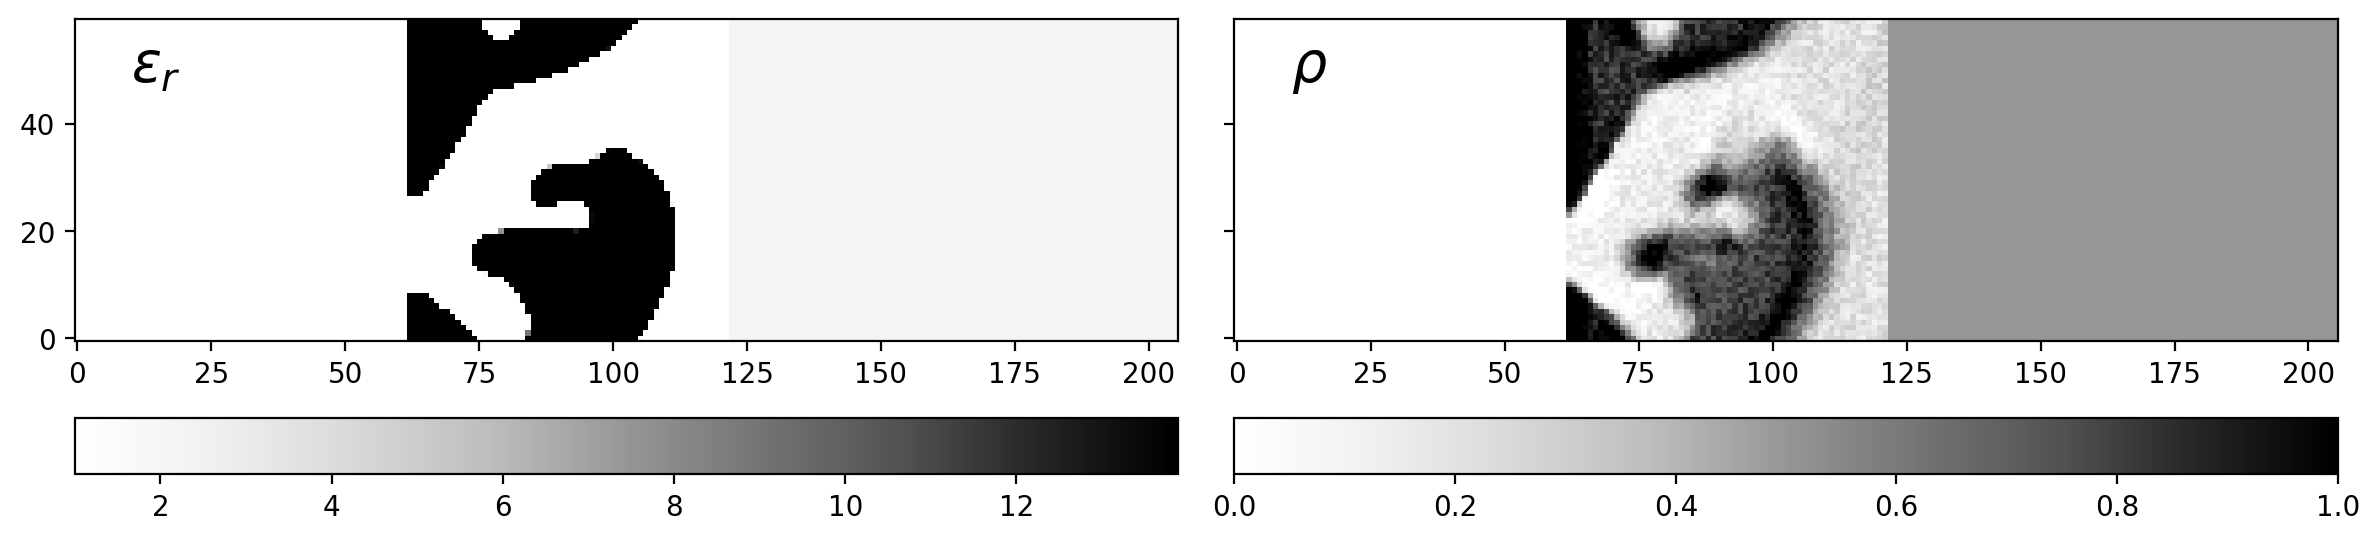

Epoch:  98/100 | Duration: 2.07 secs | Value: 5.302528e-02


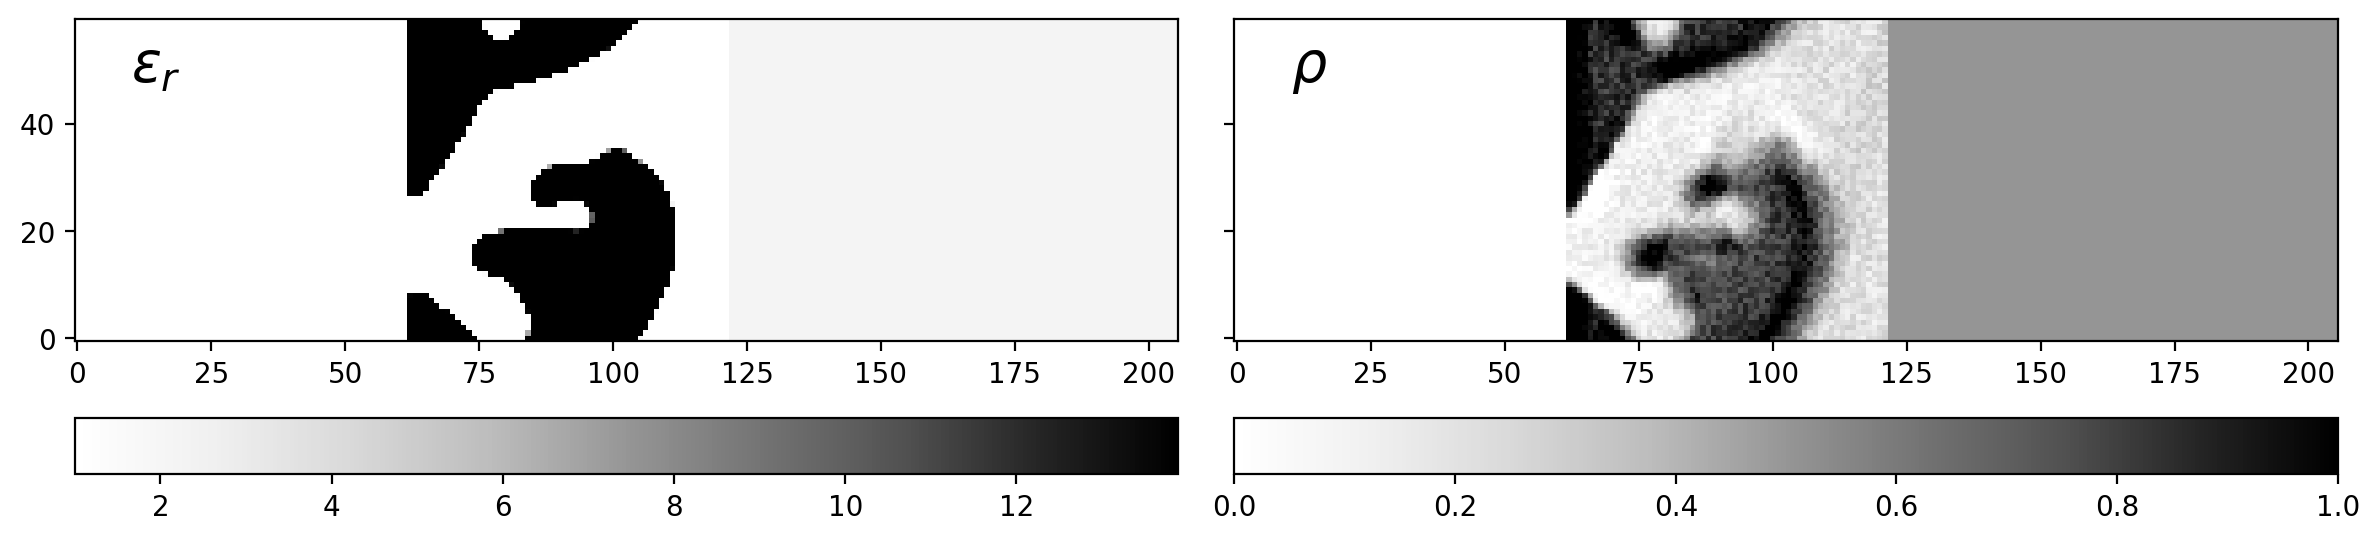

Epoch:  99/100 | Duration: 1.99 secs | Value: 5.304778e-02


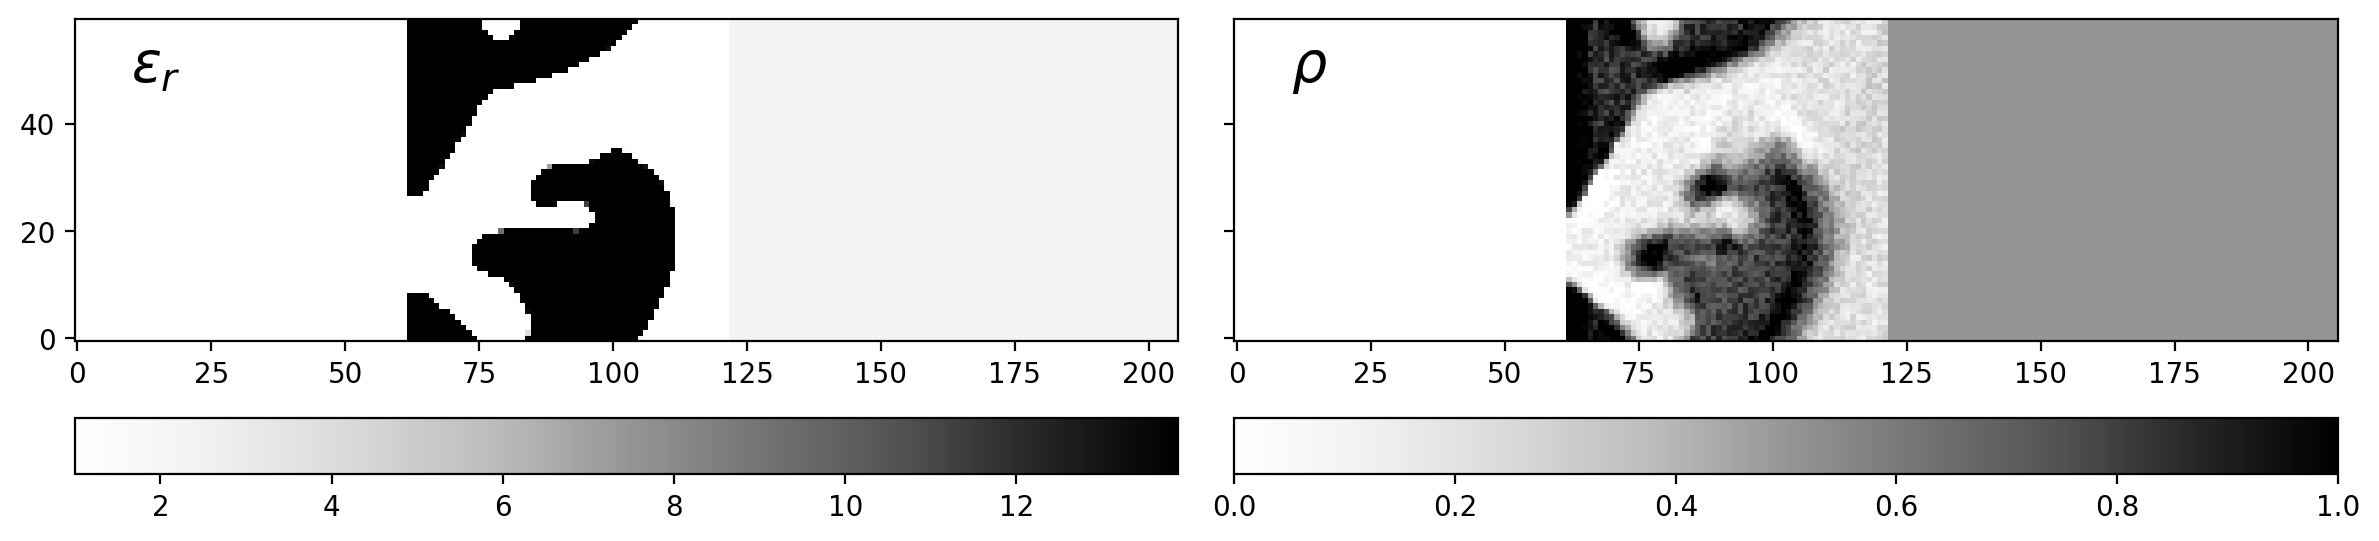

Epoch: 100/100 | Duration: 2.05 secs | Value: 5.309770e-02


In [126]:
# Compute the gradient of the objective function using reverse-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                                     Nsteps=Nsteps, direction='max', step_size=step_size, callback=callback_beta_schedule)

# Simulate the optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))

<AxesSubplot:xlabel='x', ylabel='y'>

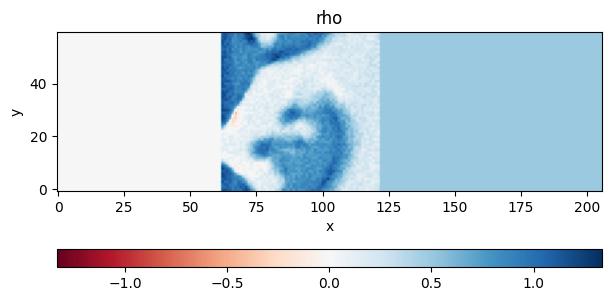

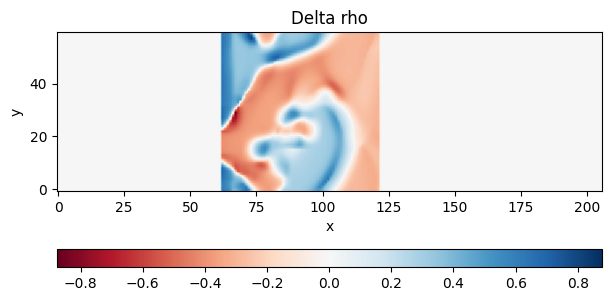

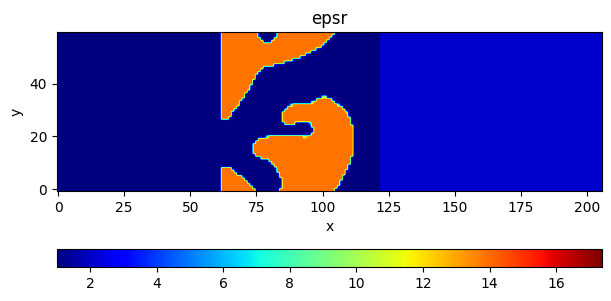

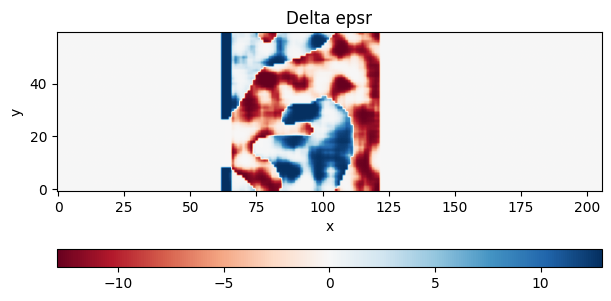

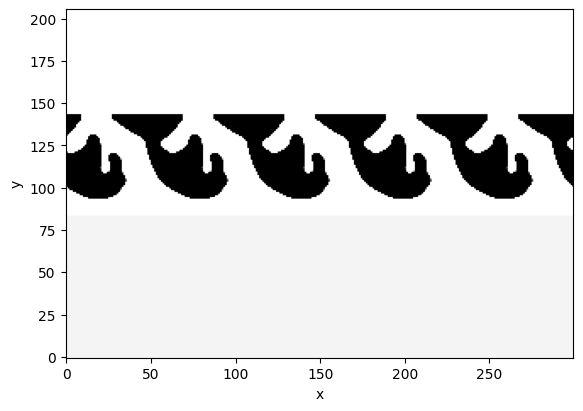

In [127]:
plot_rho = ceviche.viz.real(rho_optimum, DK_title='rho', cbar=True)
ceviche.viz.real(rho_optimum - rho, DK_title='Delta rho', cbar=True)
epsr_optimum = epsr_parameterization(
    rho_optimum, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)
viz_epsr(epsr_optimum)
ceviche.viz.real(epsr_optimum - epsr, cbar=True, DK_title="Delta epsr")
ceviche.viz.real(np.concatenate([epsr_optimum[::-1] for i in range(5)], axis=1).T, cmap='Greys', DK_min=1)


In [128]:
omega = frequencies[0]
simulation = ceviche.fdfd_hz(omega, dl, epsr_optimum, [Npml, 0], bloch_phases=[0, -(omega/(beta*C_0)*a)])
Ex, Ey, Hz = simulation.solve(source_tmp_list[0])
Ey = Ey - current_list[0] / (EPSILON_0 * 1j * omega)


In [129]:
def concatenate(arr, n, bloch_phase):
    arr2 = arr

    for _ in range(n-1):
        arr2 = arr2 * np.exp(1j*bloch_phase)
        arr = np.concatenate((arr, arr2), axis=1)

    return arr

<AxesSubplot:title={'center':'Hz'}, xlabel='x', ylabel='y'>

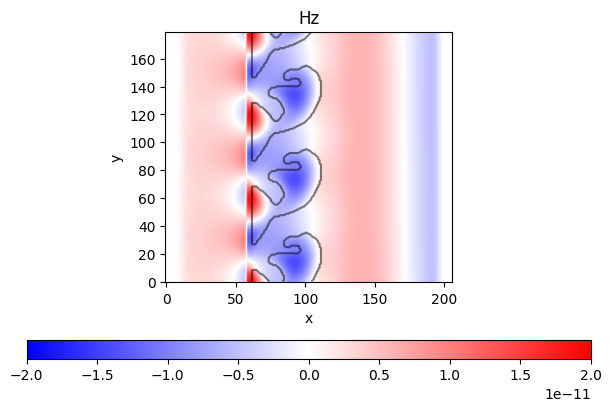

In [130]:
H_conc = concatenate(Hz, 3, bloch_phase=-(omega/(beta*C_0)*a))
epsr_conc = np.concatenate([epsr_optimum for i in range(3)], axis=1)
ceviche.viz.real(H_conc, DK_title='Hz', DK_max=2e-11, outline=epsr_conc, cbar=True, cmap='bwr')

In [131]:
# epsr_optimum = epsr_parameterization(
#     rho_optimum, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)
# delta_rho = rho_optimum - rho_initial

# # save the structure to txt
# np.savetxt("saved_structures\\MT\\rho_optimal_Si_SiO2.txt", rho_optimum)
# np.savetxt("saved_structures\\MT\\epsr_optimal_Si_SiO2.txt", epsr_optimum)
# np.savetxt("saved_structures\\MT\\drho_optimal_Si_SiO2.txt", delta_rho)

In [132]:
# # load the structure from txt
# rho = np.loadtxt("saved_structures\\MT\\rho_optimal_Si.txt")
# rho = np.loadtxt("saved_structures\\schedule\\rho_92.txt")
# epsr = np.loadtxt("saved_structures\\MT\\epsr_optimal_Si.txt")

In [133]:
def viz_epsr_rho_gif(epsr, rho):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 3), dpi=200, tight_layout=True)
    er = axs[0].imshow(epsr.T, cmap='Greys', origin='lower')
    rh = axs[1].imshow(np.real(rho).T, cmap='Greys', origin='lower', vmin=0, vmax=1)

    # text
    axs[0].text(10, Ny - Ny//5, r"$\varepsilon_r$", fontsize=20)
    axs[1].text(10, Ny - Ny//5, r"$\rho$", fontsize=20)

    # colorbars
    cbar_er = plt.colorbar(er, ax=axs[0], orientation="horizontal", aspect=20)
    plt.colorbar(rh, ax=axs[1], orientation="horizontal", aspect=20)

In [134]:
def animate(Nframes, gif_name="mygif"):
    filenames = []

    for iteration in range(Nframes):
        rho_it = np.loadtxt(f"saved_structures\\schedule\\rho_{iteration}.txt")
        epsr_it = epsr_parameterization(rho_it, bg_rho, design_region, epsr_min, epsr_max,
                                                radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)
        viz_epsr_rho_gif(epsr_it, rho_it)
        filename = f"saved_structures\\schedule\\{iteration}.png"
        filenames.append(filename)
        plt.savefig(filename, dpi=200)
        plt.close()

    # build gif
    with imageio.get_writer(f'saved_structures\\schedule\\{gif_name}.gif', mode='I') as writer:
        print('Creating gif...')
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        print('Gif saved\n')

    # Remove files
    for filename in set(filenames):
        os.remove(filename)


In [ ]:
animate(Nsteps, gif_name='Si_optimization');